In [20]:
from astropy.table import QTable
import numpy as np
from scipy import optimize
from scipy import special
from scipy import interpolate
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from calc_XY import calc_XY
import cProfile
import re
import pstats
from pstats import SortKey
import pandas as pd

In [2]:
def marginalized_chisq(tp, per, ecc, t, coef_skeleton, snr, sigw):
    X, Y = calc_XY(t, t.shape[0], tp, per, ecc)
    coef_matrix = coef_skeleton.copy()
    coef_matrix[-4, :] *= X
    coef_matrix[-3, :] *= Y
    coef_matrix[-2, :] *= X
    coef_matrix[-1, :] *= Y
    
    coef = np.linalg.lstsq(coef_matrix.T, snr, rcond=None)[0]
    chisq = np.sum((snr - coef@coef_matrix)**2)
    
    #compute the marginalization factor
    norm = np.log(np.linalg.det(coef_matrix@coef_matrix.T))
    
    #compute the Jacobian determinant to account for the priors of the Campbell elements
    B, G, A, F = coef[-4:]
    u = 0.5*(A**2 + B**2 + F**2 + G**2)
    v = A*G - B*F
    smarcsec = np.sqrt(u + np.sqrt(u**2 - v**2)) 
    sinsq_i = 2 - 2*u/smarcsec**2
    # set floors on sin(i) and sma to avoid a singularity
    # floors of 1e-2 in sin(i)^2 and the typical position error divided by sqrt(n)
    jacdet_flat = (sinsq_i + 1e-2)*(smarcsec + np.median(sigw)/len(sigw)**0.5)**3 #flat prior: 3
    jacdet_prop = (sinsq_i + 1e-2)*(smarcsec + np.median(sigw)/len(sigw)**0.5)**4 #prior 1/a: 4

    return chisq, chisq + norm + 2*np.log(jacdet_flat), chisq + norm + 2*np.log(jacdet_prop)

In [4]:
def create_grid(p_num, ecc_num, tp_num, p_range, ecc_range):
    # store the grids with different numbers of grid points
    p_grid = []
    ecc_grid = []
    tp_grid = []
    for i in range(len(p_num)):
        periods = np.linspace(p_range[0], p_range[1], p_num[i])
        p_grid.append(periods)
    for i in range(len(ecc_num)):
        eccs = np.linspace(ecc_range[0], ecc_range[1], ecc_num[i])
        ecc_grid.append(eccs)
    for i in range(len(tp_num)):
        tps = np.linspace(0, 2*np.pi, tp_num[i])
        tp_grid.append(tps)
    return p_grid, ecc_grid, tp_grid


In [5]:
# compute the likelihood distribution for various tp's, periods, and ecc's
def likelihood_pixel(tps, periods, eccs, t, coef_skeleton, snr, sigw):
    like_ori = np.zeros((len(periods), len(eccs), len(tps)))
    like_flat = np.zeros((len(periods), len(eccs), len(tps)))
    like_prop = np.zeros((len(periods), len(eccs), len(tps)))
    for i in range(len(periods)):
        for j in range(len(eccs)):
            for k in range(len(tps)):
                logL_ori, logL_flat, logL_prop = marginalized_chisq(tps[k], periods[i], eccs[j], t, coef_skeleton, snr, sigw)
                like_ori[i, j, k] = np.exp(-0.5*logL_ori)
                like_flat[i, j, k] = np.exp(-0.5*logL_flat)
                like_prop[i, j, k] = np.exp(-0.5*logL_prop)
    return like_ori, like_flat, like_prop                    

# find the likelihood distribution marginalized over tp
def likelihood(tps, periods, eccs, t, coef_skeleton, snr, sigw):
    like_ori = np.zeros((len(periods), len(eccs)))
    like_mrgnlzd_flat = np.zeros((len(periods), len(eccs)))
    like_mrgnlzd_prop = np.zeros((len(periods), len(eccs)))
    for i in range(len(periods)):
        for j in range(len(eccs)):
            like_ori_sub = np.zeros(len(tps))
            like_sub_flat = np.zeros(len(tps))
            like_sub_prop = np.zeros(len(tps))
            for k in range(len(tps)):
                logL_ori, logL_flat, logL_prop = marginalized_chisq(tps[k], periods[i], eccs[j], t, coef_skeleton, snr, sigw)
                like_ori_sub[k] = np.exp(-0.5*logL_ori)
                like_sub_flat[k] = np.exp(-0.5*logL_flat)
                like_sub_prop[k] = np.exp(-0.5*logL_prop)
            like_ori[i, j] = np.sum(like_ori_sub)          
            like_mrgnlzd_flat[i, j] = np.sum(like_sub_flat)
            like_mrgnlzd_prop[i, j] = np.sum(like_sub_prop)    
    return like_ori, like_mrgnlzd_flat, like_mrgnlzd_prop    

# find the likelihood distribution from two-step marginalization
def taylor_likelihood(tps, periods, eccs, t, coef_skeleton, snr, sigw, amax, N):
    like_mrgnlzd_fix = np.zeros((len(periods), len(eccs))) # for the fixed Jacobian determinant
    like_mrgnlzd_expand = np.zeros((len(periods), len(eccs))) # for the Taylor expansion
    for i in range(len(periods)):
        for j in range(len(eccs)):
            like_sub_fix = np.zeros(len(tps))
            like_sub_expand = np.zeros(len(tps))
            for k in range(len(tps)):
                like_sub_fix[k], like_sub_expand[k] = like_taylor(tps[k], periods[i], eccs[j], t, coef_skeleton, snr, sigw)
            like_mrgnlzd_fix[i, j] = np.sum(like_sub_fix)
            like_mrgnlzd_expand[i, j] = np.sum(like_sub_expand)    
    return like_mrgnlzd_fix, like_mrgnlzd_expand    


In [6]:
# compute the 1-sigma contours
def onesig(like, periods, eccs):
    dA = (periods[1] - periods[0])*(eccs[1] - eccs[0])
    x, y = np.meshgrid(periods, eccs)

    # Uniform weights for Riemann sum
    weights = np.ones(x.shape)*dA

    # Flatten the likelihood
    flatlike = like.T.flatten()
    sort = np.argsort(flatlike)
    flatlike = flatlike[sort]
    flatwgts = weights.flatten()[sort]

    # Compute CDF
    cumprob = np.cumsum(flatlike*flatwgts)

    # Empirical normalization for CDF 
    cumprob /= cumprob[-1]

    _, unique = np.unique(flatlike, return_index=True)
    interpd = interpolate.interp1d(cumprob[unique], (flatlike)[unique], kind='linear')

    # pval corresponding to 1 Gaussian sigma
    nsig = 1
    pval = np.asarray(special.erfc(nsig/np.sqrt(2)))
    levels = interpd(pval)
    print("The 1-sigma likelihood contour is at value of", levels[0])
    
    return levels

In [7]:
# compute the confidence interval contours
def confint(like, periods, eccs):
    dA = (periods[1] - periods[0])*(eccs[1] - eccs[0])
    x, y = np.meshgrid(periods, eccs)

    # Uniform weights for Riemann sum
    weights = np.ones(x.shape)*dA

    # Flatten the likelihood
    flatlike = like.T.flatten()
    sort = np.argsort(flatlike)
    flatlike = flatlike[sort]
    flatwgts = weights.flatten()[sort]

    # Compute CDF
    cumprob = np.cumsum(flatlike*flatwgts)

    # Empirical normalization for CDF 
    cumprob /= cumprob[-1]

    _, unique = np.unique(flatlike, return_index=True)
    interpd = interpolate.interp1d(cumprob[unique], (flatlike)[unique], kind='linear')

    # pval corresponding to 1 Gaussian sigma
    nsig = np.asarray([3, 2, 1])
    pval = special.erfc(nsig/np.sqrt(2))
    levels = interpd(pval)
    print("The 1-sigma likelihood contour is at value of", levels[2])
    print("The 2-sigma likelihood contour is at value of", levels[1])
    print("The 3-sigma likelihood contour is at value of", levels[0])
    
    return levels

In [8]:
def chisq_diff(chisq, coef_ske5p, snr):
    chisq_5p = np.linalg.lstsq(coef_ske5p.T, snr, rcond=None)[1][0]
    return chisq_5p - chisq - 7

In [9]:
# find a function of semimajor axis with S/R as independent variable
def modified_a(a_input, per, om_input, Om_input, cosi_input, tp_input, ecc_input, noise_seed, t, coef_skeleton, coef_ske5p, sigw):    
    decent_a = []
    estimate_snr = []
    X, Y = calc_XY(t, t.shape[0], tp_input, per, ecc_input)
    coef_matrix = coef_skeleton.copy()
    coef_matrix[-4, :] *= X
    coef_matrix[-3, :] *= Y
    coef_matrix[-2, :] *= X
    coef_matrix[-1, :] *= Y
    for i in range(len(a_input)):
        A = a_input[i]*(np.cos(Om_input)*np.cos(om_input) - np.sin(Om_input)*np.sin(om_input)*cosi_input)
        B = a_input[i]*(np.sin(Om_input)*np.cos(om_input) + np.cos(Om_input)*np.sin(om_input)*cosi_input)
        F = a_input[i]*(-np.cos(Om_input)*np.sin(om_input) - np.sin(Om_input)*np.cos(om_input)*cosi_input)
        G = a_input[i]*(-np.sin(Om_input)*np.sin(om_input) + np.cos(Om_input)*np.cos(om_input)*cosi_input)
        snr = (B*X*sintheta + G*Y*sintheta + A*X*costheta + F*Y*costheta + noise_seed)/sigw #normalized measurements
    
        chisq = np.linalg.lstsq(coef_matrix.T, snr, rcond=None)[1][0]
        diff = chisq_diff(chisq, coef_ske5p, snr)
        print(diff)
        if diff >= 0:
            decent_a.append(a_input[i])
            # estimate the "effective" SNR
            estimate_snr.append(np.sqrt(diff))
    return interpolate.interp1d(estimate_snr, decent_a, kind='cubic')
    

# V 1298 Tauri

In [10]:
# Read data file with synthetic Gaia observations
# v1298tau_data = QTable.read('https://catcopy.ipac.caltech.edu/ssw/hands-on/v1298tau_observations.csv') 
# Read data file with scanning law parameters (angles and parallax factors) 
# gaia_scan_v1298tau = QTable.read('https://catcopy.ipac.caltech.edu/ssw/hands-on/gost_22.1.1_730490_2022-06-09-11-12-00_v1298_tau.csv')
gaia_scan_v1298tau = QTable.read('./data/scan_law_par/v1298T_trunc.csv')


In [11]:
# fill time-series variables
juld = v1298tau_data['Time[JD]']
wobs = v1298tau_data['w[arcsec]']
sigw = v1298tau_data['err_w[arcsec]']

ref_ep = 2457389.0 # Reference Epoch (J2016.0)

# fill scanning law parameter variables
theta = gaia_scan_v1298tau['scanAngle[rad]']
costheta = np.cos(theta)
sintheta = np.sin(theta)
parfac = gaia_scan_v1298tau['parallaxFactorAlongScan']

t = (juld - ref_ep)/365.25 # in Julian years from 2016.0

## Compare the likelihood distribution with/without the marginalization correction

In [42]:
coef_skeleton= np.asarray([sintheta, costheta, t*sintheta, t*costheta, parfac, 
                          sintheta, sintheta, costheta, costheta])/sigw[np.newaxis, :]
# define the orbits
orbits = wobs
snr = orbits/sigw

The sigma likelihood contour is at value of [0.00049112]
The sigma likelihood contour is at value of [0.00051896]
The best-fit period with correction is 3.7490 years, while the best-fit value without correction is 11.6551 years.
The best-fit eccentricity with correction is 0.2429, while the best-fit value without correction is 0.4684.


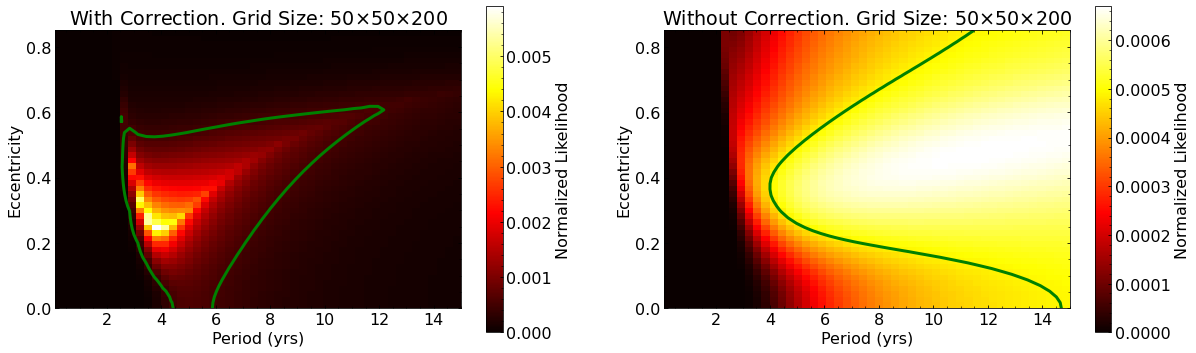

In [9]:
# for a grid size of periods=50, eccs=50, tps=50
# sanity comparison

# set the number of grid points for each parameter
p_num = [50]
ecc_num = [50]
tp_num = [200]

# set the range of period and eccentricity 
p_range = [0.1, 15]
ecc_range = [0, 0.85]

p_grid, ecc_grid, tp_grid = create_grid(p_num, ecc_num, tp_num, p_range, ecc_range)

# the likelihood marginalized over tp
like_ori_mrgnlzd_over_tp, like_mrgnlzd_over_tp = likelihood(tp_grid[0], p_grid[0], ecc_grid[0], t, coef_skeleton, snr, sigw)

# normalize the likelihood
normlz_like_ori = like_ori_mrgnlzd_over_tp/np.sum(like_ori_mrgnlzd_over_tp)
normlz_like = like_mrgnlzd_over_tp/np.sum(like_mrgnlzd_over_tp)

# find the 1-sigma contours
levels_ori = onesig(normlz_like_ori, p_grid[0], ecc_grid[0])
levels = onesig(normlz_like, p_grid[0], ecc_grid[0])

best_fit = np.where(normlz_like == normlz_like.max())
best_fit_ori = np.where(normlz_like_ori == normlz_like_ori.max())
print("The best-fit period with correction is {:.4f} years, while the best-fit value without correction is {:.4f} years.".format(p_grid[0][best_fit[0][0]], p_grid[0][best_fit_ori[0][0]]))
print("The best-fit eccentricity with correction is {:.4f}, while the best-fit value without correction is {:.4f}.".format(ecc_grid[0][best_fit[1][0]], ecc_grid[0][best_fit_ori[1][0]]))

x, y = np.meshgrid(p_grid[0], ecc_grid[0])
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
im1 = ax[0].imshow(normlz_like.T, origin='lower', cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], aspect=12) 
fig.colorbar(im1, ax=ax[0], orientation='vertical', label='Normalized Likelihood')
ax[0].contour(normlz_like.T, levels, colors='g', extent=[x.min(), x.max(), y.min(), y.max()])
ax[0].set_xlabel("Period (yrs)")
ax[0].set_ylabel("Eccentricity")
ax[0].set_title(r'With Correction. Grid Size: %d$\times$%d$\times$%d' %(p_num[0], ecc_num[0], tp_num[0]))

im2 = ax[1].imshow(normlz_like_ori.T, origin='lower', cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], aspect=12) 
fig.colorbar(im2, ax=ax[1], orientation='vertical', label='Normalized Likelihood')
ax[1].contour(normlz_like_ori.T, levels_ori, colors='g', extent=[x.min(), x.max(), y.min(), y.max()])
ax[1].set_xlabel("Period (yrs)")
ax[1].set_ylabel("Eccentricity")
ax[1].set_title(r'Without Correction. Grid Size: %d$\times$%d$\times$%d' %(p_num[0], ecc_num[0], tp_num[0]))

plt.savefig('prior_4.pdf')

<Figure size 432x288 with 0 Axes>

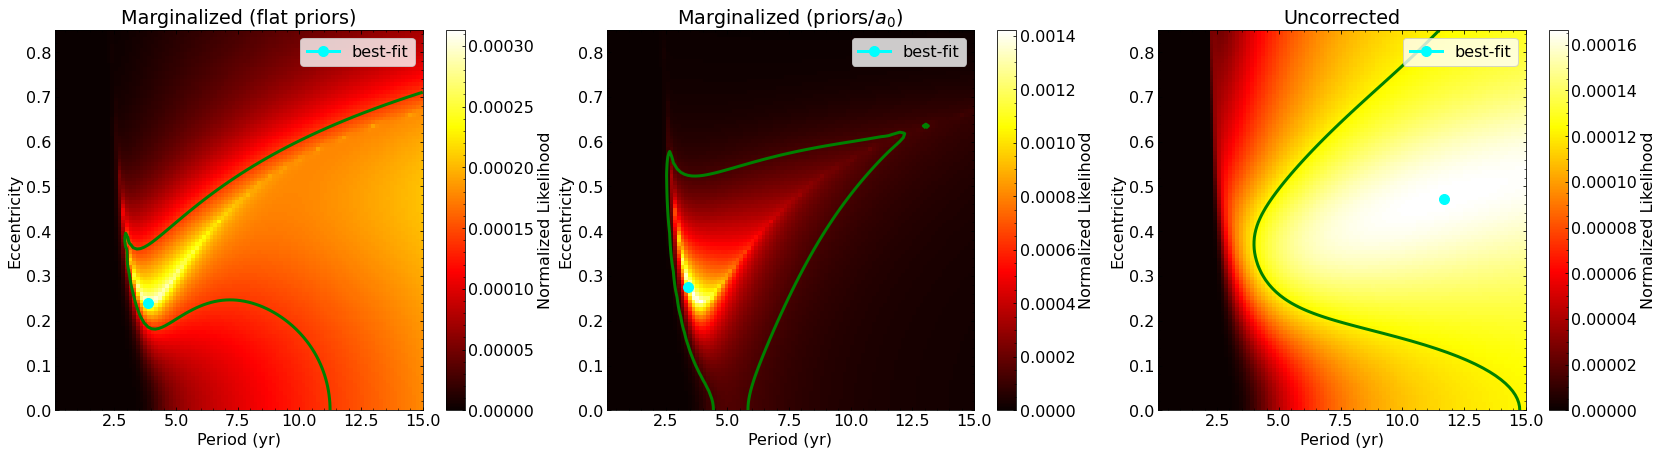

In [55]:
# general comparison
# set the number of grid points for each parameter
p_num = [100]
ecc_num = [100]
tp_num = [200]

# set the range of period and eccentricity 
p_range = [0.1, 15]
ecc_range = [0, 0.85]

p_grid, ecc_grid, tp_grid = create_grid(p_num, ecc_num, tp_num, p_range, ecc_range)

plt.clf()
x, y = np.meshgrid(p_grid[0], ecc_grid[0])
fig, axes = plt.subplots(1, 3, figsize=(28, 7))

# define the orbits
orbits = wobs
snr = orbits/sigw
    
# the likelihood marginalized over tp
like_ori_mrgnlzd_over_tp, like_mrgnlzd_over_tp_flat, like_mrgnlzd_over_tp_prop = likelihood(tp_grid[0], p_grid[0], ecc_grid[0], t, coef_skeleton, snr, sigw)
        
# normalize the likelihood
normlz_like_ori = like_ori_mrgnlzd_over_tp/np.sum(like_ori_mrgnlzd_over_tp)
normlz_like_flat = like_mrgnlzd_over_tp_flat/np.sum(like_mrgnlzd_over_tp_flat)
normlz_like_prop = like_mrgnlzd_over_tp_prop/np.sum(like_mrgnlzd_over_tp_prop)

levels_ori = onesig(normlz_like_ori, p_grid[0], ecc_grid[0])
levels_flat = onesig(normlz_like_flat, p_grid[0], ecc_grid[0])
levels_prop = onesig(normlz_like_prop, p_grid[0], ecc_grid[0])

best_fit_flat = np.where(normlz_like_flat == normlz_like_flat.max())
best_fit_prop = np.where(normlz_like_prop == normlz_like_prop.max())
best_fit_ori = np.where(normlz_like_ori == normlz_like_ori.max())
print('p_flat = ' + str(p_grid[0][best_fit_flat[0][0]]))
print('ecc_flat = ' + str(ecc_grid[0][best_fit_flat[1][0]]))
print('p_prop = ' + str(p_grid[0][best_fit_prop[0][0]]))
print('ecc_prop = ' + str(ecc_grid[0][best_fit_prop[1][0]]))
print('p_ori = ' + str(p_grid[0][best_fit_ori[0][0]]))
print('ecc_ori = ' + str(ecc_grid[0][best_fit_ori[1][0]]))
        
im1 = axes[0].imshow(normlz_like_flat.T, origin='lower', cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto') 
fig.colorbar(im1, ax=axes[0], orientation='vertical', label='Normalized Likelihood')
axes[0].plot(p_grid[0][best_fit_flat[0][0]], ecc_grid[0][best_fit_flat[1][0]], color='cyan', marker='o', markersize=10, label='best-fit')
axes[0].legend()
axes[0].contour(normlz_like_flat.T, levels_flat, colors='g', extent=[x.min(), x.max(), y.min(), y.max()])
axes[0].set_xlabel("Period (yr)")
axes[0].set_ylabel("Eccentricity")
axes[0].set_title("Marginalized (flat priors)" %SNR[i])

im2 = axes[1].imshow(normlz_like_prop.T, origin='lower', cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto') 
fig.colorbar(im2, ax=axes[1], orientation='vertical', label='Normalized Likelihood')
axes[1].plot(p_grid[0][best_fit_prop[0][0]], ecc_grid[0][best_fit_prop[1][0]], color='cyan', marker='o', markersize=10, label='best-fit')
axes[1].legend()
axes[1].contour(normlz_like_prop.T, levels_prop, colors='g', extent=[x.min(), x.max(), y.min(), y.max()])
axes[1].set_xlabel("Period (yr)")
axes[1].set_ylabel("Eccentricity")
axes[1].set_title(r"Marginalized (priors/$a_0$)" %SNR[i])
        
im3 = axes[2].imshow(normlz_like_ori.T, origin='lower', cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto') 
fig.colorbar(im3, ax=axes[2], orientation='vertical', label='Normalized Likelihood')
axes[2].plot(p_grid[0][best_fit_ori[0][0]], ecc_grid[0][best_fit_ori[1][0]], color='cyan', marker='o', markersize=10, label='best-fit')
axes[2].legend()
axes[2].contour(normlz_like_ori.T, levels_ori, colors='g', extent=[x.min(), x.max(), y.min(), y.max()])
axes[2].set_xlabel("Period (yr)")
axes[2].set_ylabel("Eccentricity")
axes[2].set_title("Uncorrected" %SNR[i])
           
plt.savefig('./plots/general_comp.pdf')

## Check the sensitivity of likelihood to tps

In [32]:
# set the number of grid points for each parameter
p_num = [100]
ecc_num = [100]
tp_num = [10, 50, 100, 200, 300, 400]

# set the range of period and eccentricity 
p_range = [0.1, 15]
ecc_range = [0, 0.99]

p_grid, ecc_grid, tp_grid = create_grid(p_num, ecc_num, tp_num, p_range, ecc_range)
    
like = []
levels = []
for i in range(len(tp_num)):
    like_sub = likelihood(tp_grid[i], p_grid[0], ecc_grid[0], t, coef_skeleton, snr, sigw)[1]
    normlz_like = like_sub/np.sum(like_sub)
    like.append(normlz_like)
    levels.append(onesig(normlz_like, p_grid[0], ecc_grid[0]))

The sigma likelihood contour is at value of [0.00018186]
The sigma likelihood contour is at value of [0.00014784]
The sigma likelihood contour is at value of [0.00014886]
The sigma likelihood contour is at value of [0.00014929]
The sigma likelihood contour is at value of [0.00014935]
The sigma likelihood contour is at value of [0.00014943]


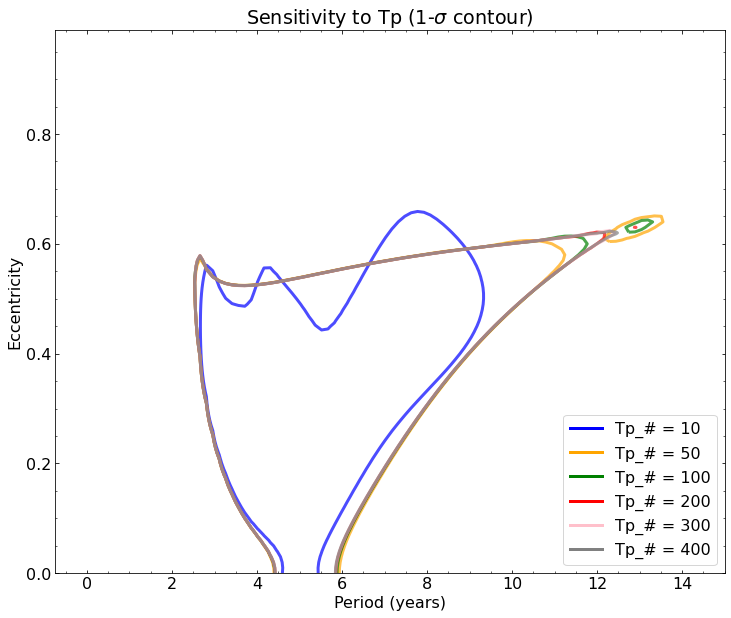

In [33]:
fig = plt.figure(figsize=(12, 10))
cls = ['blue', 'orange', 'green', 'red', 'pink', 'grey', 'brown', 'purple']
x, y = np.meshgrid(p_grid[0], ecc_grid[0])

for i in range(len(tp_num)):
    plt.plot(0, 0, color=cls[i], label='Tp_# = '+str(tp_num[i]))
    plt.legend(loc='lower right')
    plt.contour(like[i].T, levels[i], colors=cls[i], extent=[x.min(), x.max(), y.min(), y.max()], alpha=0.7)
plt.xlabel("Period (years)")
plt.ylabel("Eccentricity")
plt.title(r'Sensitivity to Tp (1-$\sigma$ contour)')
plt.savefig('sens_tps(100_100_x).pdf')

<Figure size 432x288 with 0 Axes>

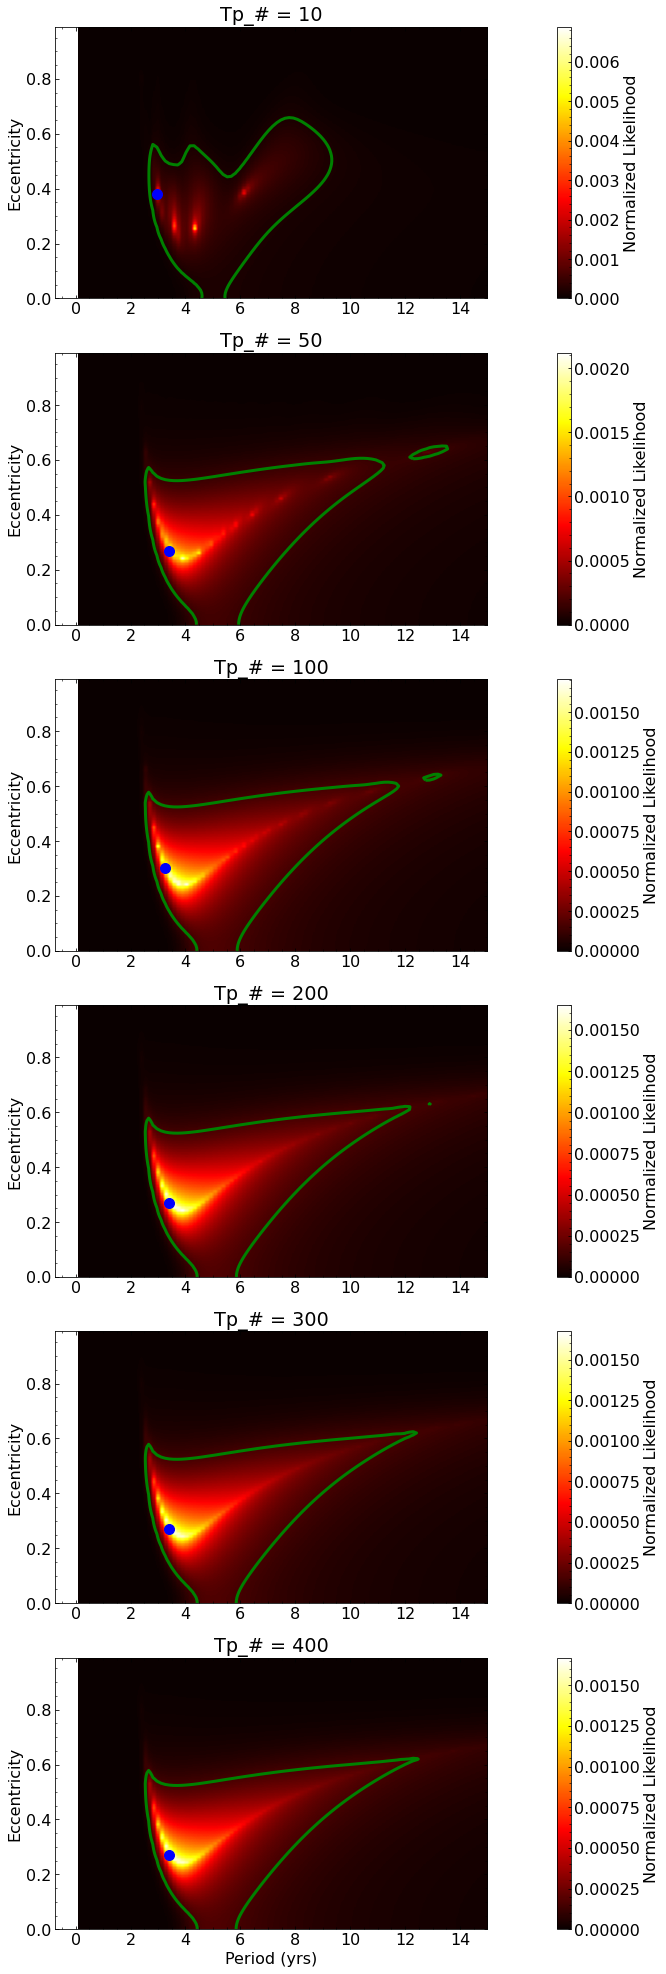

In [34]:
plt.clf()
fig, ax = plt.subplots(len(tp_num), 1, figsize=(25, 35))
for i in range(len(tp_num)):
    im = ax[i].imshow(like[i].T, origin='lower', cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], aspect=10) 
    fig.colorbar(im, ax=ax[i], orientation='vertical', label='Normalized Likelihood')
    ax[i].set_title(r'Tp_# = '+str(tp_num[i]))
    ax[i].plot(0, 0, color=cls[i])
    ax[i].contour(like[i].T, levels[i], colors='g', extent=[x.min(), x.max(), y.min(), y.max()])
    ax[i].plot(p_grid[0][np.where(like[i] == like[i].max())[0][0]], ecc_grid[0][np.where(like[i] == like[i].max())[1][0]], color='b', marker='o', markersize=10)
    ax[i].set_ylabel("Eccentricity")
ax[len(tp_num)-1].set_xlabel("Period (yrs)")
plt.savefig('like_sens_tps(100_100_x).pdf')

## Check the sensitivity of likelihood to period 

The sigma likelihood contour is at value of [0.00155437]
The sigma likelihood contour is at value of [0.00029788]
The sigma likelihood contour is at value of [0.00014886]
The sigma likelihood contour is at value of [7.43942127e-05]
The sigma likelihood contour is at value of [4.96516548e-05]
The sigma likelihood contour is at value of [3.71974293e-05]


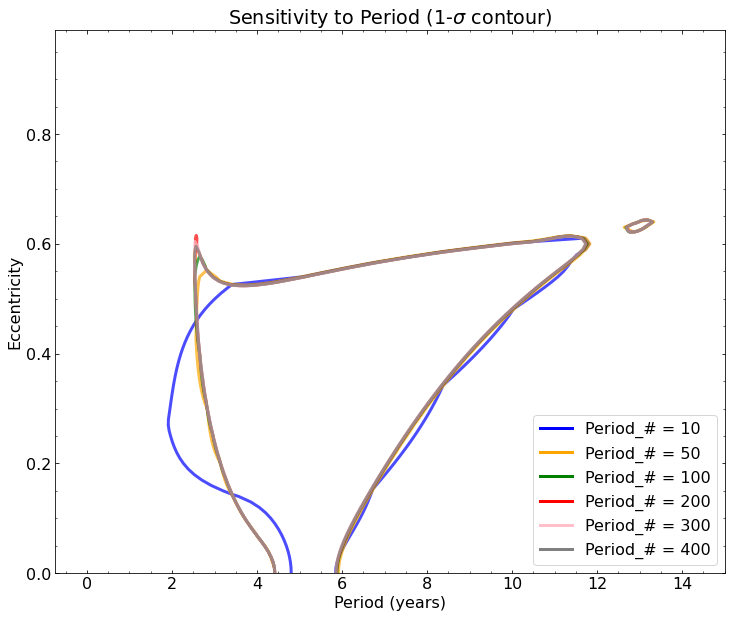

In [35]:
p_num = [10, 50, 100, 200, 300, 400]
ecc_num = [100]
tp_num = [100]

# set the range of period and eccentricity 
p_range = [0.1, 15]
ecc_range = [0, 0.99]

p_grid, ecc_grid, tp_grid = create_grid(p_num, ecc_num, tp_num, p_range, ecc_range)
    
like = []
levels = []
for i in range(len(p_num)):
    like_sub = likelihood(tp_grid[0], p_grid[i], ecc_grid[0], t, coef_skeleton, snr, sigw)[1]
    normlz_like = like_sub/np.sum(like_sub)
    like.append(normlz_like)
    levels.append(onesig(normlz_like, p_grid[i], ecc_grid[0]))
    
fig = plt.figure(figsize=(12, 10))
cls = ['blue', 'orange', 'green', 'red', 'pink', 'grey', 'brown', 'purple']

for i in range(len(p_num)):
    x, y = np.meshgrid(p_grid[i], ecc_grid[0])
    plt.plot(0, 0, color=cls[i], label='Period_# = '+str(p_num[i]))
    plt.legend(loc='lower right')
    plt.contour(like[i].T, levels[i], colors=cls[i], extent=[x.min(), x.max(), y.min(), y.max()], alpha=0.7)
plt.xlabel("Period (years)")
plt.ylabel("Eccentricity")
plt.title(r'Sensitivity to Period (1-$\sigma$ contour)')
plt.savefig('sens_p(x_100_100).pdf')

<Figure size 432x288 with 0 Axes>

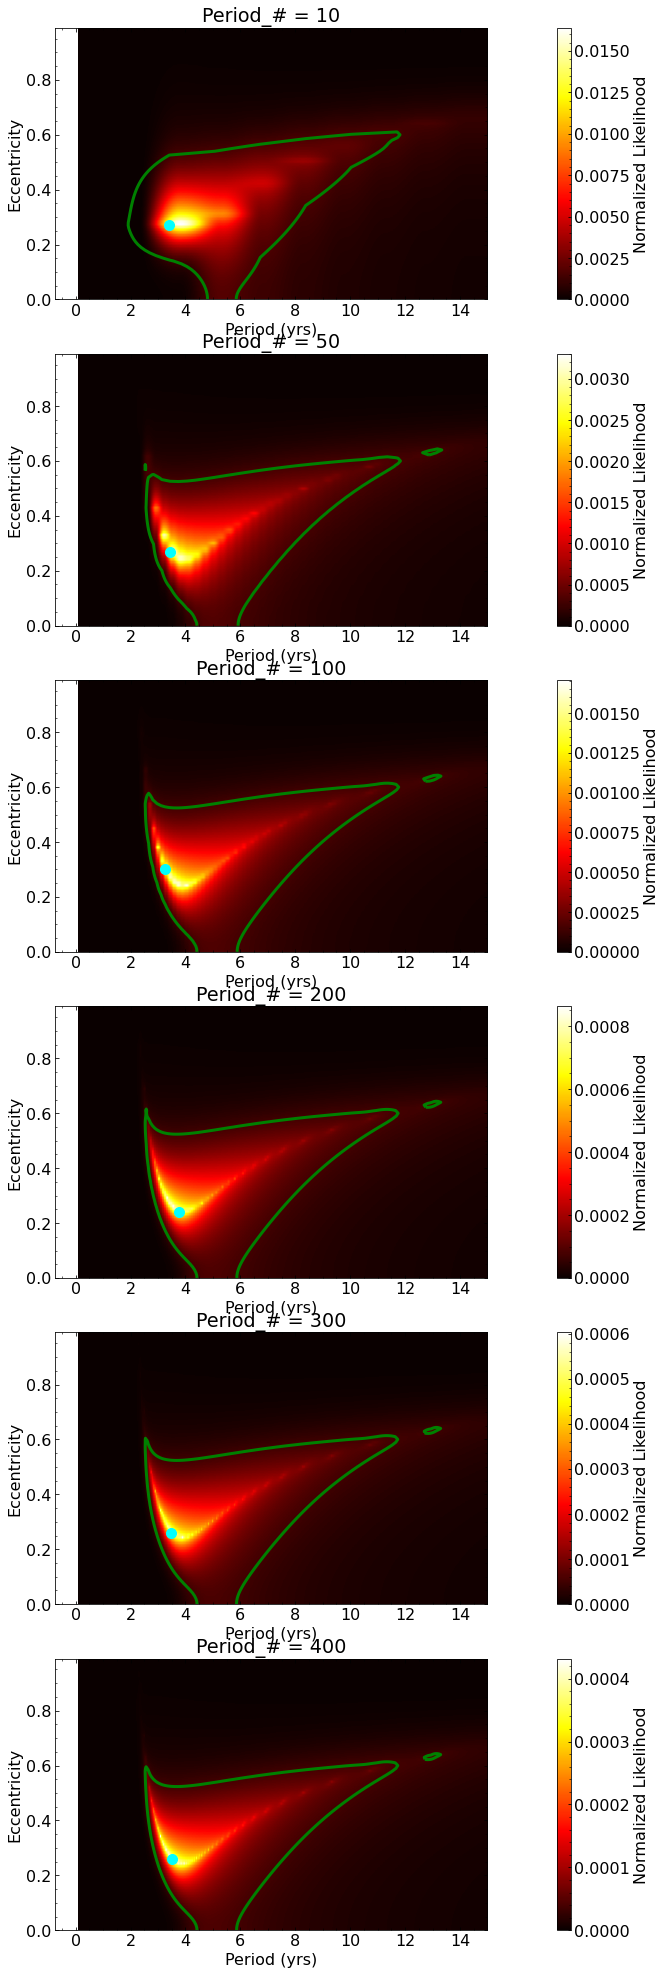

In [36]:
plt.clf()
fig, ax = plt.subplots(len(p_num), 1, figsize=(25, 35))
for i in range(len(p_num)):
    im = ax[i].imshow(like[i].T, origin='lower', cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], aspect=10) 
    fig.colorbar(im, ax=ax[i], orientation='vertical', label='Normalized Likelihood')
    ax[i].set_title(r'Period_# = '+str(p_num[i]))
    ax[i].plot(0, 0, color=cls[i])
    ax[i].contour(like[i].T, levels[i], colors='g', extent=[x.min(), x.max(), y.min(), y.max()])
    ax[i].plot(p_grid[i][np.where(like[i] == like[i].max())[0][0]], ecc_grid[0][np.where(like[i] == like[i].max())[1][0]], color='cyan', marker='o', markersize=10)
    ax[i].set_xlabel("Period (yrs)")
    ax[i].set_ylabel("Eccentricity")
plt.savefig('like_sens_p(x_100_100).pdf')

## Check the sensitivity of likelihood to eccentricity

The sigma likelihood contour is at value of [0.00152994]
The sigma likelihood contour is at value of [0.00029877]
The sigma likelihood contour is at value of [0.00014886]
The sigma likelihood contour is at value of [7.43219521e-05]
The sigma likelihood contour is at value of [4.95414933e-05]
The sigma likelihood contour is at value of [3.71554056e-05]


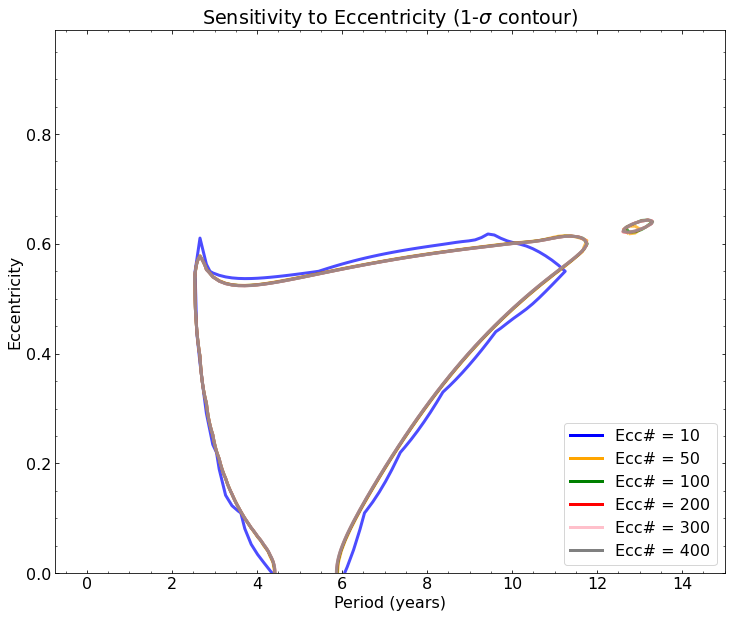

In [37]:
p_num = [100]
ecc_num = [10, 50, 100, 200, 300, 400]
tp_num = [100]

# set the range of period and eccentricity 
p_range = [0.1, 15]
ecc_range = [0, 0.99]

p_grid, ecc_grid, tp_grid = create_grid(p_num, ecc_num, tp_num, p_range, ecc_range)
    
like = []
levels = []
for i in range(len(ecc_num)):
    like_sub = likelihood(tp_grid[0], p_grid[0], ecc_grid[i], t, coef_skeleton, snr, sigw)[1]
    normlz_like = like_sub/np.sum(like_sub)
    like.append(normlz_like)
    levels.append(onesig(normlz_like, p_grid[0], ecc_grid[i]))
    
fig = plt.figure(figsize=(12, 10))
cls = ['blue', 'orange', 'green', 'red', 'pink', 'grey', 'brown', 'purple']

for i in range(len(ecc_num)):
    x, y = np.meshgrid(p_grid[0], ecc_grid[i])
    plt.plot(0, 0, color=cls[i], label='Ecc# = '+str(ecc_num[i]))
    plt.legend(loc='lower right')
    plt.contour(like[i].T, levels[i], colors=cls[i], extent=[x.min(), x.max(), y.min(), y.max()], alpha=0.7)
plt.xlabel("Period (years)")
plt.ylabel("Eccentricity")
plt.title(r'Sensitivity to Eccentricity (1-$\sigma$ contour)')
plt.savefig('sens_ecc(100_x_100).pdf')

<Figure size 432x288 with 0 Axes>

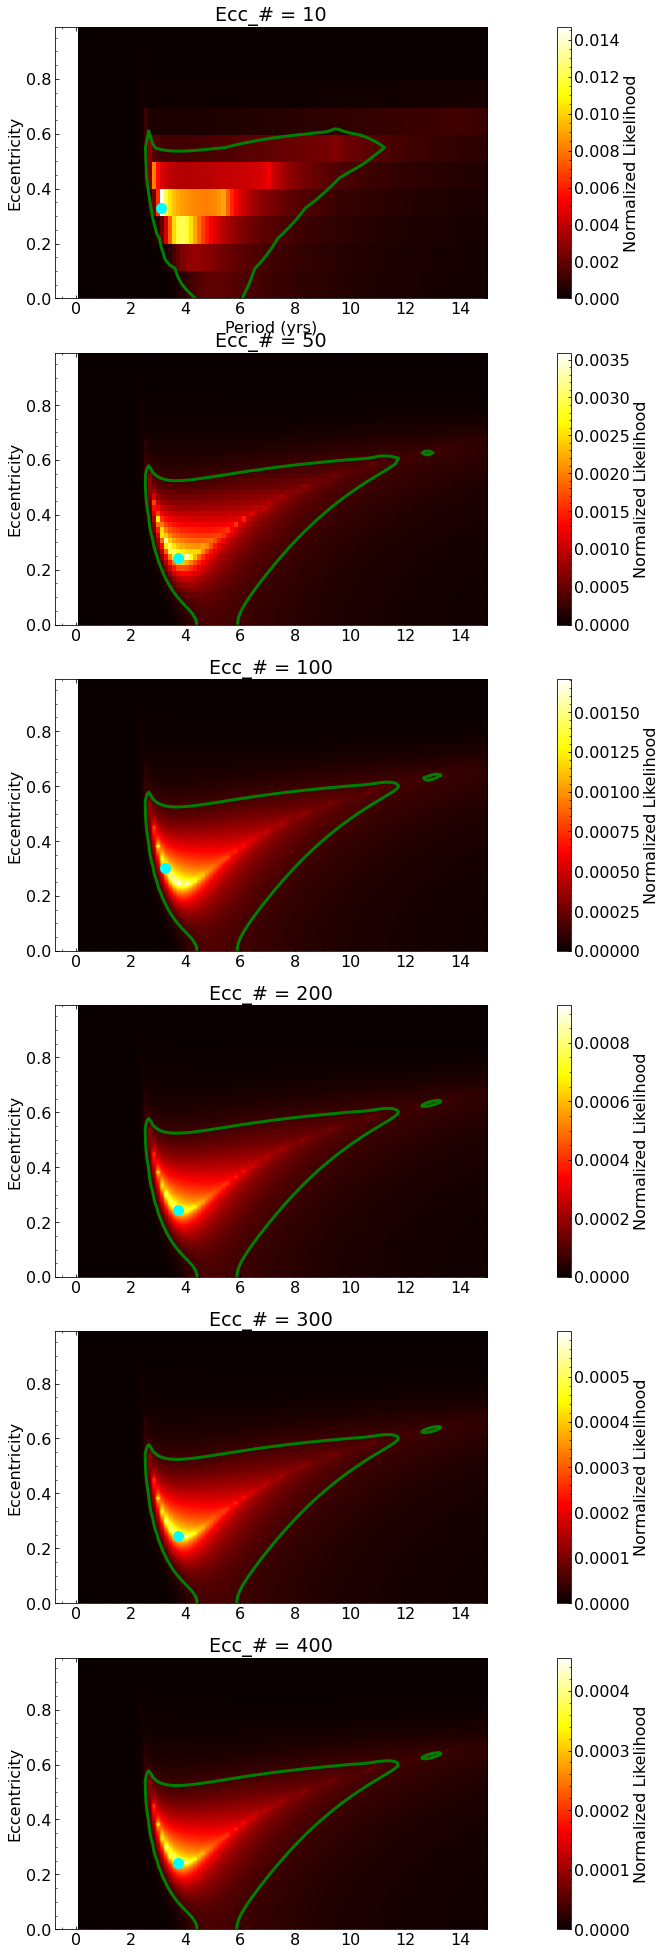

In [38]:
plt.clf()
fig, ax = plt.subplots(len(ecc_num), 1, figsize=(25, 35))
for i in range(len(ecc_num)):
    im = ax[i].imshow(like[i].T, origin='lower', cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], aspect=10) 
    fig.colorbar(im, ax=ax[i], orientation='vertical', label='Normalized Likelihood')
    ax[i].set_title(r'Ecc_# = '+str(ecc_num[i]))
    ax[i].plot(0, 0, color=cls[i])
    ax[i].contour(like[i].T, levels[i], colors='g', extent=[x.min(), x.max(), y.min(), y.max()])
    ax[i].plot(p_grid[0][np.where(like[i] == like[i].max())[0][0]], ecc_grid[i][np.where(like[i] == like[i].max())[1][0]], color='cyan', marker='o', markersize=10)
    ax[i].set_ylabel("Eccentricity")
ax[len(tp_num)-1].set_xlabel("Period (yrs)")
plt.savefig('like_sens_ecc(100_x_100).pdf')

## Sensitivity of smoothness to the number of T_0 grid points

In [56]:
# Fit a Gaussian distribution to the likelihood of tp 
def func(x, tp, sig, a, y0):  
    return (a * np.exp(-(x - tp)**2 / (2. * sig **2)) + y0)

## 100 tps

In [72]:
tp_num = [100]
tp_grid = []
for i in range(len(tp_num)):
    tps = np.linspace(0, 2*np.pi, tp_num[i])
    tp_grid.append(tps)

like1 = likelihood_pixel(tp_grid[0], [3.749], [0.2429], t, coef_skeleton, snr, sigw)[2]

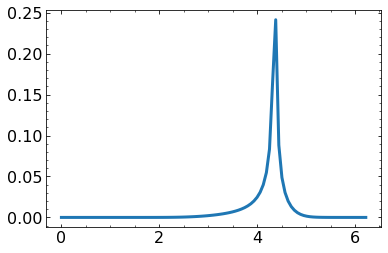

In [73]:
norm_like1 = like1/np.sum(like1)
plt.plot(tp_grid[0][0:-1], norm_like1[0][0][0:-1])

In [84]:
guess1 = np.array([4.35, 0.1, 0.25, 0]) # central tp, sigma, amplitude, base shift

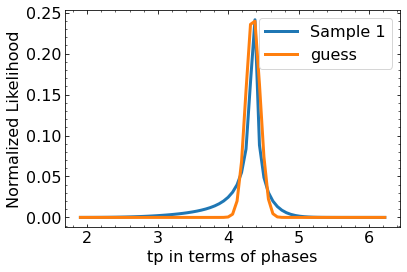

In [88]:
#Sanity check
plt.figure()
plt.tight_layout()
plt.xlabel("tp in terms of phases")
plt.ylabel("Normalized Likelihood")

yguess = func(tp_grid[0], guess1[0], guess1[1], guess1[2], guess1[3])
plt.plot(tp_grid[0][30:-1], norm_like1[0][0][30:-1], label='Sample 1')
plt.plot(tp_grid[0][30:-1], yguess[30:-1], label='guess')
plt.legend()

In [89]:
# Fit with SciPy
p, pcov = optimize.curve_fit(func, tp_grid[0][30:-1], norm_like1[0][0][30:-1], guess1)
perr = np.sqrt(np.diag(pcov))
print ('Fit Completed')

Fit Completed


In [93]:
# Calculate 'Goodness of Fit'
model = func(tp_grid[0],p[0],p[1],p[2],p[3])
term = ((norm_like1[0][0][30:-1]-model[30:-1])/perr[2])**2  
dof = norm_like1[0][0][30:-1].size - guess1.size
chi2 = np.sum(term) / dof
print(chi2)

1.4115297260736497


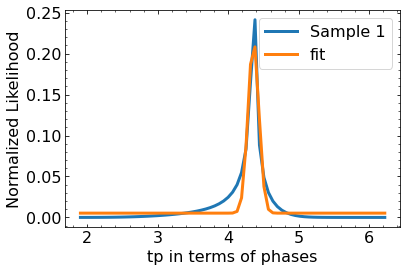

In [94]:
plt.figure()
plt.tight_layout()
plt.xlabel("tp in terms of phases")
plt.ylabel("Normalized Likelihood")

plt.plot(tp_grid[0][30:-1], norm_like1[0][0][30:-1], label='Sample 1')
plt.plot(tp_grid[0][30:-1], model[30:-1], label='fit')
plt.legend()

## 500 tps

In [123]:
tp_num = [500]
tp_grid = []
for i in range(len(tp_num)):
    tps = np.linspace(0, 2*np.pi, tp_num[i])
    tp_grid.append(tps)

like2 = likelihood_pixel(tp_grid[0], [3.749], [0.2429], t, coef_skeleton, snr, sigw)[2]

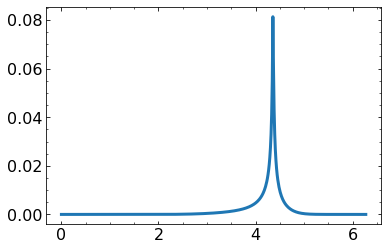

In [124]:
norm_like2 = like2/np.sum(like2)
plt.plot(tp_grid[0][0:-1], norm_like2[0][0][0:-1])

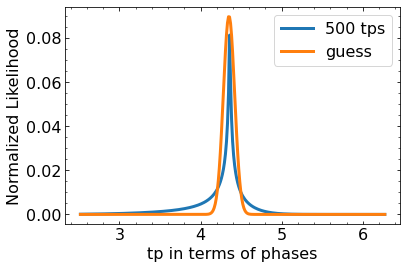

In [125]:
guess2 = np.array([4.35, 0.07, 0.09, 0]) # central tp, sigma, amplitude, base shift
#Sanity check
plt.figure()
plt.tight_layout()
plt.xlabel("tp in terms of phases")
plt.ylabel("Normalized Likelihood")

yguess = func(tp_grid[0], guess2[0], guess2[1], guess2[2], guess2[3])
plt.plot(tp_grid[0][200:-1], norm_like2[0][0][200:-1], label='500 tps')
plt.plot(tp_grid[0][200:-1], yguess[200:-1], label='guess')
plt.legend()

Fit Completed
5.129795635128299


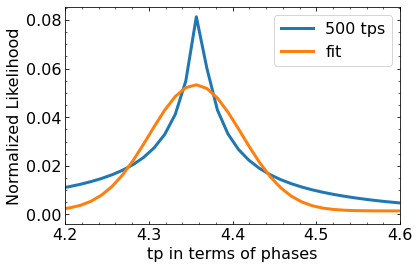

In [128]:
# Fit with SciPy
p, pcov = optimize.curve_fit(func, tp_grid[0][200:-1], norm_like2[0][0][200:-1], guess2)
perr = np.sqrt(np.diag(pcov))
print ('Fit Completed')
# Calculate 'Goodness of Fit'
model = func(tp_grid[0],p[0],p[1],p[2],p[3])
term = ((norm_like2[0][0][200:-1]-model[200:-1])/perr[2])**2  
dof = norm_like2[0][0][200:-1].size - guess2.size
chi2 = np.sum(term) / dof
print(chi2)
plt.figure()
plt.tight_layout()
plt.xlabel("tp in terms of phases")
plt.xlim(4.2, 4.6)
plt.ylabel("Normalized Likelihood")

plt.plot(tp_grid[0][200:-1], norm_like2[0][0][200:-1], label='500 tps')
plt.plot(tp_grid[0][200:-1], model[200:-1], label='fit')
plt.legend()

## 5000 tps

In [129]:
tp_num = [5000]
tp_grid = []
for i in range(len(tp_num)):
    tps = np.linspace(0, 2*np.pi, tp_num[i])
    tp_grid.append(tps)

like3 = likelihood_pixel(tp_grid[0], [3.749], [0.2429], t, coef_skeleton, snr, sigw)[2]

(4.3, 4.4)

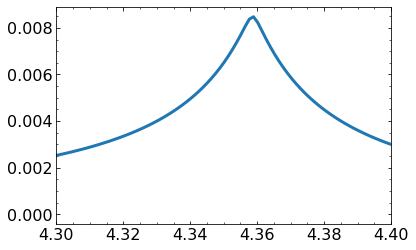

In [132]:
norm_like3 = like3/np.sum(like3)
plt.plot(tp_grid[0][0:-1], norm_like3[0][0][0:-1])
plt.xlim(4.3, 4.4)

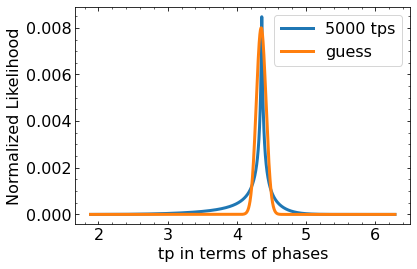

In [119]:
guess3 = np.array([4.35, 0.07, 0.008, 0]) # central tp, sigma, amplitude, base shift
#Sanity check
plt.figure()
plt.tight_layout()
plt.xlabel("tp in terms of phases")
plt.ylabel("Normalized Likelihood")

yguess = func(tp_grid[0], guess3[0], guess3[1], guess3[2], guess3[3])
plt.plot(tp_grid[0][1500:-1], norm_like3[0][0][1500:-1], label='5000 tps')
plt.plot(tp_grid[0][1500:-1], yguess[1500:-1], label='guess')
plt.legend()

Fit Completed
53.01738296915811


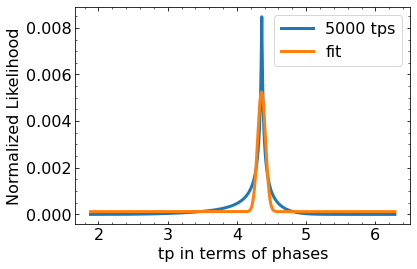

In [121]:
# Fit with SciPy
p, pcov = optimize.curve_fit(func, tp_grid[0][1500:-1], norm_like3[0][0][1500:-1], guess2)
perr = np.sqrt(np.diag(pcov))
print ('Fit Completed')
# Calculate 'Goodness of Fit'
model = func(tp_grid[0],p[0],p[1],p[2],p[3])
term = ((norm_like3[0][0][1500:-1]-model[1500:-1])/perr[2])**2  
dof = norm_like3[0][0][1500:-1].size - guess2.size
chi2 = np.sum(term) / dof
print(chi2)
plt.figure()
plt.tight_layout()
plt.xlabel("tp in terms of phases")
plt.ylabel("Normalized Likelihood")

plt.plot(tp_grid[0][1500:-1], norm_like3[0][0][1500:-1], label='5000 tps')
plt.plot(tp_grid[0][1500:-1], model[1500:-1], label='fit')
plt.legend()

## Fit fake orbits

The sigma likelihood contour is at value of [0.00061597]
The sigma likelihood contour is at value of [0.00064196]
The sigma likelihood contour is at value of [0.0005507]
The sigma likelihood contour is at value of [0.0006401]
The sigma likelihood contour is at value of [0.00073697]
The sigma likelihood contour is at value of [0.00065124]
The sigma likelihood contour is at value of [0.00067732]
The sigma likelihood contour is at value of [0.00080919]
The sigma likelihood contour is at value of [0.00094149]
The sigma likelihood contour is at value of [0.0007124]
The sigma likelihood contour is at value of [0.00091296]
The sigma likelihood contour is at value of [0.00151267]
The sigma likelihood contour is at value of [0.00038646]
The sigma likelihood contour is at value of [0.0006553]
The sigma likelihood contour is at value of [0.00048539]
The sigma likelihood contour is at value of [0.00041519]
The sigma likelihood contour is at value of [0.00067083]
The sigma likelihood contour is at 

<Figure size 432x288 with 0 Axes>

<Figure size 1800x2520 with 0 Axes>

<Figure size 1800x2520 with 0 Axes>

<Figure size 1800x2520 with 0 Axes>

<Figure size 1800x2520 with 0 Axes>

<Figure size 1800x2520 with 0 Axes>

<Figure size 1800x2520 with 0 Axes>

<Figure size 1800x2520 with 0 Axes>

<Figure size 1800x2520 with 0 Axes>

<Figure size 1800x2520 with 0 Axes>

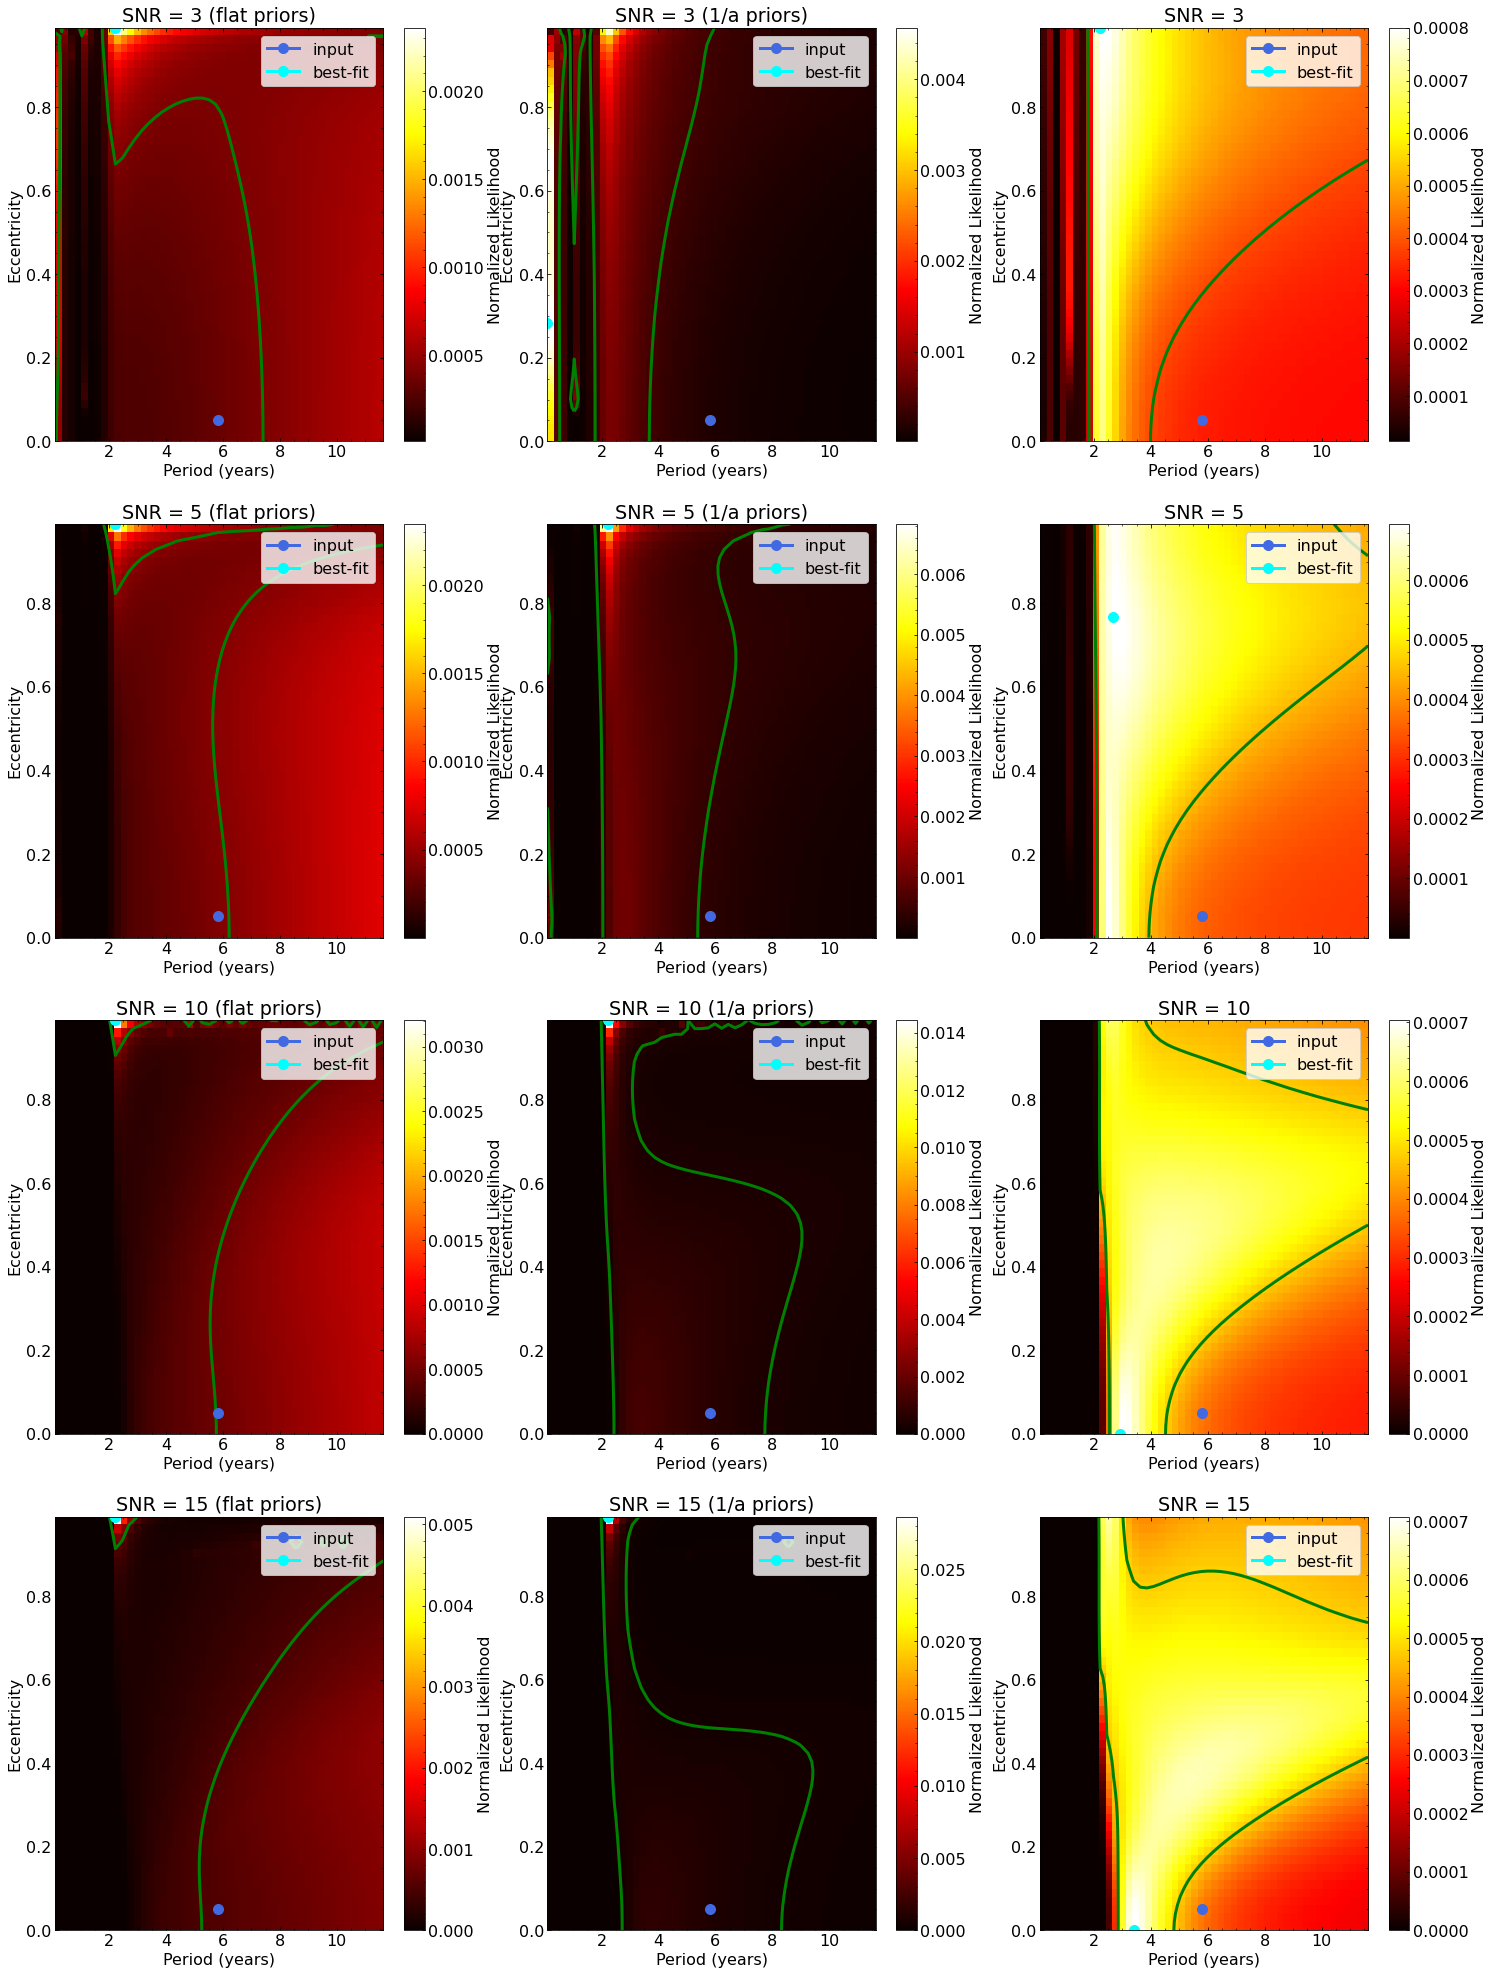

In [96]:
coef_skeleton= np.asarray([sintheta, costheta, t*sintheta, t*costheta, parfac, 
                          sintheta, sintheta, costheta, costheta])/sigw[np.newaxis, :]
for trial in range(10):
    # generate fake orbits
    om_input = np.random.rand()*2*np.pi
    Om_input = np.random.rand()*2*np.pi
    cosi_input = np.random.rand()

    # set SNR = 3, 5, 10, 15
    SNR = np.array([3, 5, 10, 15])
    noise = 5e-5
    a_input = noise*SNR

    # calculate Thiele-Innes elements
    A = a_input*(np.cos(Om_input)*np.cos(om_input) - np.sin(Om_input)*np.sin(om_input)*cosi_input)
    B = a_input*(np.sin(Om_input)*np.cos(om_input) + np.cos(Om_input)*np.sin(om_input)*cosi_input)
    F = a_input*(-np.cos(Om_input)*np.sin(om_input) - np.sin(Om_input)*np.cos(om_input)*cosi_input)
    G = a_input*(-np.sin(Om_input)*np.sin(om_input) + np.cos(Om_input)*np.cos(om_input)*cosi_input)

    per_input = np.random.rand()*round((t[-1]-t[0])*3, 2)
    ecc_input = np.random.rand()*0.9
    tp_input = np.random.rand()*2*np.pi
    X, Y = calc_XY(t, t.shape[0], tp_input, per_input, ecc_input)

    wobs_fake = []
    noise_seed = np.random.randn(len(t))*sigw
    for i in range(len(SNR)):
        wobs_fake_clean = B[i]*X*sintheta + G[i]*Y*sintheta + A[i]*X*costheta + F[i]*Y*costheta
        wobs_fake.append(wobs_fake_clean + noise_seed)
    # print(a_input)
    # print(round(Om_input, 4))
    # print(round(om_input, 4))
    # print(round(cosi_input, 4))
    df = pd.DataFrame(data=[[om_input, Om_input, cosi_input, per_input, ecc_input, tp_input]], index=['0', '1', '2', '3'], columns=['om_input','Om_input','cosi_input','per_input','ecc_input','tp_input'])
    df['SNR'] = SNR
    df['a_input'] = a_input

    # set the number of grid points for each parameter
    p_num = [50]
    ecc_num = [50]
    tp_num = [200]

    # set the range of period and eccentricity 
    p_range = [0.1, per_input*2]
    ecc_range = [0, 0.99]

    p_grid, ecc_grid, tp_grid = create_grid(p_num, ecc_num, tp_num, p_range, ecc_range)

    plt.clf()
    x, y = np.meshgrid(p_grid[0], ecc_grid[0])
    fig, axes = plt.subplots(len(SNR), 3, figsize=(25, 35))
    p_best_flat = []
    ecc_best_flat = []
    p_best_prop = []
    ecc_best_prop = []
    p_best_ori = []
    ecc_best_ori = []
#     p_mean = []
#     ecc_mean = []
#     p_mean_ori = []
#     ecc_mean_ori = []
    for i in range(len(SNR)):
        # define the orbits
        orbits = wobs_fake[i]
        snr = orbits/sigw
    
        # the likelihood marginalized over tp
        like_ori_mrgnlzd_over_tp, like_mrgnlzd_over_tp_flat, like_mrgnlzd_over_tp_prop = likelihood(tp_grid[0], p_grid[0], ecc_grid[0], t, coef_skeleton, snr, sigw)
        
        # normalize the likelihood
        normlz_like_ori = like_ori_mrgnlzd_over_tp/np.sum(like_ori_mrgnlzd_over_tp)
        normlz_like_flat = like_mrgnlzd_over_tp_flat/np.sum(like_mrgnlzd_over_tp_flat)
        normlz_like_prop = like_mrgnlzd_over_tp_prop/np.sum(like_mrgnlzd_over_tp_prop)

        levels_ori = onesig(normlz_like_ori, p_grid[0], ecc_grid[0])
        levels_flat = onesig(normlz_like_flat, p_grid[0], ecc_grid[0])
        levels_prop = onesig(normlz_like_prop, p_grid[0], ecc_grid[0])

        best_fit_flat = np.where(normlz_like_flat == normlz_like_flat.max())
        best_fit_prop = np.where(normlz_like_prop == normlz_like_prop.max())
        best_fit_ori = np.where(normlz_like_ori == normlz_like_ori.max())
#         print("The period used to generate the fake orbit is {:.4f} years. The best-fit period with correction is {:.4f} years, while the best-fit value without correction is {:.4f} years.".format(per_input, p_grid[0][best_fit_prop[0][0]], p_grid[0][best_fit_ori[0][0]]))
#         print("The eccentricity used to generate the fake orbit is {:.4f}. The best-fit eccentricity is {:.4f}, while the best-fit value without correction is {:.4f}.".format(ecc_input, ecc_grid[0][best_fit_prop[1][0]], ecc_grid[0][best_fit_ori[1][0]]))
        p_best_flat.append(p_grid[0][best_fit_flat[0][0]])
        ecc_best_flat.append(ecc_grid[0][best_fit_flat[1][0]])
        p_best_prop.append(p_grid[0][best_fit_prop[0][0]])
        ecc_best_prop.append(ecc_grid[0][best_fit_prop[1][0]])
        p_best_ori.append(p_grid[0][best_fit_ori[0][0]])
        ecc_best_ori.append(ecc_grid[0][best_fit_ori[1][0]])
        
        im1 = axes[i, 0].imshow(normlz_like_flat.T, origin='lower', cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto') 
        fig.colorbar(im1, ax=axes[i, 0], orientation='vertical', label='Normalized Likelihood')
        axes[i, 0].plot(per_input, ecc_input, color='royalblue', marker='o', markersize=10, label='input')
        axes[i, 0].plot(p_grid[0][best_fit_flat[0][0]], ecc_grid[0][best_fit_flat[1][0]], color='cyan', marker='o', markersize=10, label='best-fit')
        axes[i, 0].legend()
        axes[i, 0].contour(normlz_like_flat.T, levels_flat, colors='g', extent=[x.min(), x.max(), y.min(), y.max()])
        axes[i, 0].set_xlabel("Period (years)")
        axes[i, 0].set_ylabel("Eccentricity")
        axes[i, 0].set_title("SNR = %d (flat priors)" %SNR[i])

        im2 = axes[i, 1].imshow(normlz_like_prop.T, origin='lower', cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto') 
        fig.colorbar(im2, ax=axes[i, 1], orientation='vertical', label='Normalized Likelihood')
        axes[i, 1].plot(per_input, ecc_input, color='royalblue', marker='o', markersize=10, label='input')
        axes[i, 1].plot(p_grid[0][best_fit_prop[0][0]], ecc_grid[0][best_fit_prop[1][0]], color='cyan', marker='o', markersize=10, label='best-fit')
        axes[i, 1].legend()
        axes[i, 1].contour(normlz_like_prop.T, levels_prop, colors='g', extent=[x.min(), x.max(), y.min(), y.max()])
        axes[i, 1].set_xlabel("Period (years)")
        axes[i, 1].set_ylabel("Eccentricity")
        axes[i, 1].set_title("SNR = %d (1/a priors)" %SNR[i])
        
        im3 = axes[i, 2].imshow(normlz_like_ori.T, origin='lower', cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto') 
        fig.colorbar(im3, ax=axes[i, 2], orientation='vertical', label='Normalized Likelihood')
        axes[i, 2].plot(per_input, ecc_input, color='royalblue', marker='o', markersize=10, label='input')
        axes[i, 2].plot(p_grid[0][best_fit_ori[0][0]], ecc_grid[0][best_fit_ori[1][0]], color='cyan', marker='o', markersize=10, label='best-fit')
        axes[i, 2].legend()
        axes[i, 2].contour(normlz_like_ori.T, levels_ori, colors='g', extent=[x.min(), x.max(), y.min(), y.max()])
        axes[i, 2].set_xlabel("Period (years)")
        axes[i, 2].set_ylabel("Eccentricity")
        axes[i, 2].set_title("SNR = %d" %SNR[i])
    
        # calculate the mean values of period and eccentricity
#         p_mean.append(np.sum(normlz_like, axis=1)@p_grid[0]/np.sum(normlz_like))
#         ecc_mean.append(np.sum(normlz_like, axis=0)@ecc_grid[0]/np.sum(normlz_like))
#         p_mean_ori.append(np.sum(normlz_like_ori, axis=1)@p_grid[0]/np.sum(normlz_like_ori))
#         ecc_mean_ori.append(np.sum(normlz_like_ori, axis=0)@ecc_grid[0]/np.sum(normlz_like_ori))
        
    df['p_best_flat'] = p_best_flat
    df['ecc_best_flat'] = ecc_best_flat
    df['p_best_prop'] = p_best_prop
    df['ecc_best_prop'] = ecc_best_prop
    df['p_best_ori'] = p_best_ori
    df['ecc_best_ori'] = ecc_best_ori
#     df['p_mean'] = p_mean
#     df['ecc_mean'] = ecc_mean
#     df['p_mean_ori'] = p_mean_ori
#     df['ecc_mean_ori'] = ecc_mean_ori
    
    df.to_csv('./plots/fake_orbits/v1298T/fake1.2_'+str(trial+1)+'.csv', index=False)
    plt.savefig('./plots/fake_orbits/v1298T/fake1.2_'+str(trial+1)+'.pdf')

The 1-sigma likelihood contour is at value of [0.00314805]
The 1-sigma likelihood contour is at value of [0.00601746]
The 1-sigma likelihood contour is at value of [0.00634449]
The 1-sigma likelihood contour is at value of [0.00048277]
The 1-sigma likelihood contour is at value of [0.00064842]
The 1-sigma likelihood contour is at value of [0.00061184]
The 1-sigma likelihood contour is at value of [0.00050884]
The 1-sigma likelihood contour is at value of [0.00058394]
The 1-sigma likelihood contour is at value of [0.00050988]
The 1-sigma likelihood contour is at value of [0.0004766]
The 1-sigma likelihood contour is at value of [0.00052708]
The 1-sigma likelihood contour is at value of [0.00044069]
The 1-sigma likelihood contour is at value of [0.00043989]
The 1-sigma likelihood contour is at value of [0.00049733]
The 1-sigma likelihood contour is at value of [0.0004316]
The 1-sigma likelihood contour is at value of [0.00044847]
The 1-sigma likelihood contour is at value of [0.00047168]

<Figure size 432x288 with 0 Axes>

<Figure size 1800x5400 with 0 Axes>

<Figure size 1800x5400 with 0 Axes>

<Figure size 1800x5400 with 0 Axes>

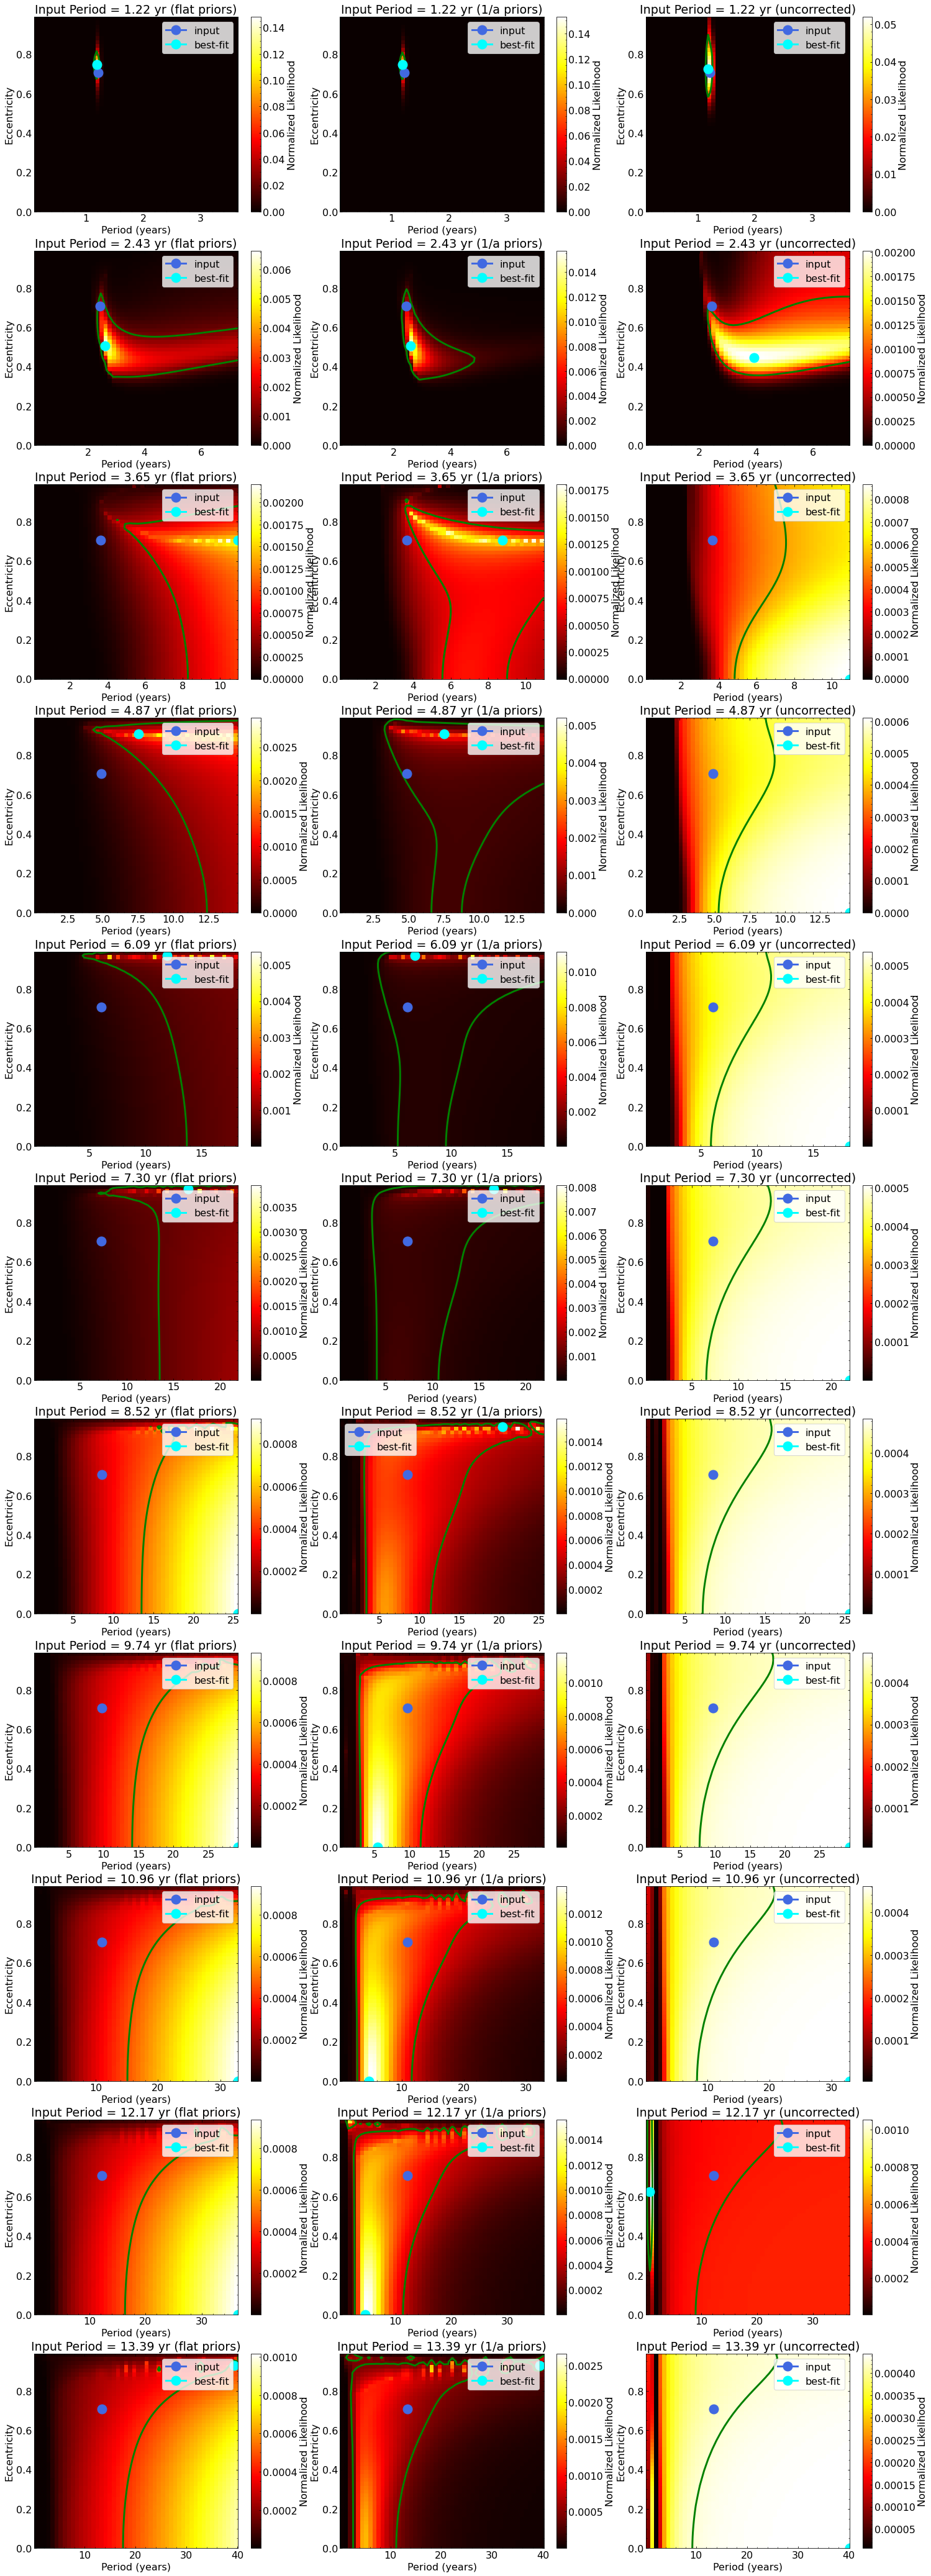

In [77]:
# vary the input period as obs_base * factor at different SNR levels 
# to check the strengths of the two approaches under the approximation of Gaussian
multi_factor = np.arange(0.5, 6, 0.5)
per_input = (t[-1]-t[0])*multi_factor
# generate random seeds for the other parameters in advance
SNR = np.array([3, 5, 10, 15]) # set SNR = 3, 5, 10, 15
noise = 5e-5
a_input = noise*SNR
om_input = np.random.rand()*2*np.pi
Om_input = np.random.rand()*2*np.pi
cosi_input = np.random.rand()

ecc_input = np.random.rand()*0.9
tp_input = np.random.rand()*2*np.pi

noise_seed = np.random.randn(len(t))*sigw
coef_skeleton= np.asarray([sintheta, costheta, t*sintheta, t*costheta, parfac, 
                          sintheta, sintheta, costheta, costheta])/sigw[np.newaxis, :]

# set the number of grid points for each parameter
p_num = [50]
ecc_num = [50]
tp_num = [200]
    

for j in range(len(SNR)):
    # calculate Thiele-Innes elements
    A = a_input[j]*(np.cos(Om_input)*np.cos(om_input) - np.sin(Om_input)*np.sin(om_input)*cosi_input)
    B = a_input[j]*(np.sin(Om_input)*np.cos(om_input) + np.cos(Om_input)*np.sin(om_input)*cosi_input)
    F = a_input[j]*(-np.cos(Om_input)*np.sin(om_input) - np.sin(Om_input)*np.cos(om_input)*cosi_input)
    G = a_input[j]*(-np.sin(Om_input)*np.sin(om_input) + np.cos(Om_input)*np.cos(om_input)*cosi_input)
    
    df = pd.DataFrame()
    
    plt.clf()
    fig, axes = plt.subplots(len(multi_factor), 3, figsize=(25, 75))
    
    
    for i in range(len(multi_factor)):
        per = round(per_input[i], 4)
        X, Y = calc_XY(t, t.shape[0], tp_input, per, ecc_input)
        wobs_fake = B*X*sintheta + G*Y*sintheta + A*X*costheta + F*Y*costheta + noise_seed
    
        # set the range of period and eccentricity 
        p_range = [0.1, per*3]
        ecc_range = [0, 0.99]

        p_grid, ecc_grid, tp_grid = create_grid(p_num, ecc_num, tp_num, p_range, ecc_range)
        x, y = np.meshgrid(p_grid[0], ecc_grid[0])
    
         # define the orbits
        orbits = wobs_fake
        snr = orbits/sigw
    
    
        # the likelihood marginalized over tp
        like_ori_mrgnlzd_over_tp, like_mrgnlzd_over_tp_flat, like_mrgnlzd_over_tp_prop = likelihood(tp_grid[0], p_grid[0], ecc_grid[0], t, coef_skeleton, snr, sigw)
        
        # normalize the likelihood
        normlz_like_ori = like_ori_mrgnlzd_over_tp/np.sum(like_ori_mrgnlzd_over_tp)
        normlz_like_flat = like_mrgnlzd_over_tp_flat/np.sum(like_mrgnlzd_over_tp_flat)
        normlz_like_prop = like_mrgnlzd_over_tp_prop/np.sum(like_mrgnlzd_over_tp_prop)

        levels_ori = onesig(normlz_like_ori, p_grid[0], ecc_grid[0])
        levels_flat = onesig(normlz_like_flat, p_grid[0], ecc_grid[0])
        levels_prop = onesig(normlz_like_prop, p_grid[0], ecc_grid[0])

        best_fit_flat = np.where(normlz_like_flat == normlz_like_flat.max())
        best_fit_prop = np.where(normlz_like_prop == normlz_like_prop.max())
        best_fit_ori = np.where(normlz_like_ori == normlz_like_ori.max())
        
        df = df.append({'SNR':SNR[j],'a_input':a_input[j],'om_input':om_input,'Om_input':Om_input,'cosi_input':cosi_input,'per_input':per, 
                        'ecc_input':ecc_input,'tp_input':tp_input,'p_best_flat':p_grid[0][best_fit_flat[0][0]],'ecc_best_flat':ecc_grid[0][best_fit_flat[1][0]],
                        'p_best_prop':p_grid[0][best_fit_prop[0][0]],'ecc_best_prop':ecc_grid[0][best_fit_prop[1][0]],'p_best_ori':p_grid[0][best_fit_ori[0][0]],
                        'ecc_best_ori':ecc_grid[0][best_fit_ori[1][0]]}
                        , ignore_index = True)

        
        im1 = axes[i, 0].imshow(normlz_like_flat.T, origin='lower', cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto') 
        fig.colorbar(im1, ax=axes[i, 0], orientation='vertical', label='Normalized Likelihood')
        axes[i, 0].plot(per, ecc_input, color='royalblue', marker='o', markersize=15, label='input')
        axes[i, 0].plot(p_grid[0][best_fit_flat[0][0]], ecc_grid[0][best_fit_flat[1][0]], color='cyan', marker='o', markersize=15, label='best-fit')
        axes[i, 0].legend()
        axes[i, 0].contour(normlz_like_flat.T, levels_flat, colors='g', extent=[x.min(), x.max(), y.min(), y.max()])
        axes[i, 0].set_xlabel("Period (years)")
        axes[i, 0].set_ylabel("Eccentricity")
        axes[i, 0].set_title("Input Period = %.2f yr (flat priors)" %per)

        im2 = axes[i, 1].imshow(normlz_like_prop.T, origin='lower', cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto') 
        fig.colorbar(im2, ax=axes[i, 1], orientation='vertical', label='Normalized Likelihood')
        axes[i, 1].plot(per, ecc_input, color='royalblue', marker='o', markersize=15, label='input')
        axes[i, 1].plot(p_grid[0][best_fit_prop[0][0]], ecc_grid[0][best_fit_prop[1][0]], color='cyan', marker='o', markersize=15, label='best-fit')
        axes[i, 1].legend()
        axes[i, 1].contour(normlz_like_prop.T, levels_prop, colors='g', extent=[x.min(), x.max(), y.min(), y.max()])
        axes[i, 1].set_xlabel("Period (years)")
        axes[i, 1].set_ylabel("Eccentricity")
        axes[i, 1].set_title("Input Period = %.2f yr (1/a priors)" %per)
        
        im3 = axes[i, 2].imshow(normlz_like_ori.T, origin='lower', cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto') 
        fig.colorbar(im3, ax=axes[i, 2], orientation='vertical', label='Normalized Likelihood')
        axes[i, 2].plot(per, ecc_input, color='royalblue', marker='o', markersize=15, label='input')
        axes[i, 2].plot(p_grid[0][best_fit_ori[0][0]], ecc_grid[0][best_fit_ori[1][0]], color='cyan', marker='o', markersize=15, label='best-fit')
        axes[i, 2].legend()
        axes[i, 2].contour(normlz_like_ori.T, levels_ori, colors='g', extent=[x.min(), x.max(), y.min(), y.max()])
        axes[i, 2].set_xlabel("Period (years)")
        axes[i, 2].set_ylabel("Eccentricity")
        axes[i, 2].set_title("Input Period = %.2f yr (uncorrected)" %per)
    

        
    df.to_csv('./plots/fake_orbits/v1298T/fake1.3_'+str(SNR[j])+'.csv', index=False)
    plt.savefig('./plots/fake_orbits/v1298T/fake1.3_'+str(SNR[j])+'.pdf')

In [13]:
# check if the 2-sigma and 3-sigma contours can encompass all input points

# vary the input period as obs_base * factor at different SNR levels 
# to check the strengths of the two approaches under the approximation of Gaussian
SNR = np.array([3, 5, 10, 15]) # set SNR = 3, 5, 10, 15
multi_factor = np.arange(0.5, 6, 0.5)
per_input = (t[-1]-t[0])*multi_factor

coef_skeleton= np.asarray([sintheta, costheta, t*sintheta, t*costheta, parfac, 
                          sintheta, sintheta, costheta, costheta])/sigw[np.newaxis, :]
coef_ske5p = np.asarray([sintheta, costheta, t*sintheta, t*costheta, parfac])/sigw[np.newaxis, :]

# generate random seeds for the fixed parameters in advance
om_input = np.random.rand()*2*np.pi
Om_input = np.random.rand()*2*np.pi
cosi_input = np.random.rand()

ecc_input = np.random.rand()*0.9
tp_input = np.random.rand()*2*np.pi

noise_seed = np.random.randn(len(t))*sigw

# create an array containing various semi-major axes used to estimate the effective SNR 
a_input_test = np.arange(1e-5, 5e-3, 2e-5)

-3.1721529860442956
2.297513692740374
11.26867752439987
23.741338508934177
39.71549664634329
59.19115193662719
82.16830437978601
108.64695397581946
138.62710072472788
172.10874462651097
209.091885681169
249.5765238887019
293.5626592491095
341.050291762392
392.0394214285492
446.53004824758125
504.5221722194883
566.0157933442699
631.0109116219262
699.5075270524578
771.5056396358634
847.005249372145
926.0063562613008
1008.5089603033306
1094.5130614982363
1184.0186598460164
1277.025755346672
1373.5343480002011
1473.5444378066054
1577.0560247658852
1684.0691088780395
1794.583690143069
1908.5997685609732
2026.1173441317524
2147.136416855405
2271.6569867319336
2399.679053761336
2531.202617943615
2666.227679278767
2804.754237766795
2946.7822934076967
3092.3118462014745
3241.3428961481272
3393.875443247652
3549.9094875000555
3709.4450289053316
3872.4820674634834
4039.0206031745083
4209.06063603841
4382.602166055184
4559.645193224836
4740.189717547362
4924.235739022763
5111.783257651035
5302.832

The 1-sigma likelihood contour is at value of 0.0004296036851530328
The 2-sigma likelihood contour is at value of 0.0003760243936774485
The 3-sigma likelihood contour is at value of 1.9616732786210004e-05
The 1-sigma likelihood contour is at value of 0.00037224022156340914
The 2-sigma likelihood contour is at value of 0.00021956084941767624
The 3-sigma likelihood contour is at value of 1.968907428324437e-05
The 1-sigma likelihood contour is at value of 0.0006631899413163624
The 2-sigma likelihood contour is at value of 9.991985602622665e-05
The 3-sigma likelihood contour is at value of 2.2799112664217765e-05
-5.484910869444533
-5.802503045223638
-4.914390557033514
-2.820573404874189
0.4789484112543576
4.984174891352126
10.695106035419116
17.61174184345534
25.734082315460768
35.06212745143543
45.59587725137927
57.33533171529237
70.2804908431747
84.43135463502628
99.78792309084704
116.35019621063694
134.11817399439616
153.09185644212457
173.2712435538222
194.656335329489
217.247131769125

The 1-sigma likelihood contour is at value of 0.0004674379535851519
The 2-sigma likelihood contour is at value of 0.0003506081672797909
The 3-sigma likelihood contour is at value of 0.00011241421748643474
The 1-sigma likelihood contour is at value of 0.00044952979593262574
The 2-sigma likelihood contour is at value of 0.00027100055315892803
The 3-sigma likelihood contour is at value of 4.151589046838334e-05
The 1-sigma likelihood contour is at value of 0.00048427313437788617
The 2-sigma likelihood contour is at value of 0.00012925762271215587
The 3-sigma likelihood contour is at value of 4.326692252168682e-05
-5.079250767706739
-5.576853252796106
-5.80808005293197
-5.7729311681143685
-5.471406598343272
-4.90350634361868
-4.069230403940615
-2.968578779309013
-1.6015514697239368
0.031851524814619836
1.9316302043066926
4.097784568752253
6.53031461815128
9.229220352503802
12.19450177180984
15.426158876069323
18.9241916652823
22.688600139448845
26.71938429856882
31.01654414264229
35.5800796

1178.8996819644203
1197.0044001117078
1215.2464020316243
1233.6256877241685
1252.14225718934
1270.7961104271408
1289.5872474375697
1308.515668220626
1327.5813727763107
1346.784361104624
1366.124633205565
1385.6021890791344
1405.217028725332
1424.9691521441573
1444.8585593356115
1464.8852502996926
1485.0492250364025
1505.350483545741
1525.789025827708
1546.3648518823024
1567.0779617095245
1587.9283553093758
1608.9160326818546
1630.0409938269627
1651.3032387446985
1672.7027674350616
1694.2395798980522
1715.9136761336722
1737.7250561419214
1759.673719922797
1781.7596674763022
1803.9828988024335
1826.3434139011943
1848.8412127725835
1871.476295416601
1894.2486618332446
1917.158312022518
1940.2052459844208
1963.3894637189496
1986.7109652261083
2010.1697505058926
2033.7658195583078
2057.499172383349
2081.3698089810205
2105.377729351318
2129.522933494245
2153.8054214098
2178.2251930979814
2202.782248558793
2227.4765877922327
2252.308210798302
2277.2771175769976
2302.38330812832
2327.626782452

The 1-sigma likelihood contour is at value of 0.00043922134017237334
The 2-sigma likelihood contour is at value of 0.000343138935158061
The 3-sigma likelihood contour is at value of 0.0001749706591999136
The 1-sigma likelihood contour is at value of 0.00045490402792963696
The 2-sigma likelihood contour is at value of 0.00018032733775267997
The 3-sigma likelihood contour is at value of 7.146626305768488e-05
The 1-sigma likelihood contour is at value of 0.00045217187433027324
The 2-sigma likelihood contour is at value of 0.00012325129177431047
The 3-sigma likelihood contour is at value of 4.203879881857795e-05
-4.8220290239640775
-5.069476218601075
-5.288090085365958
-5.477870624258777
-5.638817835279454
-5.770931718428017
-5.874212273704515
-5.948659501108899
-5.99427340064117
-6.011053972301362
-5.999001216089425
-5.958115132005382
-5.88839572004926
-5.789842980221003
-5.662456912520646
-5.506237516948239
-5.321184793503669
-5.107298742186998
-4.864579362998235
-4.593026655937379
-4.29

393.26874401986277
397.1823648281078
401.11507056610424
405.0668612338543
409.03773683135637
413.0276973586116
417.03674281561945
421.0648732023815
425.11208851889535
429.1783887651619
433.2637739411807
437.3682440469533
441.4917990824773
445.6344390477557
449.7961639427852
453.9769737675689
458.17686852210477
462.39584820639385
466.63391282043597
470.89106236422964
475.16729683777703
479.46261624107666
483.77702057412904
488.1105098369359
492.46308402949364
496.8347431518045
501.22548720386817
505.63531618568436
510.06423009725484
514.5122289385762
518.9793127096513
523.4654814104794
527.9707350410597
532.4950736013926
The 1-sigma likelihood contour is at value of 0.00043294038761979
The 2-sigma likelihood contour is at value of 0.0003463024507415046
The 3-sigma likelihood contour is at value of 0.0001310577251958487
The 1-sigma likelihood contour is at value of 0.0004576055777110124
The 2-sigma likelihood contour is at value of 0.00017926242136983664
The 3-sigma likelihood contour is

The 1-sigma likelihood contour is at value of 0.002789639330811977
The 2-sigma likelihood contour is at value of 0.0007745869887603239
The 3-sigma likelihood contour is at value of 7.230435304917881e-06
The 1-sigma likelihood contour is at value of 0.0032134171114205235
The 2-sigma likelihood contour is at value of 0.0009088596773943113
The 3-sigma likelihood contour is at value of 6.894565453343935e-06
The 1-sigma likelihood contour is at value of 0.0033099887606535083
The 2-sigma likelihood contour is at value of 0.0008320185594681641
The 3-sigma likelihood contour is at value of 6.723582357689847e-06
-5.70578069103253
-5.254732729456229
-2.3569881054816477
2.9874531808912437
10.778591129662395
21.01642574083182
33.700957014399556
48.83218495036552
66.41010954872982
86.43473080949238
108.9060487326532
133.82406331821238
161.18877456616974
191.00018247652554
223.2582870492795
257.9630882844317
295.11458618198213
334.71278074193094
376.7576719642781
421.2492598490234
468.187544396167
5

The 1-sigma likelihood contour is at value of 0.000500384391672836
The 2-sigma likelihood contour is at value of 0.00037486673257356107
The 3-sigma likelihood contour is at value of 8.062634508540837e-05
The 1-sigma likelihood contour is at value of 0.0004519107293599222
The 2-sigma likelihood contour is at value of 0.00037024679225388117
The 3-sigma likelihood contour is at value of 8.981697973752571e-05
The 1-sigma likelihood contour is at value of 0.000564163076655229
The 2-sigma likelihood contour is at value of 0.00013332091173079322
The 3-sigma likelihood contour is at value of 5.7194621961847315e-05
-5.243078115580445
-5.754254331288976
-5.709202239938975
-5.107921841530441
-3.950413136063382
-2.236676123537798
0.033289196046290215
2.859482822688946
6.241904756390163
10.180554997149834
14.67543354496808
19.726540399844858
25.33387556178012
31.49743903077399
38.21723080682631
45.49325088993719
53.325499280106605
61.71397597733454
70.658680981621
80.15961429296605
90.2167759113695

The 1-sigma likelihood contour is at value of 0.0004635192951209066
The 2-sigma likelihood contour is at value of 0.00031933783545941237
The 3-sigma likelihood contour is at value of 0.00011443539645164095
The 1-sigma likelihood contour is at value of 0.0004702541620754081
The 2-sigma likelihood contour is at value of 0.0002154808690831004
The 3-sigma likelihood contour is at value of 7.648733668249163e-05
The 1-sigma likelihood contour is at value of 0.00045040990805134557
The 2-sigma likelihood contour is at value of 0.00014624418540283086
The 3-sigma likelihood contour is at value of 7.192734908665954e-05
-4.972235192941056
-5.400826350454551
-5.692133735339851
-5.846157347597035
-5.862897187226082
-5.742353254226906
-5.484525548599635
-5.089414070344155
-4.557018819460559
-3.887339795948769
-3.0803769998088697
-2.1361304310407547
-1.0546000896445236
0.16421402437985932
1.5203119110324437
3.013693570313137
4.644359002222004
6.41230820675905
8.317541183924234
10.36005793371757
12.539

The 1-sigma likelihood contour is at value of 0.00044848884829796256
The 2-sigma likelihood contour is at value of 0.00032543484467301403
The 3-sigma likelihood contour is at value of 0.000145715269837972
The 1-sigma likelihood contour is at value of 0.00047866853603405765
The 2-sigma likelihood contour is at value of 0.00018374779289138485
The 3-sigma likelihood contour is at value of 6.772605207416762e-05
The 1-sigma likelihood contour is at value of 0.0004581460763114497
The 2-sigma likelihood contour is at value of 0.00012740952928062187
The 3-sigma likelihood contour is at value of 5.8931310994118785e-05
-4.854641803713463
-5.150885942123267
-5.4014861322530905
-5.606442374102933
-5.765754667672802
-5.879423012962704
-5.947447409972632
-5.969827858702537
-5.946564359152518
-5.877656911322497
-5.763105515212487
-5.602910170822547
-5.397070878152583
-5.145587637202624
-4.848460447972734
-4.50568931046287
-4.1172742246729825
-3.68321519060315
-3.2035122082533434
-2.678165277623556
-2

The 1-sigma likelihood contour is at value of 0.000440667876453176
The 2-sigma likelihood contour is at value of 0.0003304279508805905
The 3-sigma likelihood contour is at value of 0.0001589495510259094
The 1-sigma likelihood contour is at value of 0.0004775729956117976
The 2-sigma likelihood contour is at value of 0.00017834279629047167
The 3-sigma likelihood contour is at value of 4.968495241890823e-05
The 1-sigma likelihood contour is at value of 0.00047844920901530174
The 2-sigma likelihood contour is at value of 0.0001163296649369832
The 3-sigma likelihood contour is at value of 5.2875935522633574e-05
-4.79893687467456
-5.007660893031407
-5.19729998163551
-5.367854140486806
-5.519323369585308
-5.6517076689310315
-5.76500703852399
-5.859221478364134
-5.93435098845152
-5.990395568786127
-6.027355219367934
-6.045229940196954
-6.044019731273217
-6.023724592596665
-5.984344524167334
-5.925879525985245
-5.84832959805037
-5.751694740362709
-5.635974952922247
-5.501170235729013
-5.3472805

The 1-sigma likelihood contour is at value of 0.0004351772485473812
The 2-sigma likelihood contour is at value of 0.00033633147703538785
The 3-sigma likelihood contour is at value of 0.0001282506438684212
The 1-sigma likelihood contour is at value of 0.00047424251545146763
The 2-sigma likelihood contour is at value of 0.00017936435454457748
The 3-sigma likelihood contour is at value of 4.438893854038401e-05
The 1-sigma likelihood contour is at value of 0.0004939721240895281
The 2-sigma likelihood contour is at value of 0.00010770885172054765
The 3-sigma likelihood contour is at value of 4.6440363812377545e-05
-3.1721529860442956
2.297513692740374
11.26867752439987
23.741338508934177
39.71549664634329
59.19115193662719
82.16830437978601
108.64695397581946
138.62710072472788
172.10874462651097
209.091885681169
249.5765238887019
293.5626592491095
341.050291762392
392.0394214285492
446.53004824758125
504.5221722194883
566.0157933442699
631.0109116219262
699.5075270524578
771.5056396358634


The 1-sigma likelihood contour is at value of 0.0008005315478956305
The 2-sigma likelihood contour is at value of 0.0002567478691904558
The 3-sigma likelihood contour is at value of 1.5085717363742389e-05
The 1-sigma likelihood contour is at value of 0.0009998337921637188
The 2-sigma likelihood contour is at value of 0.00021443666567415992
The 3-sigma likelihood contour is at value of 1.8088751520237338e-05
The 1-sigma likelihood contour is at value of 0.0013186284798019602
The 2-sigma likelihood contour is at value of 0.00017970759013702478
The 3-sigma likelihood contour is at value of 2.0493502387092463e-05
-5.484910869444533
-5.802503045223638
-4.914390557033514
-2.820573404874189
0.4789484112543576
4.984174891352126
10.695106035419116
17.61174184345534
25.734082315460768
35.06212745143543
45.59587725137927
57.33533171529237
70.2804908431747
84.43135463502628
99.78792309084704
116.35019621063694
134.11817399439616
153.09185644212457
173.2712435538222
194.656335329489
217.24713176912

The 1-sigma likelihood contour is at value of 0.0004951063436996662
The 2-sigma likelihood contour is at value of 0.0002853389188893788
The 3-sigma likelihood contour is at value of 0.0001029397940657769
The 1-sigma likelihood contour is at value of 0.0005445274615085792
The 2-sigma likelihood contour is at value of 0.0001955940670434243
The 3-sigma likelihood contour is at value of 6.877121045482715e-05
The 1-sigma likelihood contour is at value of 0.0005426879959328357
The 2-sigma likelihood contour is at value of 0.00012402657862729536
The 3-sigma likelihood contour is at value of 6.357605652390999e-05
-5.079250767706739
-5.576853252796106
-5.80808005293197
-5.7729311681143685
-5.471406598343272
-4.90350634361868
-4.069230403940615
-2.968578779309013
-1.6015514697239368
0.031851524814619836
1.9316302043066926
4.097784568752253
6.53031461815128
9.229220352503802
12.19450177180984
15.426158876069323
18.9241916652823
22.688600139448845
26.71938429856882
31.01654414264229
35.58007967166

The 1-sigma likelihood contour is at value of 0.0004611369727794617
The 2-sigma likelihood contour is at value of 0.00029724241900616204
The 3-sigma likelihood contour is at value of 9.895141505213767e-05
The 1-sigma likelihood contour is at value of 0.0005252457307154674
The 2-sigma likelihood contour is at value of 0.0001806870977412323
The 3-sigma likelihood contour is at value of 5.5154871040370305e-05
The 1-sigma likelihood contour is at value of 0.0005387774180498418
The 2-sigma likelihood contour is at value of 0.00012720513914922293
The 3-sigma likelihood contour is at value of 2.8472518457579024e-05
-4.901901332072704
-5.258895842987478
-5.53940121148819
-5.743417437574848
-5.870944521247459
-5.921982462505987
-5.896531261350489
-5.794590917780937
-5.616161431797316
-5.361242803399648
-5.029835032587961
-4.62193811936217
-4.137552063722367
-3.576676865668489
-2.9393125252005348
-2.2254590423185405
-1.4351164170225061
-0.5682846493124174
0.3750362608117541
1.394846313349909
2.4

1319.6596597898056
1330.6831148248286
The 1-sigma likelihood contour is at value of 0.00044869787204387517
The 2-sigma likelihood contour is at value of 0.00030191259427983546
The 3-sigma likelihood contour is at value of 0.0001056498236024091
The 1-sigma likelihood contour is at value of 0.0005091985764181269
The 2-sigma likelihood contour is at value of 0.00017902129384181223
The 3-sigma likelihood contour is at value of 4.180218545702145e-05
The 1-sigma likelihood contour is at value of 0.0005383565361227342
The 2-sigma likelihood contour is at value of 0.00012531751795418847
The 3-sigma likelihood contour is at value of 2.8307554348796462e-05
-4.8220290239640775
-5.069476218601075
-5.288090085365958
-5.477870624258777
-5.638817835279454
-5.770931718428017
-5.874212273704515
-5.948659501108899
-5.99427340064117
-6.011053972301362
-5.999001216089425
-5.958115132005382
-5.88839572004926
-5.789842980221003
-5.662456912520646
-5.506237516948239
-5.321184793503669
-5.107298742186998
-4.8

The 1-sigma likelihood contour is at value of 0.00044146815615646903
The 2-sigma likelihood contour is at value of 0.0003076410595010298
The 3-sigma likelihood contour is at value of 0.00010590863863866615
The 1-sigma likelihood contour is at value of 0.0005002111510188786
The 2-sigma likelihood contour is at value of 0.00017719755356259009
The 3-sigma likelihood contour is at value of 4.063472379020245e-05
The 1-sigma likelihood contour is at value of 0.0005501726501874142
The 2-sigma likelihood contour is at value of 0.00012032173351010249
The 3-sigma likelihood contour is at value of 2.6175619544850646e-05
-4.7822061363490675
-4.9601069857393085
-5.124879243004457
-5.2765229081445
-5.415037981159465
-5.540424462049309
-5.652682350814047
-5.751811647453728
-5.837812351968282
-5.910684464357729
-5.9704279846220984
-6.017042912761333
-6.050529248775483
-6.070886992664541
-6.078116144428478
-6.072216704067323
-6.05318867158109
-6.021032046969758
-5.975746830233284
-5.917333021371732
-5.

The 1-sigma likelihood contour is at value of 0.019050401100573225
The 2-sigma likelihood contour is at value of 0.000949255549572068
The 3-sigma likelihood contour is at value of 0.00012751486716355514
The 1-sigma likelihood contour is at value of 0.019292352867714354
The 2-sigma likelihood contour is at value of 0.0008802603234109487
The 3-sigma likelihood contour is at value of 0.00012631885806096675
The 1-sigma likelihood contour is at value of 0.019466313081835253
The 2-sigma likelihood contour is at value of 0.001045965799410012
The 3-sigma likelihood contour is at value of 0.00013446612872764424
-5.70578069103253
-5.254732729456229
-2.3569881054816477
2.9874531808912437
10.778591129662395
21.01642574083182
33.700957014399556
48.83218495036552
66.41010954872982
86.43473080949238
108.9060487326532
133.82406331821238
161.18877456616974
191.00018247652554
223.2582870492795
257.9630882844317
295.11458618198213
334.71278074193094
376.7576719642781
421.2492598490234
468.187544396167
51

The 1-sigma likelihood contour is at value of 0.0005761850835415544
The 2-sigma likelihood contour is at value of 0.0001799274131153843
The 3-sigma likelihood contour is at value of 4.3439335186081055e-05
The 1-sigma likelihood contour is at value of 0.0007577868273958567
The 2-sigma likelihood contour is at value of 0.00012052313546036715
The 3-sigma likelihood contour is at value of 3.5843109167064876e-05
The 1-sigma likelihood contour is at value of 0.0008409099289951587
The 2-sigma likelihood contour is at value of 0.00015353698674936713
The 3-sigma likelihood contour is at value of 1.6225692295577843e-05
-5.243078115580445
-5.754254331288976
-5.709202239938975
-5.107921841530441
-3.950413136063382
-2.236676123537798
0.033289196046290215
2.859482822688946
6.241904756390163
10.180554997149834
14.67543354496808
19.726540399844858
25.33387556178012
31.49743903077399
38.21723080682631
45.49325088993719
53.325499280106605
61.71397597733454
70.658680981621
80.15961429296605
90.2167759113

The 1-sigma likelihood contour is at value of 0.00047572680412241486
The 2-sigma likelihood contour is at value of 0.00027996725691833746
The 3-sigma likelihood contour is at value of 0.00010490714251608735
The 1-sigma likelihood contour is at value of 0.0005745567180969256
The 2-sigma likelihood contour is at value of 0.00017568555935380445
The 3-sigma likelihood contour is at value of 5.1387377657187574e-05
The 1-sigma likelihood contour is at value of 0.0005903935216411867
The 2-sigma likelihood contour is at value of 0.0001251816287241657
The 3-sigma likelihood contour is at value of 2.4158345240312248e-05
-4.972235192941056
-5.400826350454551
-5.692133735339851
-5.846157347597035
-5.862897187226082
-5.742353254226906
-5.484525548599635
-5.089414070344155
-4.557018819460559
-3.887339795948769
-3.0803769998088697
-2.1361304310407547
-1.0546000896445236
0.16421402437985932
1.5203119110324437
3.013693570313137
4.644359002222004
6.41230820675905
8.317541183924234
10.36005793371757
12.5

2212.277755630397
2230.7370901533395
2249.2729138186937
2267.8852266264657
The 1-sigma likelihood contour is at value of 0.00045848589139875593
The 2-sigma likelihood contour is at value of 0.0002934651596536773
The 3-sigma likelihood contour is at value of 0.00010601039268124113
The 1-sigma likelihood contour is at value of 0.0005367377142939043
The 2-sigma likelihood contour is at value of 0.00017736730371143358
The 3-sigma likelihood contour is at value of 4.118290878499307e-05
The 1-sigma likelihood contour is at value of 0.0005705571476453935
The 2-sigma likelihood contour is at value of 0.0001290222313719398
The 3-sigma likelihood contour is at value of 2.3661745895333694e-05
-4.854641803713463
-5.150885942123267
-5.4014861322530905
-5.606442374102933
-5.765754667672802
-5.879423012962704
-5.947447409972632
-5.969827858702537
-5.946564359152518
-5.877656911322497
-5.763105515212487
-5.602910170822547
-5.397070878152583
-5.145587637202624
-4.848460447972734
-4.50568931046287
-4.11

The 1-sigma likelihood contour is at value of 0.00044720087602756036
The 2-sigma likelihood contour is at value of 0.00029837069396681376
The 3-sigma likelihood contour is at value of 0.00011651305671528735
The 1-sigma likelihood contour is at value of 0.0005198033437970057
The 2-sigma likelihood contour is at value of 0.00017609566941283864
The 3-sigma likelihood contour is at value of 3.9496810692850154e-05
The 1-sigma likelihood contour is at value of 0.0005601941404225558
The 2-sigma likelihood contour is at value of 0.00012752272639419268
The 3-sigma likelihood contour is at value of 2.3886086563842315e-05
-4.79893687467456
-5.007660893031407
-5.19729998163551
-5.367854140486806
-5.519323369585308
-5.6517076689310315
-5.76500703852399
-5.859221478364134
-5.93435098845152
-5.990395568786127
-6.027355219367934
-6.045229940196954
-6.044019731273217
-6.023724592596665
-5.984344524167334
-5.925879525985245
-5.84832959805037
-5.751694740362709
-5.635974952922247
-5.501170235729013
-5.34

The 1-sigma likelihood contour is at value of 0.00044087223396178124
The 2-sigma likelihood contour is at value of 0.00030451084259597934
The 3-sigma likelihood contour is at value of 9.503846890039898e-05
The 1-sigma likelihood contour is at value of 0.0005049114815649161
The 2-sigma likelihood contour is at value of 0.00017572407533308456
The 3-sigma likelihood contour is at value of 3.9971478772136534e-05
The 1-sigma likelihood contour is at value of 0.0005611865058606348
The 2-sigma likelihood contour is at value of 0.00012447975736810853
The 3-sigma likelihood contour is at value of 2.4196385400186015e-05


<Figure size 432x288 with 0 Axes>

<Figure size 1800x5400 with 0 Axes>

<Figure size 1800x5400 with 0 Axes>

<Figure size 1800x5400 with 0 Axes>

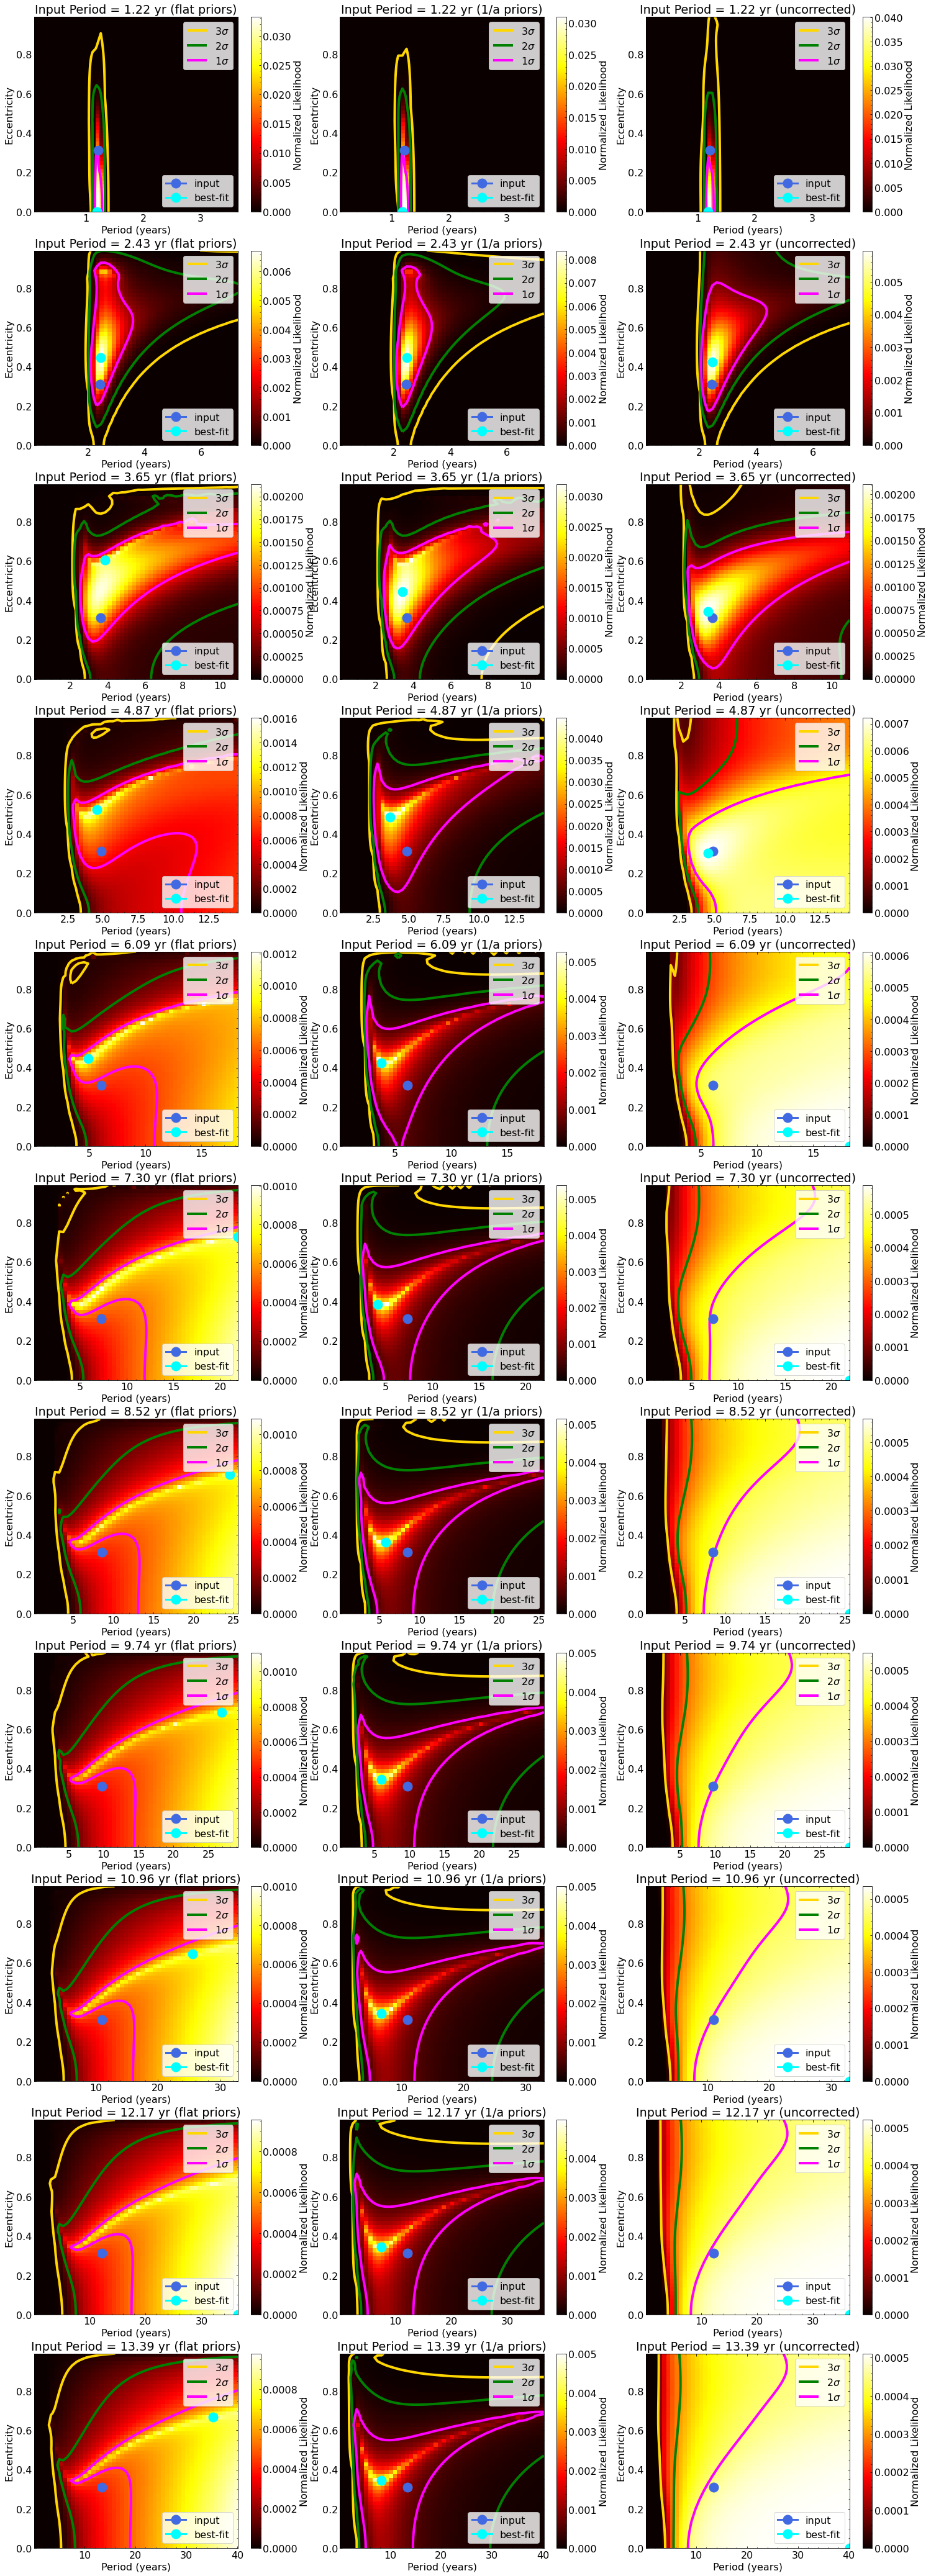

In [68]:
# set the number of grid points for each parameter
p_num = [50]
ecc_num = [50]
tp_num = [200]
    

for j in range(len(SNR)):
    df = pd.DataFrame()
    
    plt.clf()
    fig, axes = plt.subplots(len(multi_factor), 3, figsize=(25, 75))
    
    
    for i in range(len(multi_factor)): 
        per = per_input[i]
        # compute the interpolated function of the semi-major axis in terms of SNR and input period
        eff_a = modified_a(a_input_test, per, om_input, Om_input, cosi_input, tp_input, ecc_input, noise_seed, t, coef_skeleton, coef_ske5p, sigw)
        # calculate Thiele-Innes elements
        a_input = eff_a(SNR[j])
        A = a_input*(np.cos(Om_input)*np.cos(om_input) - np.sin(Om_input)*np.sin(om_input)*cosi_input)
        B = a_input*(np.sin(Om_input)*np.cos(om_input) + np.cos(Om_input)*np.sin(om_input)*cosi_input)
        F = a_input*(-np.cos(Om_input)*np.sin(om_input) - np.sin(Om_input)*np.cos(om_input)*cosi_input)
        G = a_input*(-np.sin(Om_input)*np.sin(om_input) + np.cos(Om_input)*np.cos(om_input)*cosi_input)
        per = round(per_input[i], 4)
        X, Y = calc_XY(t, t.shape[0], tp_input, per, ecc_input)
        wobs_fake = B*X*sintheta + G*Y*sintheta + A*X*costheta + F*Y*costheta + noise_seed
    
        # set the range of period and eccentricity 
        p_range = [0.1, per*3]
        ecc_range = [0, 0.99]

        p_grid, ecc_grid, tp_grid = create_grid(p_num, ecc_num, tp_num, p_range, ecc_range)
        x, y = np.meshgrid(p_grid[0], ecc_grid[0])
    
         # define the orbits
        orbits = wobs_fake
        snr = orbits/sigw # normalized 1D measurements
    
    
        # the likelihood marginalized over tp
        like_ori_mrgnlzd_over_tp, like_mrgnlzd_over_tp_flat, like_mrgnlzd_over_tp_prop = likelihood(tp_grid[0], p_grid[0], ecc_grid[0], t, coef_skeleton, snr, sigw)
        
        # normalize the likelihood
        normlz_like_ori = like_ori_mrgnlzd_over_tp/np.sum(like_ori_mrgnlzd_over_tp)
        normlz_like_flat = like_mrgnlzd_over_tp_flat/np.sum(like_mrgnlzd_over_tp_flat)
        normlz_like_prop = like_mrgnlzd_over_tp_prop/np.sum(like_mrgnlzd_over_tp_prop)
        
        # calculate the thresholds of confidence intervals
        levels_ori = confint(normlz_like_ori, p_grid[0], ecc_grid[0])
        levels_flat = confint(normlz_like_flat, p_grid[0], ecc_grid[0])
        levels_prop = confint(normlz_like_prop, p_grid[0], ecc_grid[0])
        
        best_fit_flat = np.where(normlz_like_flat == normlz_like_flat.max())
        best_fit_prop = np.where(normlz_like_prop == normlz_like_prop.max())
        best_fit_ori = np.where(normlz_like_ori == normlz_like_ori.max())
        
        df = df.append({'SNR':SNR[j],'a_input':a_input,'om_input':om_input,'Om_input':Om_input,'cosi_input':cosi_input,'per_input':per, 
                        'ecc_input':ecc_input,'tp_input':tp_input,'p_best_flat':p_grid[0][best_fit_flat[0][0]],'ecc_best_flat':ecc_grid[0][best_fit_flat[1][0]],
                        'p_best_prop':p_grid[0][best_fit_prop[0][0]],'ecc_best_prop':ecc_grid[0][best_fit_prop[1][0]],'p_best_ori':p_grid[0][best_fit_ori[0][0]],
                        'ecc_best_ori':ecc_grid[0][best_fit_ori[1][0]]}
                        , ignore_index = True)

        
        im1 = axes[i, 0].imshow(normlz_like_flat.T, origin='lower', cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto') 
        fig.colorbar(im1, ax=axes[i, 0], orientation='vertical', label='Normalized Likelihood')
        m, = axes[i, 0].plot(per, ecc_input, color='royalblue', marker='o', markersize=15, label='input')
        n, = axes[i, 0].plot(p_grid[0][best_fit_flat[0][0]], ecc_grid[0][best_fit_flat[1][0]], color='cyan', marker='o', markersize=15, label='best-fit')
        first_legend = axes[i, 0].legend(handles=[m, n], loc=4) 
        # Add the legend manually to the current Axes.
        axes[i, 0].add_artist(first_legend)
        # Add labels of contours in the legend
        contour_label = [r'$3 \sigma$', r'$2 \sigma$', r'$1 \sigma$']
        C = axes[i, 0].contour(x, y, normlz_like_flat.T, levels=levels_flat, linewidths=4, colors=('gold', 'green', 'magenta'), extent=[x.min(), x.max(), y.min(), y.max()])
        h = C.collections
        l = [contour_label[c] for c in range(len(contour_label))]
        axes[i, 0].legend(h,l, loc=1)            
        axes[i, 0].set_xlabel("Period (years)")
        axes[i, 0].set_ylabel("Eccentricity")
        axes[i, 0].set_title("Input Period = %.2f yr (flat priors)" %per)

        im2 = axes[i, 1].imshow(normlz_like_prop.T, origin='lower', cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto') 
        fig.colorbar(im2, ax=axes[i, 1], orientation='vertical', label='Normalized Likelihood')
        m, = axes[i, 1].plot(per, ecc_input, color='royalblue', marker='o', markersize=15, label='input')
        n, = axes[i, 1].plot(p_grid[0][best_fit_prop[0][0]], ecc_grid[0][best_fit_prop[1][0]], color='cyan', marker='o', markersize=15, label='best-fit')
        first_legend = axes[i, 1].legend(handles=[m, n], loc=4)         
        # Add the legend manually to the current Axes.
        axes[i, 1].add_artist(first_legend)
        # Add labels of contours in the legend
        contour_label = [r'$3 \sigma$', r'$2 \sigma$', r'$1 \sigma$']
        C = axes[i, 1].contour(x, y, normlz_like_prop.T, levels=levels_prop, linewidths=4, colors=('gold', 'green', 'magenta'), extent=[x.min(), x.max(), y.min(), y.max()])
        h = C.collections
        l = [contour_label[c] for c in range(len(contour_label))]
        axes[i, 1].legend(h,l, loc=1)         
        axes[i, 1].set_xlabel("Period (years)")
        axes[i, 1].set_ylabel("Eccentricity")
        axes[i, 1].set_title("Input Period = %.2f yr (1/a priors)" %per)
        
        im3 = axes[i, 2].imshow(normlz_like_ori.T, origin='lower', cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto') 
        fig.colorbar(im3, ax=axes[i, 2], orientation='vertical', label='Normalized Likelihood')
        m, = axes[i, 2].plot(per, ecc_input, color='royalblue', marker='o', markersize=15, label='input')
        n, = axes[i, 2].plot(p_grid[0][best_fit_ori[0][0]], ecc_grid[0][best_fit_ori[1][0]], color='cyan', marker='o', markersize=15, label='best-fit')
        first_legend = axes[i, 2].legend(handles=[m, n], loc=4)         
        # Add the legend manually to the current Axes.
        axes[i, 2].add_artist(first_legend)
        # Add labels of contours in the legend
        contour_label = [r'$3 \sigma$', r'$2 \sigma$', r'$1 \sigma$']
        C = axes[i, 2].contour(x, y, normlz_like_ori.T, levels=levels_ori, linewidths=4, colors=('gold', 'green', 'magenta'), extent=[x.min(), x.max(), y.min(), y.max()])
        h = C.collections
        l = [contour_label[c] for c in range(len(contour_label))]
        axes[i, 2].legend(h,l, loc=1)     
        axes[i, 2].set_xlabel("Period (years)")
        axes[i, 2].set_ylabel("Eccentricity")
        axes[i, 2].set_title("Input Period = %.2f yr (uncorrected)" %per)
    

        
    df.to_csv('./plots/fake_orbits/v1298T/fake1.4_'+str(SNR[j])+'.csv', index=False)
    plt.savefig('./plots/fake_orbits/v1298T/fake1.4_'+str(SNR[j])+'.pdf')

-0.9886434966444781
1.2691156632562866
5.384936001635381
11.358817518492707
19.19076021382842
28.88076408764227
40.42882913993455
53.834955370705046
69.09914277995381
86.2213913676809
105.20170113388625
126.04007207856989
148.73650420173186
173.29099750337213
199.70355198349068
227.97416764208742
258.1028444791625
290.08958249471596
323.93438168874764
359.6372420612575
397.19816361224593
436.61714634171244
477.8941902496572
521.0292953360805
566.0224616009816
612.8736890443611
661.5829776662196
712.1503274665557
764.5757384453702
818.859210602663
875.0007439384341
933.0003384526835
992.8579941454113
1054.5737110166176
1118.1474890663012
1183.5793282944646
1250.8692287011042
1320.017190286224
1391.023213049821
1463.8872969918968
1538.6094421124508
1615.1896484114839
1693.6279158889945
1773.924244544983
1856.0786343794505
1940.0910853923954
2025.9615975838194
2113.6901709537215
2203.2768055021024
2294.7215012289607
2388.0242581342973
2483.1850762181125
2580.2039554804064
2679.08089592117

/var/folders/_h/7ry7ct9d38lcyy6q1mp5k7hw0000gn/T/ipykernel_886/481485755.py:48: RuntimeWarning: invalid value encountered in true_divide
  normlz_like_2step_flat = like_2step_flat/np.sum(like_2step_flat)
/var/folders/_h/7ry7ct9d38lcyy6q1mp5k7hw0000gn/T/ipykernel_886/481485755.py:49: RuntimeWarning: invalid value encountered in true_divide
  normlz_like_2step_logflat = like_2step_logflat/np.sum(like_2step_logflat)


IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 432x288 with 0 Axes>

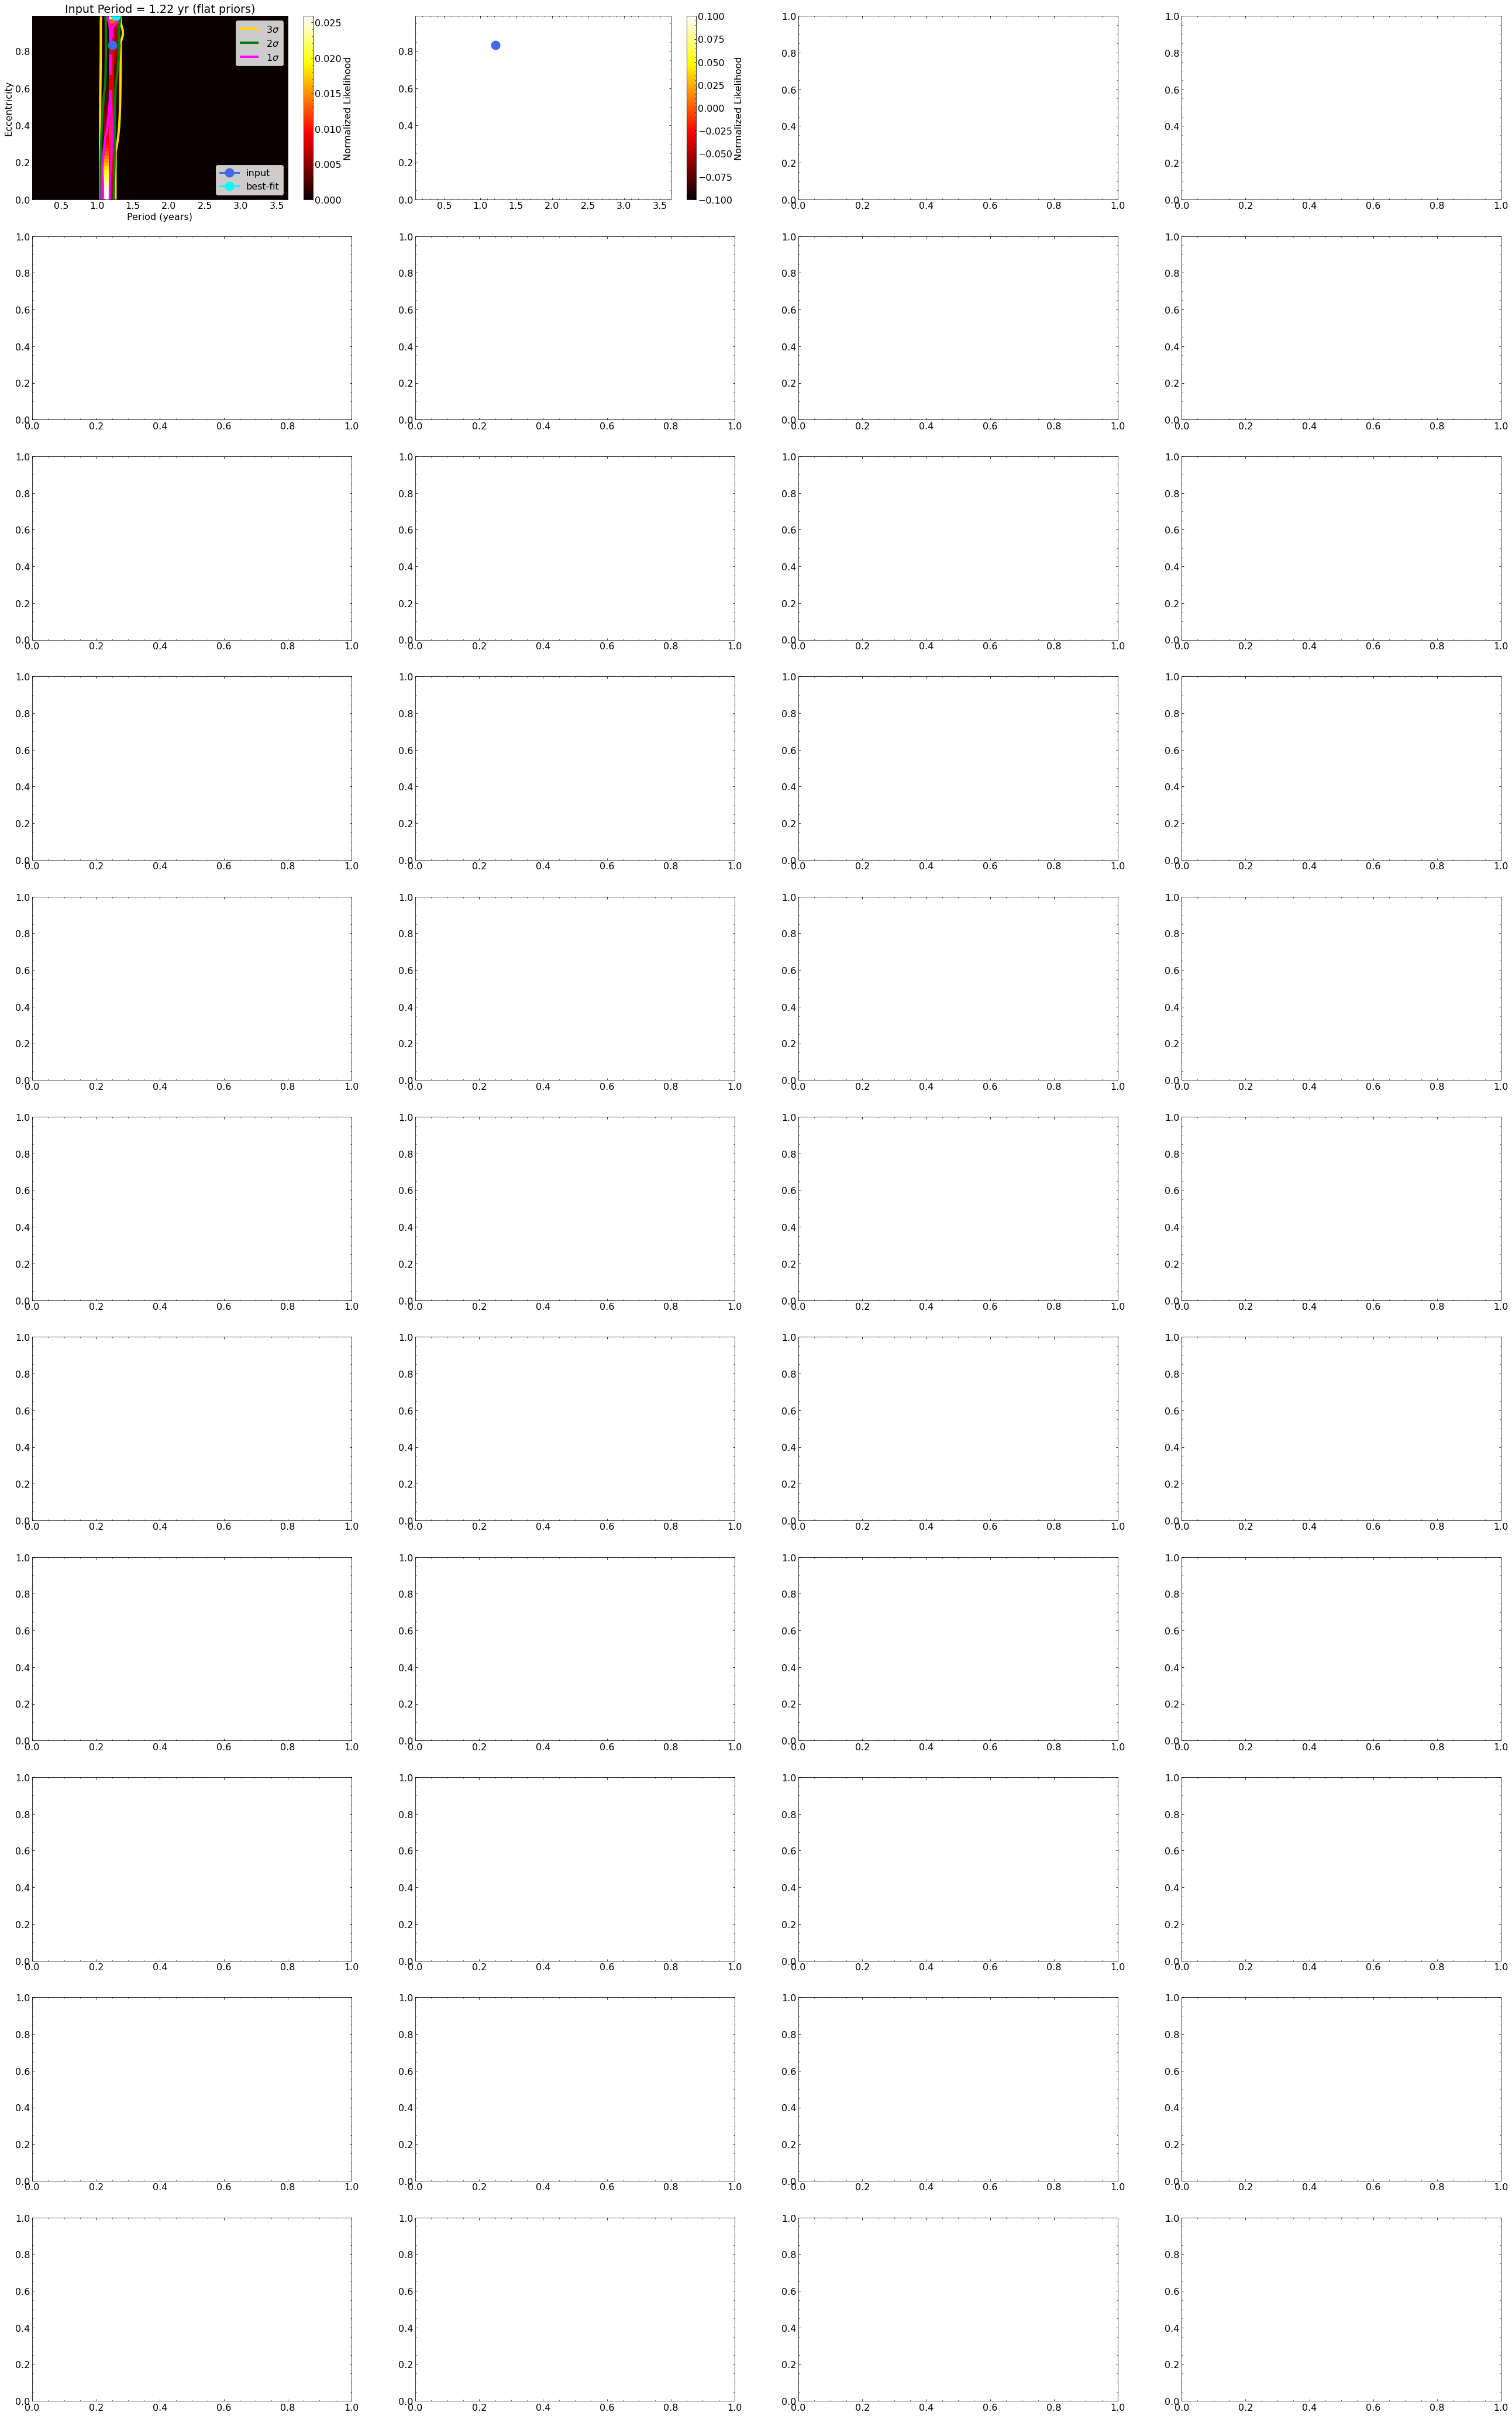

In [14]:
# set the number of grid points for each parameter
p_num = [50]
ecc_num = [50]
tp_num = [200]
    

for j in range(1):
    df = pd.DataFrame()
    
    plt.clf()
    fig, axes = plt.subplots(len(multi_factor), 4, figsize=(45, 75))
    
    
    for i in range(len(multi_factor)): 
        per = per_input[i]
        # compute the interpolated function of the semi-major axis in terms of SNR and input period
        eff_a = modified_a(a_input_test, per, om_input, Om_input, cosi_input, tp_input, ecc_input, noise_seed, t, coef_skeleton, coef_ske5p, sigw)
        # calculate Thiele-Innes elements
        a_input = eff_a(SNR[2]) #set SNR = 10
        A = a_input*(np.cos(Om_input)*np.cos(om_input) - np.sin(Om_input)*np.sin(om_input)*cosi_input)
        B = a_input*(np.sin(Om_input)*np.cos(om_input) + np.cos(Om_input)*np.sin(om_input)*cosi_input)
        F = a_input*(-np.cos(Om_input)*np.sin(om_input) - np.sin(Om_input)*np.cos(om_input)*cosi_input)
        G = a_input*(-np.sin(Om_input)*np.sin(om_input) + np.cos(Om_input)*np.cos(om_input)*cosi_input)
        per = round(per_input[i], 4)
        X, Y = calc_XY(t, t.shape[0], tp_input, per, ecc_input)
        wobs_fake = B*X*sintheta + G*Y*sintheta + A*X*costheta + F*Y*costheta + noise_seed
    
        # set the range of period and eccentricity 
        p_range = [0.1, per*3]
        ecc_range = [0, 0.99]

        p_grid, ecc_grid, tp_grid = create_grid(p_num, ecc_num, tp_num, p_range, ecc_range)
        x, y = np.meshgrid(p_grid[0], ecc_grid[0])
    
         # define the orbits
        orbits = wobs_fake
        snr = orbits/sigw # normalized 1D measurements
    
    
        # the likelihood marginalized over tp
        _, like_mrgnlzd_over_tp_flat, like_mrgnlzd_over_tp_prop = likelihood(tp_grid[0], p_grid[0], ecc_grid[0], t, coef_skeleton, snr, sigw)
        # the likelihood of two-step marginalization
        like_2step_flat, like_2step_logflat = twostep_likelihood(tp_grid[0], p_grid[0], ecc_grid[0], t, coef_skeleton, snr, sigw, 1e4, 100)
        
        # normalize the likelihood
        normlz_like_flat = like_mrgnlzd_over_tp_flat/np.sum(like_mrgnlzd_over_tp_flat)
        normlz_like_prop = like_mrgnlzd_over_tp_prop/np.sum(like_mrgnlzd_over_tp_prop)
        normlz_like_2step_flat = like_2step_flat/np.sum(like_2step_flat)
        normlz_like_2step_logflat = like_2step_logflat/np.sum(like_2step_logflat)
        
        # calculate the thresholds of confidence intervals
        levels_flat = confint(normlz_like_flat, p_grid[0], ecc_grid[0])
        levels_prop = confint(normlz_like_prop, p_grid[0], ecc_grid[0])
        levels_2step_flat = confint(normlz_like_2step_flat, p_grid[0], ecc_grid[0])
        levels_2step_logflat = confint(normlz_like_2step_logflat, p_grid[0], ecc_grid[0])
        
        best_fit_flat = np.where(normlz_like_flat == normlz_like_flat.max())
        best_fit_prop = np.where(normlz_like_prop == normlz_like_prop.max())
        best_fit_2step_flat = np.where(normlz_like_2step_flat == normlz_like_2step_flat.max())
        best_fit_2step_logflat = np.where(normlz_like_2step_logflat == normlz_like_2step_logflat.max())
        
#         df = df.append({'SNR':SNR[j],'a_input':a_input,'om_input':om_input,'Om_input':Om_input,'cosi_input':cosi_input,'per_input':per, 
#                         'ecc_input':ecc_input,'tp_input':tp_input,'p_best_flat':p_grid[0][best_fit_flat[0][0]],'ecc_best_flat':ecc_grid[0][best_fit_flat[1][0]],
#                         'p_best_prop':p_grid[0][best_fit_prop[0][0]],'ecc_best_prop':ecc_grid[0][best_fit_prop[1][0]],'p_best_ori':p_grid[0][best_fit_ori[0][0]],
#                         'ecc_best_ori':ecc_grid[0][best_fit_ori[1][0]]}
#                         , ignore_index = True)

        contour_label = [r'$3 \sigma$', r'$2 \sigma$', r'$1 \sigma$']
        
        im1 = axes[i, 0].imshow(normlz_like_flat.T, origin='lower', cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto') 
        fig.colorbar(im1, ax=axes[i, 0], orientation='vertical', label='Normalized Likelihood')
        m, = axes[i, 0].plot(per, ecc_input, color='royalblue', marker='o', markersize=15, label='input')
        n, = axes[i, 0].plot(p_grid[0][best_fit_flat[0][0]], ecc_grid[0][best_fit_flat[1][0]], color='cyan', marker='o', markersize=15, label='best-fit')
        first_legend = axes[i, 0].legend(handles=[m, n], loc=4) 
        # Add the legend manually to the current Axes.
        axes[i, 0].add_artist(first_legend)
        # Add labels of contours in the legend
        C = axes[i, 0].contour(x, y, normlz_like_flat.T, levels=levels_flat, linewidths=4, colors=('gold', 'green', 'magenta'), extent=[x.min(), x.max(), y.min(), y.max()])
        h = C.collections
        l = [contour_label[c] for c in range(len(contour_label))]
        axes[i, 0].legend(h,l, loc=1)            
        axes[i, 0].set_xlabel("Period (years)")
        axes[i, 0].set_ylabel("Eccentricity")
        axes[i, 0].set_title("Input Period = %.2f yr (flat priors)" %per)
        
        im2 = axes[i, 1].imshow(normlz_like_2step_flat.T, origin='lower', cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto') 
        fig.colorbar(im2, ax=axes[i, 1], orientation='vertical', label='Normalized Likelihood')
        m, = axes[i, 1].plot(per, ecc_input, color='royalblue', marker='o', markersize=15, label='input')
        n, = axes[i, 1].plot(p_grid[0][best_fit_2step_flat[0][0]], ecc_grid[0][best_fit_2step_flat[1][0]], color='cyan', marker='o', markersize=15, label='best-fit')
        first_legend = axes[i, 1].legend(handles=[m, n], loc=4)         
        # Add the legend manually to the current Axes.
        axes[i, 1].add_artist(first_legend)
        # Add labels of contours in the legend
        C = axes[i, 1].contour(x, y, normlz_like_2step_flat.T, levels=levels_2step_flat, linewidths=4, colors=('gold', 'green', 'magenta'), extent=[x.min(), x.max(), y.min(), y.max()])
        h = C.collections
        l = [contour_label[c] for c in range(len(contour_label))]
        axes[i, 1].legend(h,l, loc=1)         
        axes[i, 1].set_xlabel("Period (years)")
        axes[i, 1].set_ylabel("Eccentricity")
        axes[i, 1].set_title("Two-step flat priors" %per)
        
        im3 = axes[i, 2].imshow(normlz_like_prop.T, origin='lower', cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto') 
        fig.colorbar(im3, ax=axes[i, 2], orientation='vertical', label='Normalized Likelihood')
        m, = axes[i, 2].plot(per, ecc_input, color='royalblue', marker='o', markersize=15, label='input')
        n, = axes[i, 2].plot(p_grid[0][best_fit_prop[0][0]], ecc_grid[0][best_fit_prop[1][0]], color='cyan', marker='o', markersize=15, label='best-fit')
        first_legend = axes[i, 2].legend(handles=[m, n], loc=4)         
        # Add the legend manually to the current Axes.
        axes[i, 2].add_artist(first_legend)
        # Add labels of contours in the legend
        C = axes[i, 2].contour(x, y, normlz_like_prop.T, levels=levels_prop, linewidths=4, colors=('gold', 'green', 'magenta'), extent=[x.min(), x.max(), y.min(), y.max()])
        h = C.collections
        l = [contour_label[c] for c in range(len(contour_label))]
        axes[i, 2].legend(h,l, loc=1)         
        axes[i, 2].set_xlabel("Period (years)")
        axes[i, 2].set_ylabel("Eccentricity")
        axes[i, 2].set_title("Input Period = %.2f yr (logflat priors)" %per)
        
        im4 = axes[i, 3].imshow(normlz_like_2step_logflat.T, origin='lower', cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto') 
        fig.colorbar(im3, ax=axes[i, 3], orientation='vertical', label='Normalized Likelihood')
        m, = axes[i, 3].plot(per, ecc_input, color='royalblue', marker='o', markersize=15, label='input')
        n, = axes[i, 3].plot(p_grid[0][best_fit_2step_logflat[0][0]], ecc_grid[0][best_fit_2step_logflat[1][0]], color='cyan', marker='o', markersize=15, label='best-fit')
        first_legend = axes[i, 3].legend(handles=[m, n], loc=4)         
        # Add the legend manually to the current Axes.
        axes[i, 3].add_artist(first_legend)
        # Add labels of contours in the legend
        C = axes[i, 3].contour(x, y, normlz_like_2step_logflat.T, levels=levels_2step_logflat, linewidths=4, colors=('gold', 'green', 'magenta'), extent=[x.min(), x.max(), y.min(), y.max()])
        h = C.collections
        l = [contour_label[c] for c in range(len(contour_label))]
        axes[i, 3].legend(h,l, loc=1)         
        axes[i, 3].set_xlabel("Period (years)")
        axes[i, 3].set_ylabel("Eccentricity")
        axes[i, 3].set_title("Two-step logflat priors" %per)
        
    
#     df.to_csv('./plots/fake_orbits/v1298T/fake1.5_'+str(SNR[j])+'.csv', index=False)
    plt.savefig('./plots/fake_orbits/v1298T/fake1.5_'+str(SNR[j])+'.pdf')

## Check the effect of the semimajor axis prior on marginalization

In [39]:
def margin_chisq_prior_3(tp, per, ecc, t, coef_skeleton, snr, sigw):
    X, Y = calc_XY(t, t.shape[0], tp, per, ecc)
    coef_matrix = coef_skeleton.copy()
    coef_matrix[-4, :] *= X
    coef_matrix[-3, :] *= Y
    coef_matrix[-2, :] *= X
    coef_matrix[-1, :] *= Y
    
    coef = np.linalg.lstsq(coef_matrix.T, snr, rcond=None)[0]
    chisq = np.sum((snr - coef@coef_matrix)**2)
    
    #compute the marginalization factor
    norm = np.log(np.linalg.det(coef_matrix@coef_matrix.T))
    
    #compute the Jacobian determinant to account for the uniform priors of the Campbell elements
    B, G, A, F = coef[-4:]
    u = 0.5*(A**2 + B**2 + F**2 + G**2)
    v = B*F - A*G
    smarcsec = np.sqrt(u + np.sqrt(u**2 - v**2)) 
    sinsq_i = 1 + v/smarcsec**2 
    # set floors on sin(i) and sma to avoid a singularity
    # floors of 1e-2 in sin(i)^2 and the typical position error divided by sqrt(n)
    jacdet = (sinsq_i + 1e-2)*(smarcsec + np.median(sigw)/len(sigw)**0.5)**3 #flat prior: 3, prior 1/a: 4
    
    return chisq, chisq + norm + 2*np.log(jacdet)

In [40]:
def likelihood_prior_3(tps, periods, eccs, t, coef_skeleton, snr, sigw):
    like_ori = np.zeros((len(periods), len(eccs)))
    like_mrgnlzd = np.zeros((len(periods), len(eccs)))
    for i in range(len(periods)):
        for j in range(len(eccs)):
            like_ori_sub = np.zeros(len(tps))
            like_sub = np.zeros(len(tps))
            for k in range(len(tps)):
                logL_ori, logL = margin_chisq_prior_3(tps[k], periods[i], eccs[j], t, coef_skeleton, snr, sigw)
                like_ori_sub[k] = np.exp(-0.5*logL_ori)
                like_sub[k] = np.exp(-0.5*logL)
            like_ori[i, j] = np.sum(like_ori_sub)          
            like_mrgnlzd[i, j] = np.sum(like_sub)    
    return like_ori, like_mrgnlzd                      
                        

In [41]:
def margin_chisq_prior_4(tp, per, ecc, t, coef_skeleton, snr, sigw):
    X, Y = calc_XY(t, t.shape[0], tp, per, ecc)
    coef_matrix = coef_skeleton.copy()
    coef_matrix[-4, :] *= X
    coef_matrix[-3, :] *= Y
    coef_matrix[-2, :] *= 
    coef_matrix[-1, :] *= Y
    
    coef = np.linalg.lstsq(coef_matrix.T, snr, rcond=None)[0]
    chisq = np.sum((snr - coef@coef_matrix)**2)
    
    #compute the marginalization factor
    norm = np.log(np.linalg.det(coef_matrix@coef_matrix.T))
    
    #compute the Jacobian determinant to account for the uniform priors of the Campbell elements
    B, G, A, F = coef[-4:]
    u = 0.5*(A**2 + B**2 + F**2 + G**2)
    v = B*F - A*G
    smarcsec = np.sqrt(u + np.sqrt(u**2 - v**2)) 
    sinsq_i = 1 + v/smarcsec**2 
    # set floors on sin(i) and sma to avoid a singularity
    # floors of 1e-2 in sin(i)^2 and the typical position error divided by sqrt(n)
    jacdet = (sinsq_i + 1e-2)*(smarcsec + np.median(sigw)/len(sigw)**0.5)**4 #flat prior: 3, prior 1/a: 4
    
    return chisq, chisq + norm + 2*np.log(jacdet)

In [42]:
def likelihood_prior_4(tps, periods, eccs, t, coef_skeleton, snr, sigw):
    like_ori = np.zeros((len(periods), len(eccs)))
    like_mrgnlzd = np.zeros((len(periods), len(eccs)))
    for i in range(len(periods)):
        for j in range(len(eccs)):
            like_ori_sub = np.zeros(len(tps))
            like_sub = np.zeros(len(tps))
            for k in range(len(tps)):
                logL_ori, logL = margin_chisq_prior_4(tps[k], periods[i], eccs[j], t, coef_skeleton, snr, sigw)
                like_ori_sub[k] = np.exp(-0.5*logL_ori)
                like_sub[k] = np.exp(-0.5*logL)
            like_ori[i, j] = np.sum(like_ori_sub)          
            like_mrgnlzd[i, j] = np.sum(like_sub)    
    return like_ori, like_mrgnlzd                      
                        

The sigma likelihood contour is at value of [6.06882788e-05]
The sigma likelihood contour is at value of [6.23505512e-05]
The best-fit period with a flat semimajor prior is 4.2403 years, while the best-fit value with a 1/a prior is 3.4389 years.
The best-fit eccentricity with a flat semimajor prioris 0.2487, while the best-fit value with a 1/a prior is 0.2678.


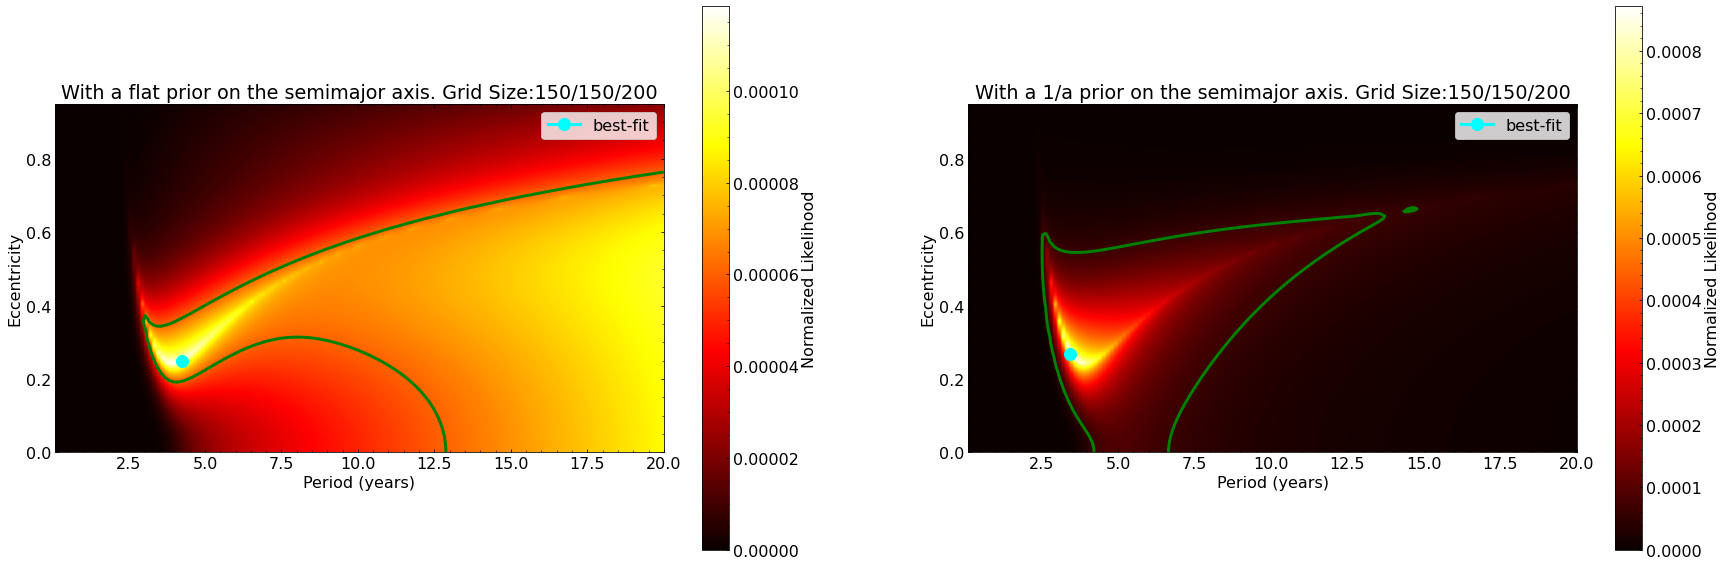

In [43]:
coef_skeleton= np.asarray([sintheta, costheta, t*sintheta, t*costheta, parfac, 
                          sintheta, sintheta, costheta, costheta])/sigw[np.newaxis, :]
# define the orbits
orbits = wobs
# compute the signal-to-noise ratio first
snr = orbits/sigw

# set the number of grid points for each parameter
p_num = [150]
ecc_num = [150]
tp_num = [200]

# set the range of period and eccentricity 
p_range = [0.1, 20]
ecc_range = [0, 0.95]

p_grid, ecc_grid, tp_grid = create_grid(p_num, ecc_num, tp_num, p_range, ecc_range)

#The likelihood marginalized over tp
like_prior_3 = likelihood_prior_3(tp_grid[0], p_grid[0], ecc_grid[0], t, coef_skeleton, snr, sigw)[1]
like_prior_4 = likelihood_prior_4(tp_grid[0], p_grid[0], ecc_grid[0], t, coef_skeleton, snr, sigw)[1]

# normalize the likelihood
normlz_like_3 = like_prior_3/np.sum(like_prior_3)
normlz_like_4 = like_prior_4/np.sum(like_prior_4)

levels_prior_3 = onesig(normlz_like_3, p_grid[0], ecc_grid[0])
levels_prior_4 = onesig(normlz_like_4, p_grid[0], ecc_grid[0])


best_fit_prior_3 = np.where(normlz_like_3 == normlz_like_3.max())
best_fit_prior_4 = np.where(normlz_like_4 == normlz_like_4.max())
print("The best-fit period with a flat semimajor prior is {:.4f} years, while the best-fit value with a 1/a prior is {:.4f} years.".format(p_grid[0][best_fit_prior_3[0][0]], p_grid[0][best_fit_prior_4[0][0]]))
print("The best-fit eccentricity with a flat semimajor prioris {:.4f}, while the best-fit value with a 1/a prior is {:.4f}.".format(ecc_grid[0][best_fit_prior_3[1][0]], ecc_grid[0][best_fit_prior_4[1][0]]))


x, y = np.meshgrid(p_grid[0], ecc_grid[0])
fig, ax = plt.subplots(1, 2, figsize=(30, 10))
im1 = ax[0].imshow(normlz_like_3.T, origin='lower', cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], aspect=12) 
fig.colorbar(im1, ax=ax[0], orientation='vertical', label='Normalized Likelihood')
ax[0].plot(p_grid[0][best_fit_prior_3[0][0]], ecc_grid[0][best_fit_prior_3[1][0]], color='cyan', marker='o', markersize=12, label='best-fit')
ax[0].legend()
ax[0].contour(normlz_like_3.T, levels_prior_3, colors='g', extent=[x.min(), x.max(), y.min(), y.max()])
ax[0].set_xlabel("Period (years)")
ax[0].set_ylabel("Eccentricity")
ax[0].set_title('With a flat prior on the semimajor axis. Grid Size:%d/%d/%d' %(p_num[0], ecc_num[0], tp_num[0]))

im2 = ax[1].imshow(normlz_like_4.T, origin='lower', cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], aspect=12) 
fig.colorbar(im2, ax=ax[1], orientation='vertical', label='Normalized Likelihood')
ax[1].plot(p_grid[0][best_fit_prior_4[0][0]], ecc_grid[0][best_fit_prior_4[1][0]], color='cyan', marker='o', markersize=12, label='best-fit')
ax[1].legend()
ax[1].contour(normlz_like_4.T, levels_prior_4, colors='g', extent=[x.min(), x.max(), y.min(), y.max(  )])
ax[1].set_xlabel("Period (years)")
ax[1].set_ylabel("Eccentricity")
ax[1].set_title('With a 1/a prior on the semimajor axis. Grid Size:%d/%d/%d' %(p_num[0], ecc_num[0], tp_num[0]))
plt.savefig('compare_prior.pdf')

## Deterministic Profiling

In [6]:
# compute bias
import profile
pr = profile.Profile()
for i in range(5):
    print(pr.calibrate(100000))
# 1. Apply computed bias to all Profile instances created hereafter.
profile.Profile.bias = 1.32e-06

# 2. Apply computed bias to a specific Profile instance.
# pr = profile.Profile()
# pr.bias = your_computed_bias

# 3. Specify computed bias in instance constructor.
# pr = profile.Profile(bias=your_computed_bias)


1.1561184388160044e-06
1.3391666083339254e-06
1.3287017129824597e-06
1.3254567454330138e-06
1.314246857533883e-06


In [128]:
# define the orbits
orbits = wobs

# set the number of grid points for each parameter
p_num = [20]
ecc_num = [20]
tp_num = [50]

# set the range of period and eccentricity 
p_range = [0.1, 15]
ecc_range = [0, 0.85]

p_grid, ecc_grid, tp_grid = create_grid(p_num, ecc_num, tp_num, p_range, ecc_range)

In [129]:
def margin_chisq_test1(tp, per, ecc, orbits, t, sintheta, costheta, parfac, sigw):
    X, Y = calc_XY(t, t.shape[0], tp, per, ecc)
    coef_matrix = np.asarray([sintheta, costheta, t*sintheta, t*costheta, parfac, 
                              X*sintheta, Y*sintheta, X*costheta, Y*costheta])/sigw[np.newaxis, :]
    coef = np.linalg.lstsq(coef_matrix.T, orbits/sigw, rcond=None)[0]
    chisq = np.sum((orbits/sigw - coef@coef_matrix)**2)
    
    #compute the marginalization factor
    norm = np.log(np.linalg.det(coef_matrix@coef_matrix.T))
    
    #compute the Jacobian determinant to account for the uniform priors of the Campbell elements
    B, G, A, F = coef[-4:]
    u = 0.5*(A**2 + B**2 + F**2 + G**2)
    v = B*F - A*G
    smarcsec = np.sqrt(u + np.sqrt(u**2 - v**2)) 
    sinsq_i = 1 + v/smarcsec**2 
    # set floors on sin(i) and sma to avoid a singularity
    # floors of 1e-2 in sin(i)^2 and the typical position error divided by sqrt(n)
    jacdet = (sinsq_i + 1e-2)*(smarcsec + np.median(sigw)/len(sigw)**0.5)**3 #flat prior: 3, prior 1/a: 4
    
    return chisq, chisq + norm + 2*np.log(jacdet)

In [130]:
def likelihood_test1(tps, periods, eccs, orbits, t, sintheta, costheta, parfac, sigw):
    like_ori = np.zeros((len(periods), len(eccs)))
    like_mrgnlzd = np.zeros((len(periods), len(eccs)))
    for i in range(len(periods)):
        for j in range(len(eccs)):
            like_ori_sub = np.zeros(len(tps))
            like_sub = np.zeros(len(tps))
            for k in range(len(tps)):
                logL_ori, logL = margin_chisq_test1(tps[k], periods[i], eccs[j], orbits, t, sintheta, costheta, parfac, sigw)
                like_ori_sub[k] = np.exp(-0.5*logL_ori)
                like_sub[k] = np.exp(-0.5*logL)
            like_ori[i, j] = np.sum(like_ori_sub)          
            like_mrgnlzd[i, j] = np.sum(like_sub)    
    return like_ori, like_mrgnlzd                                              

In [131]:
cProfile.run('likelihood_test1(tp_grid[0], p_grid[0], ecc_grid[0], orbits, t, sintheta, costheta, parfac, sigw)', 'profiler/restats1')

In [132]:
p = pstats.Stats('profiler/restats1')
p.strip_dirs().sort_stats(-1).print_stats()

Wed Sep 28 11:40:39 2022    profiler/restats1

         28269237 function calls (26829237 primitive calls) in 18.854 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.142    0.142   18.854   18.854 1534699059.py:1(likelihood_test1)
    20000    1.938    0.000   18.703    0.001 3972722247.py:1(margin_chisq_test1)
    20000    0.018    0.000    0.366    0.000 <__array_function__ internals>:2(det)
    20000    0.026    0.000    2.969    0.000 <__array_function__ internals>:2(lstsq)
    20000    0.024    0.000    0.987    0.000 <__array_function__ internals>:2(mean)
    20000    0.019    0.000    4.843    0.000 <__array_function__ internals>:2(median)
    20000    0.019    0.000    0.888    0.000 <__array_function__ internals>:2(moveaxis)
    20000    0.021    0.000    0.792    0.000 <__array_function__ internals>:2(partition)
    20800    0.023    0.000    0.859    0.000 <__array_function__ internals>:2(sum)
     

In [133]:
coef_skeleton= np.asarray([sintheta, costheta, t*sintheta, t*costheta, parfac, 
                          sintheta, sintheta, costheta, costheta])/sigw[np.newaxis, :]
snr = orbits/sigw

In [134]:
def margin_chisq_test2(tp, per, ecc, t, coef_skeleton, snr, sigw):
    X, Y = calc_XY(t, t.shape[0], tp, per, ecc)
    coef_matrix = coef_skeleton.copy()
    coef_matrix[-4, :] *= X
    coef_matrix[-3, :] *= Y
    coef_matrix[-2, :] *= X
    coef_matrix[-1, :] *= Y
    
    coef = np.linalg.lstsq(coef_matrix.T, snr, rcond=None)[0]
    chisq = np.sum((snr - coef@coef_matrix)**2)
    
    #compute the marginalization factor
    norm = np.log(np.linalg.det(coef_matrix@coef_matrix.T))
    
    #compute the Jacobian determinant to account for the uniform priors of the Campbell elements
    B, G, A, F = coef[-4:]
    u = 0.5*(A**2 + B**2 + F**2 + G**2)
    v = B*F - A*G
    smarcsec = np.sqrt(u + np.sqrt(u**2 - v**2)) 
    sinsq_i = 1 + v/smarcsec**2 
    # set floors on sin(i) and sma to avoid a singularity
    # floors of 1e-2 in sin(i)^2 and the typical position error divided by sqrt(n)
    jacdet = (sinsq_i + 1e-2)*(smarcsec + np.median(sigw)/len(sigw)**0.5)**3 #flat prior: 3, prior 1/a: 4
    
    return chisq, chisq + norm + 2*np.log(jacdet)

In [135]:
def likelihood_test2(tps, periods, eccs, t, coef_skeleton, snr, sigw):
    like_ori = np.zeros((len(periods), len(eccs)))
    like_mrgnlzd = np.zeros((len(periods), len(eccs)))
    for i in range(len(periods)):
        for j in range(len(eccs)):
            like_ori_sub = np.zeros(len(tps))
            like_sub = np.zeros(len(tps))
            for k in range(len(tps)):
                logL_ori, logL = margin_chisq_test2(tps[k], periods[i], eccs[j], t, coef_skeleton, snr, sigw)
                like_ori_sub[k] = np.exp(-0.5*logL_ori)
                like_sub[k] = np.exp(-0.5*logL)
            like_ori[i, j] = np.sum(like_ori_sub)          
            like_mrgnlzd[i, j] = np.sum(like_sub)    
    return like_ori, like_mrgnlzd                                              

In [136]:
cProfile.run('likelihood_test2(tp_grid[0], p_grid[0], ecc_grid[0], t, coef_skeleton, snr, sigw)', 'profiler/restats2')

In [137]:
p = pstats.Stats('profiler/restats2')
p.strip_dirs().sort_stats(-1).print_stats()

Wed Sep 28 11:40:52 2022    profiler/restats2

         16969233 function calls (16129233 primitive calls) in 12.589 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    20000    1.164    0.000   12.460    0.001 2129993146.py:1(margin_chisq_test2)
        1    0.120    0.120   12.589   12.589 3763082716.py:1(likelihood_test2)
    20000    0.016    0.000    0.336    0.000 <__array_function__ internals>:2(det)
    20000    0.026    0.000    2.798    0.000 <__array_function__ internals>:2(lstsq)
    20000    0.023    0.000    0.966    0.000 <__array_function__ internals>:2(mean)
    20000    0.018    0.000    4.964    0.000 <__array_function__ internals>:2(median)
    20000    0.017    0.000    0.856    0.000 <__array_function__ internals>:2(moveaxis)
    20000    0.020    0.000    0.989    0.000 <__array_function__ internals>:2(partition)
    20800    0.021    0.000    0.816    0.000 <__array_function__ internals>:2(sum)
     

In [138]:
def margin_chisq_test3(tp, per, ecc, t, coef_skeleton, snr, sigw):
    X, Y = calc_XY(t, t.shape[0], tp, per, ecc)
    coef_matrix = coef_skeleton.copy()
    coef_matrix[-4, :] *= X
    coef_matrix[-3, :] *= Y
    coef_matrix[-2, :] *= X
    coef_matrix[-1, :] *= Y
    
    #coef = np.linalg.lstsq(coef_matrix.T, snr, rcond=None)[0]
    #chisq = np.sum((snr - coef@coef_matrix)**2)
    
    for i in range(10):
        coef, chisq, _, _ = np.linalg.lstsq(coef_matrix.T, snr, rcond=None)    
    #compute the marginalization factor
        norm = np.log(np.linalg.det(coef_matrix@coef_matrix.T))
    
    #compute the Jacobian determinant to account for the uniform priors of the Campbell elements
    B, G, A, F = coef[-4:]
    u = 0.5*(A**2 + B**2 + F**2 + G**2)
    v = B*F - A*G
    smarcsec = np.sqrt(u + np.sqrt(u**2 - v**2)) 
    sinsq_i = 1 + v/smarcsec**2 
    # set floors on sin(i) and sma to avoid a singularity
    # floors of 1e-2 in sin(i)^2 and the typical position error divided by sqrt(n)
    jacdet = (sinsq_i + 1e-2)*(smarcsec + np.median(sigw)/len(sigw)**0.5)**3 #flat prior: 3, prior 1/a: 4
    
    return chisq, chisq + norm + 2*np.log(jacdet)

In [139]:
def likelihood_test3(tps, periods, eccs, t, coef_skeleton, snr, sigw):
    like_ori = np.zeros((len(periods), len(eccs)))
    like_mrgnlzd = np.zeros((len(periods), len(eccs)))
    for i in range(len(periods)):
        for j in range(len(eccs)):
            like_ori_sub = np.zeros(len(tps))
            like_sub = np.zeros(len(tps))
            for k in range(len(tps)):
                logL_ori, logL = margin_chisq_test3(tps[k], periods[i], eccs[j], t, coef_skeleton, snr, sigw)
                like_ori_sub[k] = np.exp(-0.5*logL_ori)
                like_sub[k] = np.exp(-0.5*logL)
            like_ori[i, j] = np.sum(like_ori_sub)          
            like_mrgnlzd[i, j] = np.sum(like_sub)    
    return like_ori, like_mrgnlzd                                              

In [140]:
cProfile.run('likelihood_test3(tp_grid[0], p_grid[0], ecc_grid[0], t, coef_skeleton, snr, sigw)', 'profiler/restats3')

In [141]:
p = pstats.Stats('profiler/restats3')
p.strip_dirs().sort_stats(-1).print_stats()

Wed Sep 28 11:41:32 2022    profiler/restats3

         48289231 function calls (46249231 primitive calls) in 40.182 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    20000    3.187    0.000   37.642    0.002 3797471215.py:1(margin_chisq_test3)
        1    0.411    0.411   40.181   40.181 3963462840.py:1(likelihood_test3)
   200000    0.173    0.000    2.965    0.000 <__array_function__ internals>:2(det)
   200000    0.192    0.000   24.392    0.000 <__array_function__ internals>:2(lstsq)
    20000    0.026    0.000    1.058    0.000 <__array_function__ internals>:2(mean)
    20000    0.020    0.000    5.184    0.000 <__array_function__ internals>:2(median)
    20000    0.018    0.000    0.911    0.000 <__array_function__ internals>:2(moveaxis)
    20000    0.021    0.000    0.953    0.000 <__array_function__ internals>:2(partition)
      800    0.001    0.000    0.009    0.000 <__array_function__ internals>:2(sum)
     

# HIP 71898

In [136]:
# Read data file with scanning law parameters (angles and parallax factors)
gaia_scan_hip71898 = QTable.read('./data/scan_law_par/hip71898_trunc.csv')

# grab the obs. time
juld = gaia_scan_hip71898['ObservationTimeAtBarycentre[BarycentricJulianDateInTCB]']
ref_ep = 2457389.0 # Reference Epoch (J2016.0)
t = (juld - ref_ep)/365.25 # in Julian years from 2016.0

# grab scanning law parameter variables
theta = gaia_scan_hip71898['scanAngle[rad]']
costheta = np.cos(theta)
sintheta = np.sin(theta)
parfac = gaia_scan_hip71898['parallaxFactorAlongScan']

sigw = np.ones(len(theta))*5e-5

coef_skeleton= np.asarray([sintheta, costheta, t*sintheta, t*costheta, parfac, 
                          sintheta, sintheta, costheta, costheta])/sigw[np.newaxis, :]

The sigma likelihood contour is at value of [0.00050021]
The sigma likelihood contour is at value of [0.00058541]
The sigma likelihood contour is at value of [0.00051715]
The sigma likelihood contour is at value of [0.00050429]
The sigma likelihood contour is at value of [0.00059297]
The sigma likelihood contour is at value of [0.00060646]
The sigma likelihood contour is at value of [0.00051172]
The sigma likelihood contour is at value of [0.00054293]
The sigma likelihood contour is at value of [0.00071909]
The sigma likelihood contour is at value of [0.00051743]
The sigma likelihood contour is at value of [0.00053385]
The sigma likelihood contour is at value of [0.00079509]
The sigma likelihood contour is at value of [0.01748751]
The sigma likelihood contour is at value of [0.00042459]
The sigma likelihood contour is at value of [0.00027242]
The sigma likelihood contour is at value of [0.01154522]
The sigma likelihood contour is at value of [0.00049213]
The sigma likelihood contour is

<Figure size 432x288 with 0 Axes>

<Figure size 1800x2520 with 0 Axes>

<Figure size 1800x2520 with 0 Axes>

<Figure size 1800x2520 with 0 Axes>

<Figure size 1800x2520 with 0 Axes>

<Figure size 1800x2520 with 0 Axes>

<Figure size 1800x2520 with 0 Axes>

<Figure size 1800x2520 with 0 Axes>

<Figure size 1800x2520 with 0 Axes>

<Figure size 1800x2520 with 0 Axes>

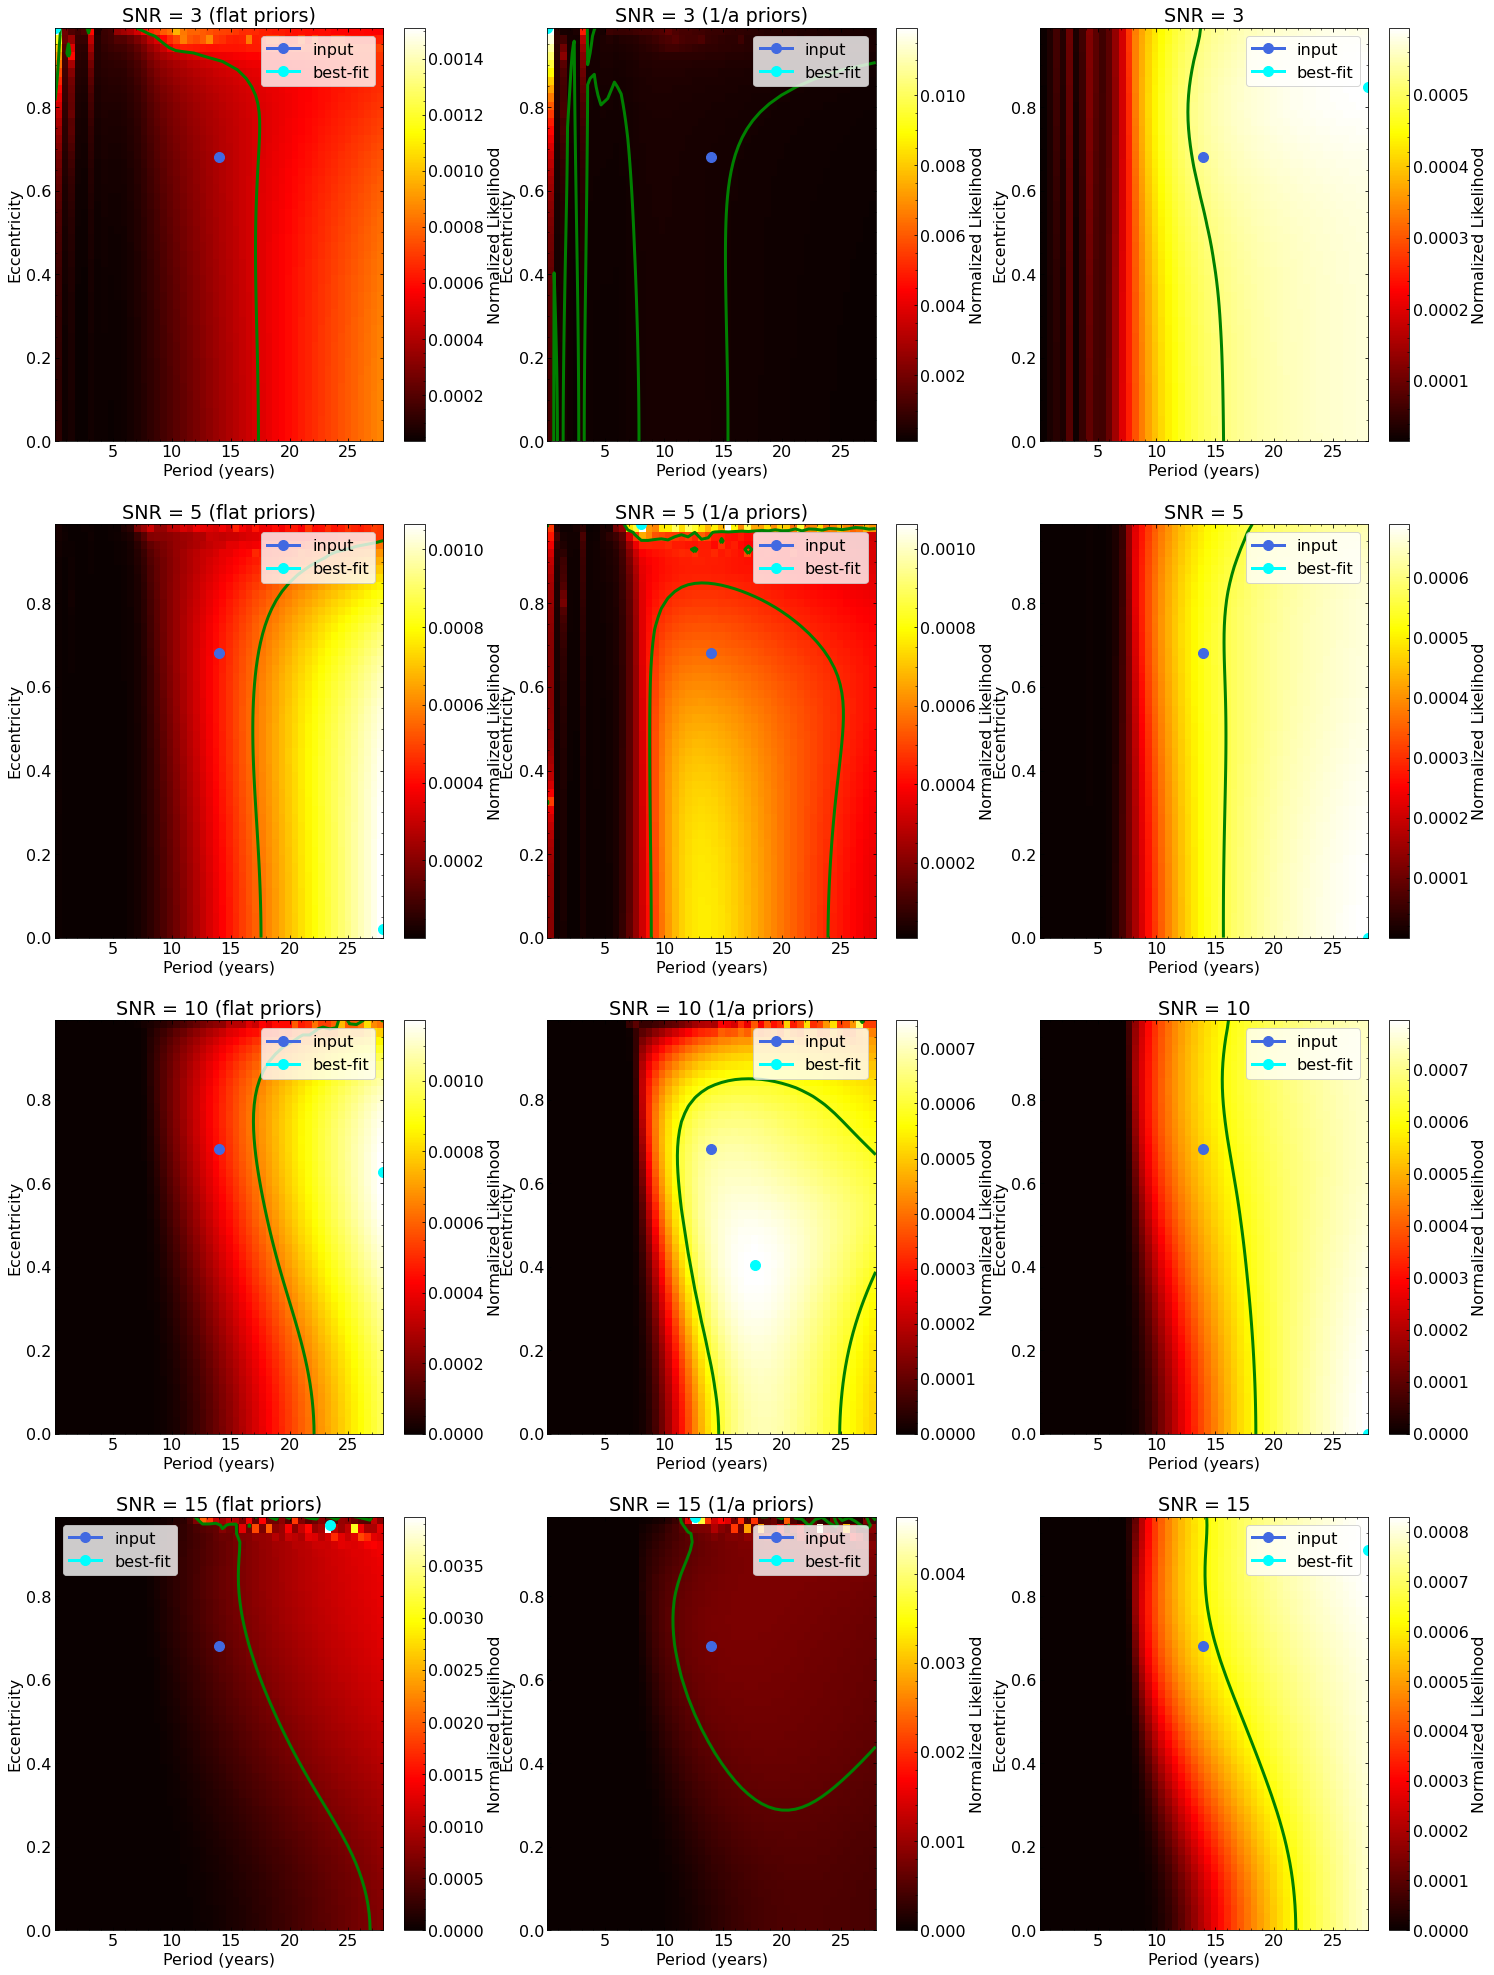

In [98]:
for trial in range(10):
    # generate fake orbits
    om_input = np.random.rand()*2*np.pi
    Om_input = np.random.rand()*2*np.pi
    cosi_input = np.random.rand()

    # set SNR = 3, 5, 10, 15
    SNR = np.array([3, 5, 10, 15])
    noise = 5e-5
    a_input = noise*SNR

    # calculate Thiele-Innes elements
    A = a_input*(np.cos(Om_input)*np.cos(om_input) - np.sin(Om_input)*np.sin(om_input)*cosi_input)
    B = a_input*(np.sin(Om_input)*np.cos(om_input) + np.cos(Om_input)*np.sin(om_input)*cosi_input)
    F = a_input*(-np.cos(Om_input)*np.sin(om_input) - np.sin(Om_input)*np.cos(om_input)*cosi_input)
    G = a_input*(-np.sin(Om_input)*np.sin(om_input) + np.cos(Om_input)*np.cos(om_input)*cosi_input)

    per_input = np.random.rand()*round((t[-1]-t[0])*3, 2)
    ecc_input = np.random.rand()*0.9
    tp_input = np.random.rand()*2*np.pi
    X, Y = calc_XY(t, t.shape[0], tp_input, per_input, ecc_input)

    wobs_fake = []
    noise_seed = np.random.randn(len(t))*sigw
    for i in range(len(SNR)):
        wobs_fake_clean = B[i]*X*sintheta + G[i]*Y*sintheta + A[i]*X*costheta + F[i]*Y*costheta
        wobs_fake.append(wobs_fake_clean + noise_seed)
    # print(a_input)
    # print(round(Om_input, 4))
    # print(round(om_input, 4))
    # print(round(cosi_input, 4))
    df = pd.DataFrame(data=[[om_input, Om_input, cosi_input, per_input, ecc_input, tp_input]], index=['0', '1', '2', '3'], columns=['om_input','Om_input','cosi_input','per_input','ecc_input','tp_input'])
    df['SNR'] = SNR
    df['a_input'] = a_input

    
    # set the number of grid points for each parameter
    p_num = [50]
    ecc_num = [50]
    tp_num = [200]

    # set the range of period and eccentricity 
    p_range = [0.1, per_input*2]
    ecc_range = [0, 0.99]

    p_grid, ecc_grid, tp_grid = create_grid(p_num, ecc_num, tp_num, p_range, ecc_range)

    plt.clf()
    x, y = np.meshgrid(p_grid[0], ecc_grid[0])
    fig, axes = plt.subplots(len(SNR), 3, figsize=(25, 35))
    p_best_flat = []
    ecc_best_flat = []
    p_best_prop = []
    ecc_best_prop = []
    p_best_ori = []
    ecc_best_ori = []
#     p_mean = []
#     ecc_mean = []
#     p_mean_ori = []
#     ecc_mean_ori = []
    for i in range(len(SNR)):
        # define the orbits
        orbits = wobs_fake[i]
        snr = orbits/sigw
    
        # the likelihood marginalized over tp
        like_ori_mrgnlzd_over_tp, like_mrgnlzd_over_tp_flat, like_mrgnlzd_over_tp_prop = likelihood(tp_grid[0], p_grid[0], ecc_grid[0], t, coef_skeleton, snr, sigw)
        
        # normalize the likelihood
        normlz_like_ori = like_ori_mrgnlzd_over_tp/np.sum(like_ori_mrgnlzd_over_tp)
        normlz_like_flat = like_mrgnlzd_over_tp_flat/np.sum(like_mrgnlzd_over_tp_flat)
        normlz_like_prop = like_mrgnlzd_over_tp_prop/np.sum(like_mrgnlzd_over_tp_prop)

        levels_ori = onesig(normlz_like_ori, p_grid[0], ecc_grid[0])
        levels_flat = onesig(normlz_like_flat, p_grid[0], ecc_grid[0])
        levels_prop = onesig(normlz_like_prop, p_grid[0], ecc_grid[0])

        best_fit_flat = np.where(normlz_like_flat == normlz_like_flat.max())
        best_fit_prop = np.where(normlz_like_prop == normlz_like_prop.max())
        best_fit_ori = np.where(normlz_like_ori == normlz_like_ori.max())
#         print("The period used to generate the fake orbit is {:.4f} years. The best-fit period with correction is {:.4f} years, while the best-fit value without correction is {:.4f} years.".format(per_input, p_grid[0][best_fit_prop[0][0]], p_grid[0][best_fit_ori[0][0]]))
#         print("The eccentricity used to generate the fake orbit is {:.4f}. The best-fit eccentricity is {:.4f}, while the best-fit value without correction is {:.4f}.".format(ecc_input, ecc_grid[0][best_fit_prop[1][0]], ecc_grid[0][best_fit_ori[1][0]]))
        p_best_flat.append(p_grid[0][best_fit_flat[0][0]])
        ecc_best_flat.append(ecc_grid[0][best_fit_flat[1][0]])
        p_best_prop.append(p_grid[0][best_fit_prop[0][0]])
        ecc_best_prop.append(ecc_grid[0][best_fit_prop[1][0]])
        p_best_ori.append(p_grid[0][best_fit_ori[0][0]])
        ecc_best_ori.append(ecc_grid[0][best_fit_ori[1][0]])
        
        im1 = axes[i, 0].imshow(normlz_like_flat.T, origin='lower', cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto') 
        fig.colorbar(im1, ax=axes[i, 0], orientation='vertical', label='Normalized Likelihood')
        axes[i, 0].plot(per_input, ecc_input, color='royalblue', marker='o', markersize=10, label='input')
        axes[i, 0].plot(p_grid[0][best_fit_flat[0][0]], ecc_grid[0][best_fit_flat[1][0]], color='cyan', marker='o', markersize=10, label='best-fit')
        axes[i, 0].legend()
        axes[i, 0].contour(normlz_like_flat.T, levels_flat, colors='g', extent=[x.min(), x.max(), y.min(), y.max()])
        axes[i, 0].set_xlabel("Period (years)")
        axes[i, 0].set_ylabel("Eccentricity")
        axes[i, 0].set_title("SNR = %d (flat priors)" %SNR[i])

        im2 = axes[i, 1].imshow(normlz_like_prop.T, origin='lower', cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto') 
        fig.colorbar(im2, ax=axes[i, 1], orientation='vertical', label='Normalized Likelihood')
        axes[i, 1].plot(per_input, ecc_input, color='royalblue', marker='o', markersize=10, label='input')
        axes[i, 1].plot(p_grid[0][best_fit_prop[0][0]], ecc_grid[0][best_fit_prop[1][0]], color='cyan', marker='o', markersize=10, label='best-fit')
        axes[i, 1].legend()
        axes[i, 1].contour(normlz_like_prop.T, levels_prop, colors='g', extent=[x.min(), x.max(), y.min(), y.max()])
        axes[i, 1].set_xlabel("Period (years)")
        axes[i, 1].set_ylabel("Eccentricity")
        axes[i, 1].set_title("SNR = %d (1/a priors)" %SNR[i])
        
        im3 = axes[i, 2].imshow(normlz_like_ori.T, origin='lower', cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto') 
        fig.colorbar(im3, ax=axes[i, 2], orientation='vertical', label='Normalized Likelihood')
        axes[i, 2].plot(per_input, ecc_input, color='royalblue', marker='o', markersize=10, label='input')
        axes[i, 2].plot(p_grid[0][best_fit_ori[0][0]], ecc_grid[0][best_fit_ori[1][0]], color='cyan', marker='o', markersize=10, label='best-fit')
        axes[i, 2].legend()
        axes[i, 2].contour(normlz_like_ori.T, levels_ori, colors='g', extent=[x.min(), x.max(), y.min(), y.max()])
        axes[i, 2].set_xlabel("Period (years)")
        axes[i, 2].set_ylabel("Eccentricity")
        axes[i, 2].set_title("SNR = %d" %SNR[i])
    
        # calculate the mean values of period and eccentricity
#         p_mean.append(np.sum(normlz_like, axis=1)@p_grid[0]/np.sum(normlz_like))
#         ecc_mean.append(np.sum(normlz_like, axis=0)@ecc_grid[0]/np.sum(normlz_like))
#         p_mean_ori.append(np.sum(normlz_like_ori, axis=1)@p_grid[0]/np.sum(normlz_like_ori))
#         ecc_mean_ori.append(np.sum(normlz_like_ori, axis=0)@ecc_grid[0]/np.sum(normlz_like_ori))
        
    df['p_best_flat'] = p_best_flat
    df['ecc_best_flat'] = ecc_best_flat
    df['p_best_prop'] = p_best_prop
    df['ecc_best_prop'] = ecc_best_prop
    df['p_best_ori'] = p_best_ori
    df['ecc_best_ori'] = ecc_best_ori
#     df['p_mean'] = p_mean
#     df['ecc_mean'] = ecc_mean
#     df['p_mean_ori'] = p_mean_ori
#     df['ecc_mean_ori'] = ecc_mean_ori
    
    df.to_csv('./plots/fake_orbits/hip71898/fake2.2_'+str(trial+1)+'.csv', index=False)
    plt.savefig('./plots/fake_orbits/hip71898/fake2.2_'+str(trial+1)+'.pdf')

The 1-sigma likelihood contour is at value of [0.02340818]
The 1-sigma likelihood contour is at value of [0.02297097]
The 1-sigma likelihood contour is at value of [0.0230322]
The 1-sigma likelihood contour is at value of [0.00083333]
The 1-sigma likelihood contour is at value of [0.00085632]
The 1-sigma likelihood contour is at value of [0.00080511]
The 1-sigma likelihood contour is at value of [0.00045132]
The 1-sigma likelihood contour is at value of [0.00062551]
The 1-sigma likelihood contour is at value of [0.00051186]
The 1-sigma likelihood contour is at value of [0.00032195]
The 1-sigma likelihood contour is at value of [0.00046121]
The 1-sigma likelihood contour is at value of [0.00036293]
The 1-sigma likelihood contour is at value of [0.00028613]
The 1-sigma likelihood contour is at value of [0.00040216]
The 1-sigma likelihood contour is at value of [0.00044123]
The 1-sigma likelihood contour is at value of [0.00026926]
The 1-sigma likelihood contour is at value of [0.00039356

<Figure size 432x288 with 0 Axes>

<Figure size 1800x5400 with 0 Axes>

<Figure size 1800x5400 with 0 Axes>

<Figure size 1800x5400 with 0 Axes>

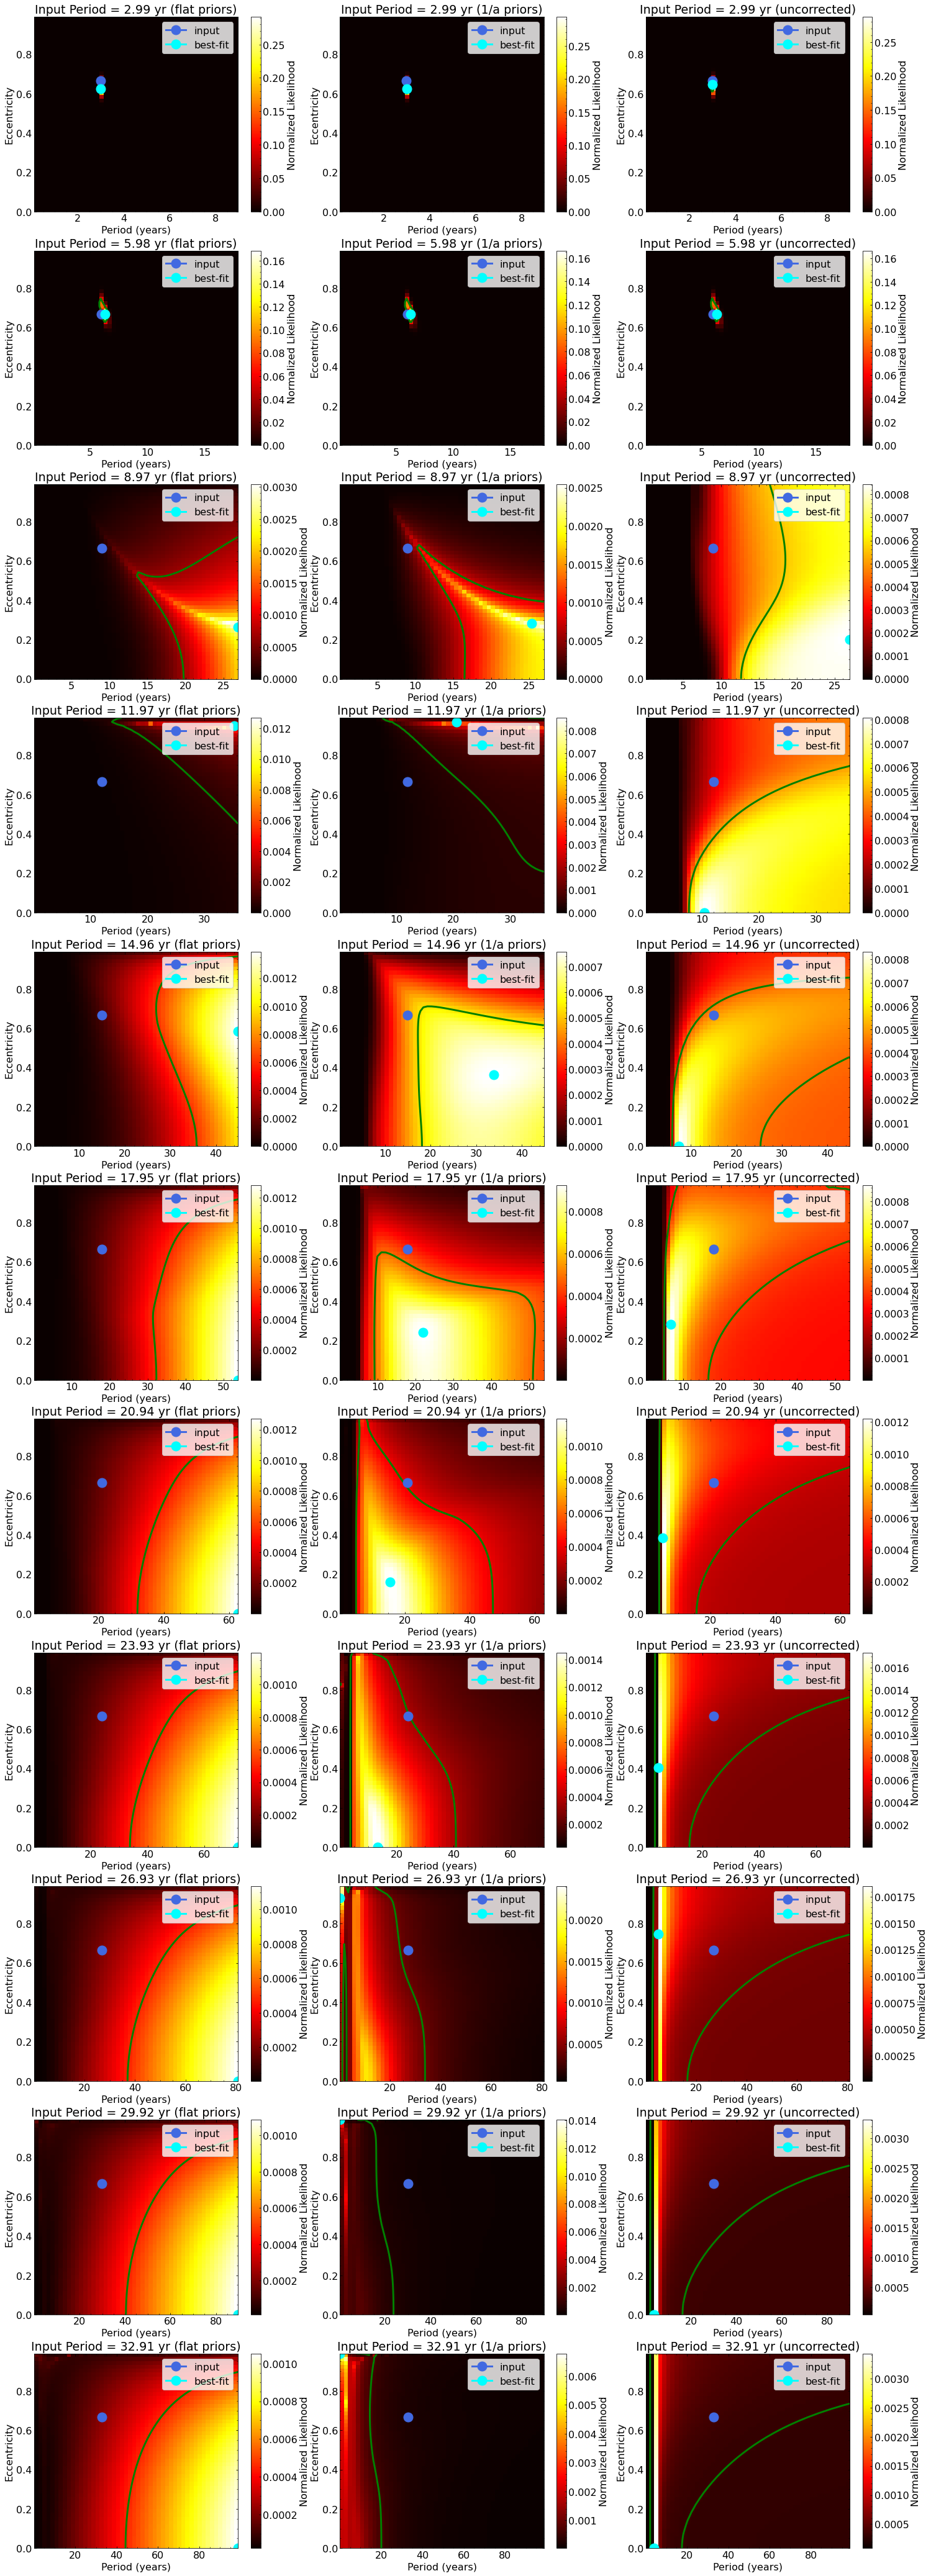

In [79]:
# vary the input period as obs_base * factor at different SNR levels 
# to check the strengths of the two approaches under the approximation of Gaussian
multi_factor = np.arange(0.5, 6, 0.5)
per_input = (t[-1]-t[0])*multi_factor
# generate random seeds for the other parameters in advance
SNR = np.array([3, 5, 10, 15]) # set SNR = 3, 5, 10, 15
noise = 5e-5
a_input = noise*SNR
om_input = np.random.rand()*2*np.pi
Om_input = np.random.rand()*2*np.pi
cosi_input = np.random.rand()

ecc_input = np.random.rand()*0.9
tp_input = np.random.rand()*2*np.pi

noise_seed = np.random.randn(len(t))*sigw
coef_skeleton= np.asarray([sintheta, costheta, t*sintheta, t*costheta, parfac, 
                          sintheta, sintheta, costheta, costheta])/sigw[np.newaxis, :]

# set the number of grid points for each parameter
p_num = [50]
ecc_num = [50]
tp_num = [200]
    

for j in range(len(SNR)):
    # calculate Thiele-Innes elements
    A = a_input[j]*(np.cos(Om_input)*np.cos(om_input) - np.sin(Om_input)*np.sin(om_input)*cosi_input)
    B = a_input[j]*(np.sin(Om_input)*np.cos(om_input) + np.cos(Om_input)*np.sin(om_input)*cosi_input)
    F = a_input[j]*(-np.cos(Om_input)*np.sin(om_input) - np.sin(Om_input)*np.cos(om_input)*cosi_input)
    G = a_input[j]*(-np.sin(Om_input)*np.sin(om_input) + np.cos(Om_input)*np.cos(om_input)*cosi_input)
    
    df = pd.DataFrame()
    
    plt.clf()
    fig, axes = plt.subplots(len(multi_factor), 3, figsize=(25, 75))
    
    
    for i in range(len(multi_factor)):
        per = round(per_input[i], 4)
        X, Y = calc_XY(t, t.shape[0], tp_input, per, ecc_input)
        wobs_fake = B*X*sintheta + G*Y*sintheta + A*X*costheta + F*Y*costheta + noise_seed
    
        # set the range of period and eccentricity 
        p_range = [0.1, per*3]
        ecc_range = [0, 0.99]

        p_grid, ecc_grid, tp_grid = create_grid(p_num, ecc_num, tp_num, p_range, ecc_range)
        x, y = np.meshgrid(p_grid[0], ecc_grid[0])
    
         # define the orbits
        orbits = wobs_fake
        snr = orbits/sigw
    
    
        # the likelihood marginalized over tp
        like_ori_mrgnlzd_over_tp, like_mrgnlzd_over_tp_flat, like_mrgnlzd_over_tp_prop = likelihood(tp_grid[0], p_grid[0], ecc_grid[0], t, coef_skeleton, snr, sigw)
        
        # normalize the likelihood
        normlz_like_ori = like_ori_mrgnlzd_over_tp/np.sum(like_ori_mrgnlzd_over_tp)
        normlz_like_flat = like_mrgnlzd_over_tp_flat/np.sum(like_mrgnlzd_over_tp_flat)
        normlz_like_prop = like_mrgnlzd_over_tp_prop/np.sum(like_mrgnlzd_over_tp_prop)

        levels_ori = onesig(normlz_like_ori, p_grid[0], ecc_grid[0])
        levels_flat = onesig(normlz_like_flat, p_grid[0], ecc_grid[0])
        levels_prop = onesig(normlz_like_prop, p_grid[0], ecc_grid[0])

        best_fit_flat = np.where(normlz_like_flat == normlz_like_flat.max())
        best_fit_prop = np.where(normlz_like_prop == normlz_like_prop.max())
        best_fit_ori = np.where(normlz_like_ori == normlz_like_ori.max())
        
        df = df.append({'SNR':SNR[j],'a_input':a_input[j],'om_input':om_input,'Om_input':Om_input,'cosi_input':cosi_input,'per_input':per, 
                        'ecc_input':ecc_input,'tp_input':tp_input,'p_best_flat':p_grid[0][best_fit_flat[0][0]],'ecc_best_flat':ecc_grid[0][best_fit_flat[1][0]],
                        'p_best_prop':p_grid[0][best_fit_prop[0][0]],'ecc_best_prop':ecc_grid[0][best_fit_prop[1][0]],'p_best_ori':p_grid[0][best_fit_ori[0][0]],
                        'ecc_best_ori':ecc_grid[0][best_fit_ori[1][0]]}
                        , ignore_index = True)

        
        im1 = axes[i, 0].imshow(normlz_like_flat.T, origin='lower', cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto') 
        fig.colorbar(im1, ax=axes[i, 0], orientation='vertical', label='Normalized Likelihood')
        axes[i, 0].plot(per, ecc_input, color='royalblue', marker='o', markersize=15, label='input')
        axes[i, 0].plot(p_grid[0][best_fit_flat[0][0]], ecc_grid[0][best_fit_flat[1][0]], color='cyan', marker='o', markersize=15, label='best-fit')
        axes[i, 0].legend()
        axes[i, 0].contour(normlz_like_flat.T, levels_flat, colors='g', extent=[x.min(), x.max(), y.min(), y.max()])
        axes[i, 0].set_xlabel("Period (years)")
        axes[i, 0].set_ylabel("Eccentricity")
        axes[i, 0].set_title("Input Period = %.2f yr (flat priors)" %per)

        im2 = axes[i, 1].imshow(normlz_like_prop.T, origin='lower', cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto') 
        fig.colorbar(im2, ax=axes[i, 1], orientation='vertical', label='Normalized Likelihood')
        axes[i, 1].plot(per, ecc_input, color='royalblue', marker='o', markersize=15, label='input')
        axes[i, 1].plot(p_grid[0][best_fit_prop[0][0]], ecc_grid[0][best_fit_prop[1][0]], color='cyan', marker='o', markersize=15, label='best-fit')
        axes[i, 1].legend()
        axes[i, 1].contour(normlz_like_prop.T, levels_prop, colors='g', extent=[x.min(), x.max(), y.min(), y.max()])
        axes[i, 1].set_xlabel("Period (years)")
        axes[i, 1].set_ylabel("Eccentricity")
        axes[i, 1].set_title("Input Period = %.2f yr (1/a priors)" %per)
        
        im3 = axes[i, 2].imshow(normlz_like_ori.T, origin='lower', cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto') 
        fig.colorbar(im3, ax=axes[i, 2], orientation='vertical', label='Normalized Likelihood')
        axes[i, 2].plot(per, ecc_input, color='royalblue', marker='o', markersize=15, label='input')
        axes[i, 2].plot(p_grid[0][best_fit_ori[0][0]], ecc_grid[0][best_fit_ori[1][0]], color='cyan', marker='o', markersize=15, label='best-fit')
        axes[i, 2].legend()
        axes[i, 2].contour(normlz_like_ori.T, levels_ori, colors='g', extent=[x.min(), x.max(), y.min(), y.max()])
        axes[i, 2].set_xlabel("Period (years)")
        axes[i, 2].set_ylabel("Eccentricity")
        axes[i, 2].set_title("Input Period = %.2f yr (uncorrected)" %per)
    

        
    df.to_csv('./plots/fake_orbits/hip71898/fake2.3_'+str(SNR[j])+'.csv', index=False)
    plt.savefig('./plots/fake_orbits/hip71898/fake2.3_'+str(SNR[j])+'.pdf')

-4.443148789034183
2.050039039575296
16.63141995922426
39.300993969912795
70.05876107164077
108.9047212644083
155.83887454821541
210.86122092306192
273.971760388948
345.1704929458736
424.4574185938385
511.83253733284323
607.2958491628874
710.8473540839711
822.4870520960945
942.214943199257
1070.031027393459
1205.935304678701
1349.9277750549818
1502.0084385223022
1662.1772950806628
1830.4343447300635
2006.7795874705025
2191.2130233019807
2383.734652224499
2584.3444742380575
2793.0424893426543
3009.828697538291
3234.7030988249685
3467.6656932026826
3708.7164806714395
3957.8554612312328
4215.082634882068
4480.398001623943
4753.801561456856
5035.2933143808095
5324.873260395801
5622.541399501833
5928.297731698904
6242.1422569870165
6564.074975366165
6894.095886836356
7232.204991397586
7578.402289049855
7932.687779793165
8295.061463627511
8665.523340552898
9044.073410569325
9430.711673676793
9825.438129875298
10228.252779164846
10639.15562154543
11058.146657017056
11485.225885579714
11920.39

77005.54646163952
77807.4352966803
78613.47739815907
79423.67276607578
80238.02140043043
81056.52330122312
81879.17846845373
82705.98690212237
83536.94860222893
84372.06356877349
85211.33180175604
86054.75330117653
86902.32806703499
87754.05609933144
88609.93739806584
89469.97196323823
90334.15979484863
91202.5008928969
92074.99525738321
92951.64288830745
93832.44378566969
94717.39794946996
95606.5053797081
96499.76607638427
97397.18003949842
98298.74726905052
99204.4677650406
100114.34152746861
101028.36855633464
101946.54885163864
102868.88241338063
103795.36924156055
104726.00933617845
105660.80269723432
106599.74932472817
107542.84921865999
108490.10237902979
109441.50880583754
110397.06849908324
111356.78145876697
112320.64768488864
113288.66717744828
114260.83993644593
115237.16596188155
116217.64525375508
117202.27781206662
118191.06363681614
119184.00272800362
120181.09508562909
121182.3407096925
122187.73960019392
123197.29175713328
124210.9971805106
125228.85587032593
126250.

21793.487898045743
22015.456644026806
22238.549720063
22462.76712615432
22688.108862300764
22914.574928502345
23142.16532475904
23370.88005107087
23600.719107437835
23831.682493859913
24063.770210337123
24296.982256869465
24531.318633456933
24766.779340099518
25003.364376797246
25241.07374355008
25479.907440358067
25719.865467221167
25960.9478241394
26203.154511112753
26446.485528141242
26690.940875224856
26936.5205523636
27183.22455955747
27431.052896806472
27680.005564110597
27930.082561469848
28181.283888884227
28433.609546353735
28687.059533878364
28941.633851458133
29197.33249909302
29454.15547678304
29712.10278452817
29971.17442232845
30231.37039018385
30492.690688094382
30755.13531606003
31018.704274080814
31283.39756215673
31549.215180287763
31816.157128473933
32084.223406715228
32353.414015011644
32623.72895336319
32895.16822176986
33167.73182023165
33441.419748748594
33716.23200732064
33992.16859594783
34269.229514630155
34547.41476336758
34826.72434216016
35107.158251007844


9932.093173020205
10037.398258309271
10143.25828093304
10249.673240891518
10356.643138184705
10464.167972812595
10572.247744775193
10680.882454072502
10790.072100704503
10899.816684671227
11010.116205972654
11120.970664608789
11232.380060579626
11344.344393885176
11456.863664525428
11569.93787250039
11683.567017810057
11797.751100454434
11912.490120433516
12027.784077747307
12143.632972395802
12260.036804379002
12376.99557369691
12494.509280349524
12612.577924336849
12731.20150565888
12850.38002431562
12970.113480307062
13090.401873633215
13211.24520429407
13332.643472289636
13454.596677619907
13577.104820284883
13700.167900284576
13823.785917618967
13947.958872288067
14072.686764291877
14197.969593630385
14323.807360303608
14450.200064311539
14577.147705654168
14704.6502843315
14832.707800343554
14961.320253690312
15090.487644371773
15220.209972387944
15350.487237738822
15481.319440424402
15612.706580444688
15744.64865779969
15877.14567248939
16010.197624513801
16143.80451387292
16277

5809.117008417639
5870.31385366359
5931.830986112003
5993.668405762877
6055.826112616215
6118.304106672011
6181.10238793027
6244.220956390986
6307.659812054167
6371.418954919811
6435.4983849879145
6499.898102258481
6564.618106731507
6629.658398406994
6695.0189772849435
6760.699843365353
6826.700996648227
6893.02243713356
6959.664164821355
7026.626179711612
7093.908481804328
7161.511071099507
7229.4339475971465
7297.677111297246
7366.2405621998105
7435.124300304833
7504.3283256123195
7573.852638122267
7643.697237834676
7713.862124749544
7784.347298866876
7855.152760186667
7926.278508708925
7997.7245444336395
8069.490867360815
8141.577477490452
8213.984374822552
8286.711559357114
8359.759031094132
8433.126790033617
8506.81483617556
8580.823169519967
8655.151790066835
8729.800697816167
8804.769892767958
8880.059374922204
8955.669144278923
9031.599200838093
9107.84954459973
9184.420175563828
9261.311093730383
9338.522299099403
9416.053791670884
9493.905571444824
9572.07763842123
9650.56999

3724.321512953297
3762.9119510258793
3801.700935538743
3840.688466491893
3879.8745438853275
3919.259167719048
3958.8423379930555
3998.624054707346
4038.6043178619243
4078.7831274567875
4119.160483491935
4159.736385967369
4200.510834883087
4241.483830239091
4282.65537203538
4324.025460271957
4365.594094948815
4407.361276065962
4449.327003623392
4491.491277621104
4533.854098059106
4576.415464937396
4619.175378255966
4662.133838014825
4705.290844213969
4748.646396853394
4792.200495933109
4835.9531414531075
4879.904333413393
4924.054071813963
4968.4023566548185
5012.949187935959
5057.694565657385
5102.638489819095
5147.780960421093
5193.1219774633755
5238.661540945942
5284.399650868794
5330.336307231929
5376.471510035354
5422.805259279067
5469.337554963058
5516.068397087338
5562.997785651905
5610.125720656753
5657.452202101888
5704.97722998731
5752.700804313017
5800.622925079008
5848.7435922852865
5897.062805931846
5945.580566018695
5994.296872545829
6043.211725513246
6092.325124920952
614

The 1-sigma likelihood contour is at value of 0.005718692277740551
The 2-sigma likelihood contour is at value of 0.0009438639179814055
The 3-sigma likelihood contour is at value of 0.00014289704724819162
The 1-sigma likelihood contour is at value of 0.005251210222742177
The 2-sigma likelihood contour is at value of 0.0008817985281952426
The 3-sigma likelihood contour is at value of 0.00012816674012236466
The 1-sigma likelihood contour is at value of 0.0045095494137302305
The 2-sigma likelihood contour is at value of 0.0008938080537348959
The 3-sigma likelihood contour is at value of 2.3756798971508963e-05
-5.389303449812786
-0.9276244996073189
7.687320888569886
20.455532714718856
37.37701097883958
58.45175568093201
83.6797668209962
113.06104439903211
146.5955884150399
184.28339886901915
226.12447576097043
272.1188190908932
322.2664288587879
376.5673050646544
435.0214477084925
497.62885679030234
564.3895323100841
635.3034742678373
710.3706826635624
789.591157497259
872.9648987689277
960

36153.92878171375
36520.58234353531
36889.08541268553
37259.4379891644
37631.640072971924
38005.69166410812
38381.592762572975
38759.3433683665
39138.94348148866
39520.39310193951
39903.69222971901
40288.84086482716
40675.83900726398
41064.68665702946
41455.38381412358
41847.93047854639
42242.326650297844
42638.57232937796
43036.66751578675
43436.61220952417
43838.40641059028
44242.05011898505
44647.543334708454
45054.886057760545
45464.07828814129
45875.1200258507
46288.011270888754
46702.752023255496
47119.34228295087
47537.78204997492
47958.07132432762
48380.21010600899
48804.19839501899
49230.03619135769
49657.72349502504
50087.260306021046
50518.6466243457
50951.88244999904
51386.96778298102
51823.902623291666
52262.68697093098
52703.320825898954
53145.80418819558
53590.13705782087
54036.31943477482
54484.35131905743
54934.23271066869
55385.96360960864
55839.54401587725
56294.973929474494
56752.25335040039
57211.38227865496
57672.360714238195
The 1-sigma likelihood contour is at v

14285.210690799764
14433.622505839789
14582.800927161736
14732.745954765609
14883.457588651398
15034.935828819118
15187.180675268763
15340.192128000339
15493.97018701383
15648.51485230925
15803.826123886594
15959.904001745861
16116.748485887054
16274.35957631017
16432.737273015213
16591.88157600218
16751.792485271068
16912.470000821882
17073.91412265462
17236.12485076928
17399.102185165862
17562.84612584438
17727.35667280482
17892.633826047182
18058.67758557147
18225.48795137767
18393.064923465812
18561.408501835867
18730.518686487852
18900.395477421764
19071.038874637594
19242.448878135354
19414.62548791504
19587.568703976638
19761.278526320173
19935.754954945627
20110.997989853004
20287.00763104231
20463.783878513535
20641.32673226669
20819.636192301776
20998.71225861877
21178.554931217695
21359.16421009855
21540.540095261327
21722.68258670602
21905.59168443265
22089.2673884412
22273.709698731673
22458.918615304076
22644.89413815839
22831.63626729464
23019.14500271281
23207.420344412

The 1-sigma likelihood contour is at value of 0.00043846634407133266
The 2-sigma likelihood contour is at value of 0.00030113025021492846
The 3-sigma likelihood contour is at value of 0.00014783860982115827
The 1-sigma likelihood contour is at value of 0.0004429994931003226
The 2-sigma likelihood contour is at value of 0.00020234110674904974
The 3-sigma likelihood contour is at value of 6.465839298560255e-05
The 1-sigma likelihood contour is at value of 0.0005258631529175264
The 2-sigma likelihood contour is at value of 0.00012669580886722542
The 3-sigma likelihood contour is at value of 3.98268908261054e-05
-6.330022873451952
-5.667458892697752
-4.684607709482179
-3.381469323805291
-1.758043735667016
0.18566905493261743
2.449669047993595
5.033956243515988
7.938530641499668
11.163392241944791
14.708541044851202
18.573977050219042
22.75970025804817
27.26571066833874
32.092008281090614
37.23859309630383
42.70546511397845
48.492624334114424
54.600070756711744
61.02780438177045
67.77582520

4840.705256046662
4890.113799118424
4939.772870973904
4989.682471613105
5039.842601036031
5090.253259242674
5140.914446233041
5191.82616200713
5242.988406564936
5294.401179906464
5346.064482031714
5397.978312940685
5450.142672633379
5502.557561109792
5555.222978369924
5608.13892441378
5661.305399241354
5714.72240285265
5768.38993524767
5822.307996426411
5876.476586388869
5930.895705135051
5985.565352664955
6040.485528978577
6095.65623407592
6151.077467956989
6206.749230621775
6262.671522070283
6318.84434230251
6375.267691318461
6431.94156911813
6488.865975701523
6546.040911068634
6603.466375219468
6661.14236815402
6719.068889872298
6777.245940374295
6835.673519660016
6894.351627729451
6953.280264582615
7012.459430219493
7071.889124640095
7131.56934784442
7191.500099832465
7251.681380604227
7312.113190159716
7372.795528498922
7433.72839562185
7494.911791528502
7556.345716218869
7618.030169692962
7679.965151950777
7742.150662992308
7804.586702817564
7867.2732714265385
The 1-sigma likelih

3111.020391944385
3142.5898835298162
3174.3184040407996
3206.205953477337
3238.2525318394273
3270.4581391270713
3302.8227753402684
3335.346440479022
3368.0291345433243
3400.8708575331834
3433.871609448596
3467.0313902895623
3500.350200056081
3533.8280387481523
3567.464906365777
3601.2608029089574
3635.21572837769
3669.329682771976
3703.602666091816
3738.034678337211
3772.625719508157
3807.3757896046586
3842.2848886267143
3877.3530165743205
3912.5801734474826
3947.966359246197
3983.511573970467
4019.2158176202893
4055.079090195665
4091.101391696594
4127.282722123076
4163.623081475113
4200.122469752702
4236.780886955845
4273.59833308454
4310.574808138795
4347.710312118596
4385.004845023954
4422.458406854866
4460.0709976113285
4497.842617293349
4535.773265900921
4573.8629434340455
4612.111649892721
4650.519385276956
4689.086149586743
4727.811942822082
4766.696764982975
4805.740616069422
4844.94349608142
4884.305405018975
4923.826342882081
4963.506309670742
5003.345305384955
The 1-sigma li

69215.08776532015
69975.44393598122
70739.95337308025
71508.61607661725
72281.43204659225
73058.40128300521
73839.52378585609
74624.799555145
75414.22859087185
76207.8108930367
77005.54646163952
77807.4352966803
78613.47739815907
79423.67276607578
80238.02140043043
81056.52330122312
81879.17846845373
82705.98690212237
83536.94860222893
84372.06356877349
85211.33180175604
86054.75330117653
86902.32806703499
87754.05609933144
88609.93739806584
89469.97196323823
90334.15979484863
91202.5008928969
92074.99525738321
92951.64288830745
93832.44378566969
94717.39794946996
95606.5053797081
96499.76607638427
97397.18003949842
98298.74726905052
99204.4677650406
100114.34152746861
101028.36855633464
101946.54885163864
102868.88241338063
103795.36924156055
104726.00933617845
105660.80269723432
106599.74932472817
107542.84921865999
108490.10237902979
109441.50880583754
110397.06849908324
111356.78145876697
112320.64768488864
113288.66717744828
114260.83993644593
115237.16596188155
116217.64525375508

22462.76712615432
22688.108862300764
22914.574928502345
23142.16532475904
23370.88005107087
23600.719107437835
23831.682493859913
24063.770210337123
24296.982256869465
24531.318633456933
24766.779340099518
25003.364376797246
25241.07374355008
25479.907440358067
25719.865467221167
25960.9478241394
26203.154511112753
26446.485528141242
26690.940875224856
26936.5205523636
27183.22455955747
27431.052896806472
27680.005564110597
27930.082561469848
28181.283888884227
28433.609546353735
28687.059533878364
28941.633851458133
29197.33249909302
29454.15547678304
29712.10278452817
29971.17442232845
30231.37039018385
30492.690688094382
30755.13531606003
31018.704274080814
31283.39756215673
31549.215180287763
31816.157128473933
32084.223406715228
32353.414015011644
32623.72895336319
32895.16822176986
33167.73182023165
33441.419748748594
33716.23200732064
33992.16859594783
34269.229514630155
34547.41476336758
34826.72434216016
35107.158251007844
The 1-sigma likelihood contour is at value of 0.000461

6258.045967818118
6341.708497053614
6425.925963623813
6510.69836752872
6596.025708768334
6681.907987342655
6768.345203251683
6855.337356495418
6942.884447073862
7030.986474987013
7119.643440234868
7208.855342817429
7298.6221827347
7388.943959986677
7479.820674573359
7571.252326494751
7663.238915750849
7755.780442341653
7848.876906267164
7942.528307527383
8036.734646122307
8131.495922051938
8226.81213531628
8322.683285915326
8419.109373849078
8516.090399117538
8613.626361720702
8711.717261658578
8810.36309893116
8909.56387353845
9009.319585480442
9109.630234757144
9210.495821368553
9311.916345314667
9413.891806595491
9516.42220521102
9619.507541161256
9723.1478144462
9827.343025065853
9932.093173020205
10037.398258309271
10143.25828093304
10249.673240891518
10356.643138184705
10464.167972812595
10572.247744775193
10680.882454072502
10790.072100704503
10899.816684671227
11010.116205972654
11120.970664608789
11232.380060579626
11344.344393885176
11456.863664525428
11569.93787250039
11683.

6826.700996648227
6893.02243713356
6959.664164821355
7026.626179711612
7093.908481804328
7161.511071099507
7229.4339475971465
7297.677111297246
7366.2405621998105
7435.124300304833
7504.3283256123195
7573.852638122267
7643.697237834676
7713.862124749544
7784.347298866876
7855.152760186667
7926.278508708925
7997.7245444336395
8069.490867360815
8141.577477490452
8213.984374822552
8286.711559357114
8359.759031094132
8433.126790033617
8506.81483617556
8580.823169519967
8655.151790066835
8729.800697816167
8804.769892767958
8880.059374922204
8955.669144278923
9031.599200838093
9107.84954459973
9184.420175563828
9261.311093730383
9338.522299099403
9416.053791670884
9493.905571444824
9572.07763842123
9650.569992600098
9729.382633981422
9808.515562565211
9887.96877835146
9967.742281340168
10047.83607153134
The 1-sigma likelihood contour is at value of 0.0004420274512145489
The 2-sigma likelihood contour is at value of 0.00027042782720145214
The 3-sigma likelihood contour is at value of 9.179048

3840.688466491893
3879.8745438853275
3919.259167719048
3958.8423379930555
3998.624054707346
4038.6043178619243
4078.7831274567875
4119.160483491935
4159.736385967369
4200.510834883087
4241.483830239091
4282.65537203538
4324.025460271957
4365.594094948815
4407.361276065962
4449.327003623392
4491.491277621104
4533.854098059106
4576.415464937396
4619.175378255966
4662.133838014825
4705.290844213969
4748.646396853394
4792.200495933109
4835.9531414531075
4879.904333413393
4924.054071813963
4968.4023566548185
5012.949187935959
5057.694565657385
5102.638489819095
5147.780960421093
5193.1219774633755
5238.661540945942
5284.399650868794
5330.336307231929
5376.471510035354
5422.805259279067
5469.337554963058
5516.068397087338
5562.997785651905
5610.125720656753
5657.452202101888
5704.97722998731
5752.700804313017
5800.622925079008
5848.7435922852865
5897.062805931846
5945.580566018695
5994.296872545829
6043.211725513246
6092.325124920952
6141.637070768937
6191.147563057215
6240.856601785773
The 

The 1-sigma likelihood contour is at value of 0.019942773517628055
The 2-sigma likelihood contour is at value of 0.0036876284588226384
The 3-sigma likelihood contour is at value of 0.00047291961026020536
The 1-sigma likelihood contour is at value of 0.027923439884901462
The 2-sigma likelihood contour is at value of 0.0030503396098237046
The 3-sigma likelihood contour is at value of 0.00042972188780185296
The 1-sigma likelihood contour is at value of 0.029107193144664215
The 2-sigma likelihood contour is at value of 0.0033000712080773647
The 3-sigma likelihood contour is at value of 0.00044141896734603786
-5.389303449812786
-0.9276244996073189
7.687320888569886
20.455532714718856
37.37701097883958
58.45175568093201
83.6797668209962
113.06104439903211
146.5955884150399
184.28339886901915
226.12447576097043
272.1188190908932
322.2664288587879
376.5673050646544
435.0214477084925
497.62885679030234
564.3895323100841
635.3034742678373
710.3706826635624
789.591157497259
872.9648987689277
960.

The 1-sigma likelihood contour is at value of 0.0007528588710531642
The 2-sigma likelihood contour is at value of 0.00015775038342684638
The 3-sigma likelihood contour is at value of 1.513208907133968e-05
The 1-sigma likelihood contour is at value of 0.0007547874325671446
The 2-sigma likelihood contour is at value of 0.00016456015528448426
The 3-sigma likelihood contour is at value of 1.5280900467340164e-05
The 1-sigma likelihood contour is at value of 0.0010781192025499657
The 2-sigma likelihood contour is at value of 0.0001814080922941891
The 3-sigma likelihood contour is at value of 1.5063092395093597e-05
-6.070269950418066
-4.470214774352172
-1.7458295431587914
2.1028857431621475
7.075931084610602
13.173306481186614
20.3950119328902
28.741047439721285
38.2114130016799
48.80610861876605
60.52513429097975
73.36849001832108
87.33617580078983
102.4281916383862
118.64453753111003
135.98521347896138
154.4502194819404
174.039555540047
194.7532216532809
216.59121782164237
239.5535440451314

14883.457588651398
15034.935828819118
15187.180675268763
15340.192128000339
15493.97018701383
15648.51485230925
15803.826123886594
15959.904001745861
16116.748485887054
16274.35957631017
16432.737273015213
16591.88157600218
16751.792485271068
16912.470000821882
17073.91412265462
17236.12485076928
17399.102185165862
17562.84612584438
17727.35667280482
17892.633826047182
18058.67758557147
18225.48795137767
18393.064923465812
18561.408501835867
18730.518686487852
18900.395477421764
19071.038874637594
19242.448878135354
19414.62548791504
19587.568703976638
19761.278526320173
19935.754954945627
20110.997989853004
20287.00763104231
20463.783878513535
20641.32673226669
20819.636192301776
20998.71225861877
21178.554931217695
21359.16421009855
21540.540095261327
21722.68258670602
21905.59168443265
22089.2673884412
22273.709698731673
22458.918615304076
22644.89413815839
22831.63626729464
23019.14500271281
23207.42034441291
23396.46229239493
23586.27084665887
23776.84600720473
23968.18777403253
T

7704.6109994034905
7784.971391361791
7865.74833703808
7946.941836432358
8028.551889544623
8110.5784963748765
8193.02165692312
8275.881371189354
8359.15763917358
8442.850460875794
8526.959836295999
8611.485765434192
8696.428248290373
8781.787284864544
8867.562875156706
8953.755019166856
9040.363716894997
9127.388968341129
9214.830773505244
9302.68913238735
9390.964044987444
9479.655511305531
9568.763531341612
9658.288105095675
9748.22923256773
9838.586913757774
9929.361148665808
10020.55193729183
10112.159279635842
10204.183175697844
10296.623625477838
10389.480628975818
10482.754186191789
10576.44429712575
10670.550961777693
10765.074180147638
10860.013952235564
10955.37027804148
11051.143157565384
11147.33259080728
11243.938577767169
11340.96111844504
11438.400212840908
11536.255860954761
11634.528062786603
11733.216818336436
11832.32212760426
11931.843990590069
12031.78240729387
12132.137377715659
12232.908901855437
12334.096979713207
12435.701611288967
12537.722796582706
12640.16053

4840.705256046662
4890.113799118424
4939.772870973904
4989.682471613105
5039.842601036031
5090.253259242674
5140.914446233041
5191.82616200713
5242.988406564936
5294.401179906464
5346.064482031714
5397.978312940685
5450.142672633379
5502.557561109792
5555.222978369924
5608.13892441378
5661.305399241354
5714.72240285265
5768.38993524767
5822.307996426411
5876.476586388869
5930.895705135051
5985.565352664955
6040.485528978577
6095.65623407592
6151.077467956989
6206.749230621775
6262.671522070283
6318.84434230251
6375.267691318461
6431.94156911813
6488.865975701523
6546.040911068634
6603.466375219468
6661.14236815402
6719.068889872298
6777.245940374295
6835.673519660016
6894.351627729451
6953.280264582615
7012.459430219493
7071.889124640095
7131.56934784442
7191.500099832465
7251.681380604227
7312.113190159716
7372.795528498922
7433.72839562185
7494.911791528502
7556.345716218869
7618.030169692962
7679.965151950777
7742.150662992308
7804.586702817564
7867.2732714265385
The 1-sigma likelih

The 1-sigma likelihood contour is at value of 0.0004573366964168456
The 2-sigma likelihood contour is at value of 0.000277930858212178
The 3-sigma likelihood contour is at value of 8.63300341257791e-05
The 1-sigma likelihood contour is at value of 0.0004850693491071989
The 2-sigma likelihood contour is at value of 0.00018554094734839552
The 3-sigma likelihood contour is at value of 4.07388689575303e-05
The 1-sigma likelihood contour is at value of 0.0005146766906825867
The 2-sigma likelihood contour is at value of 0.00012294040451487064
The 3-sigma likelihood contour is at value of 3.228480259682377e-05


<Figure size 432x288 with 0 Axes>

<Figure size 1800x5400 with 0 Axes>

<Figure size 1800x5400 with 0 Axes>

<Figure size 1800x5400 with 0 Axes>

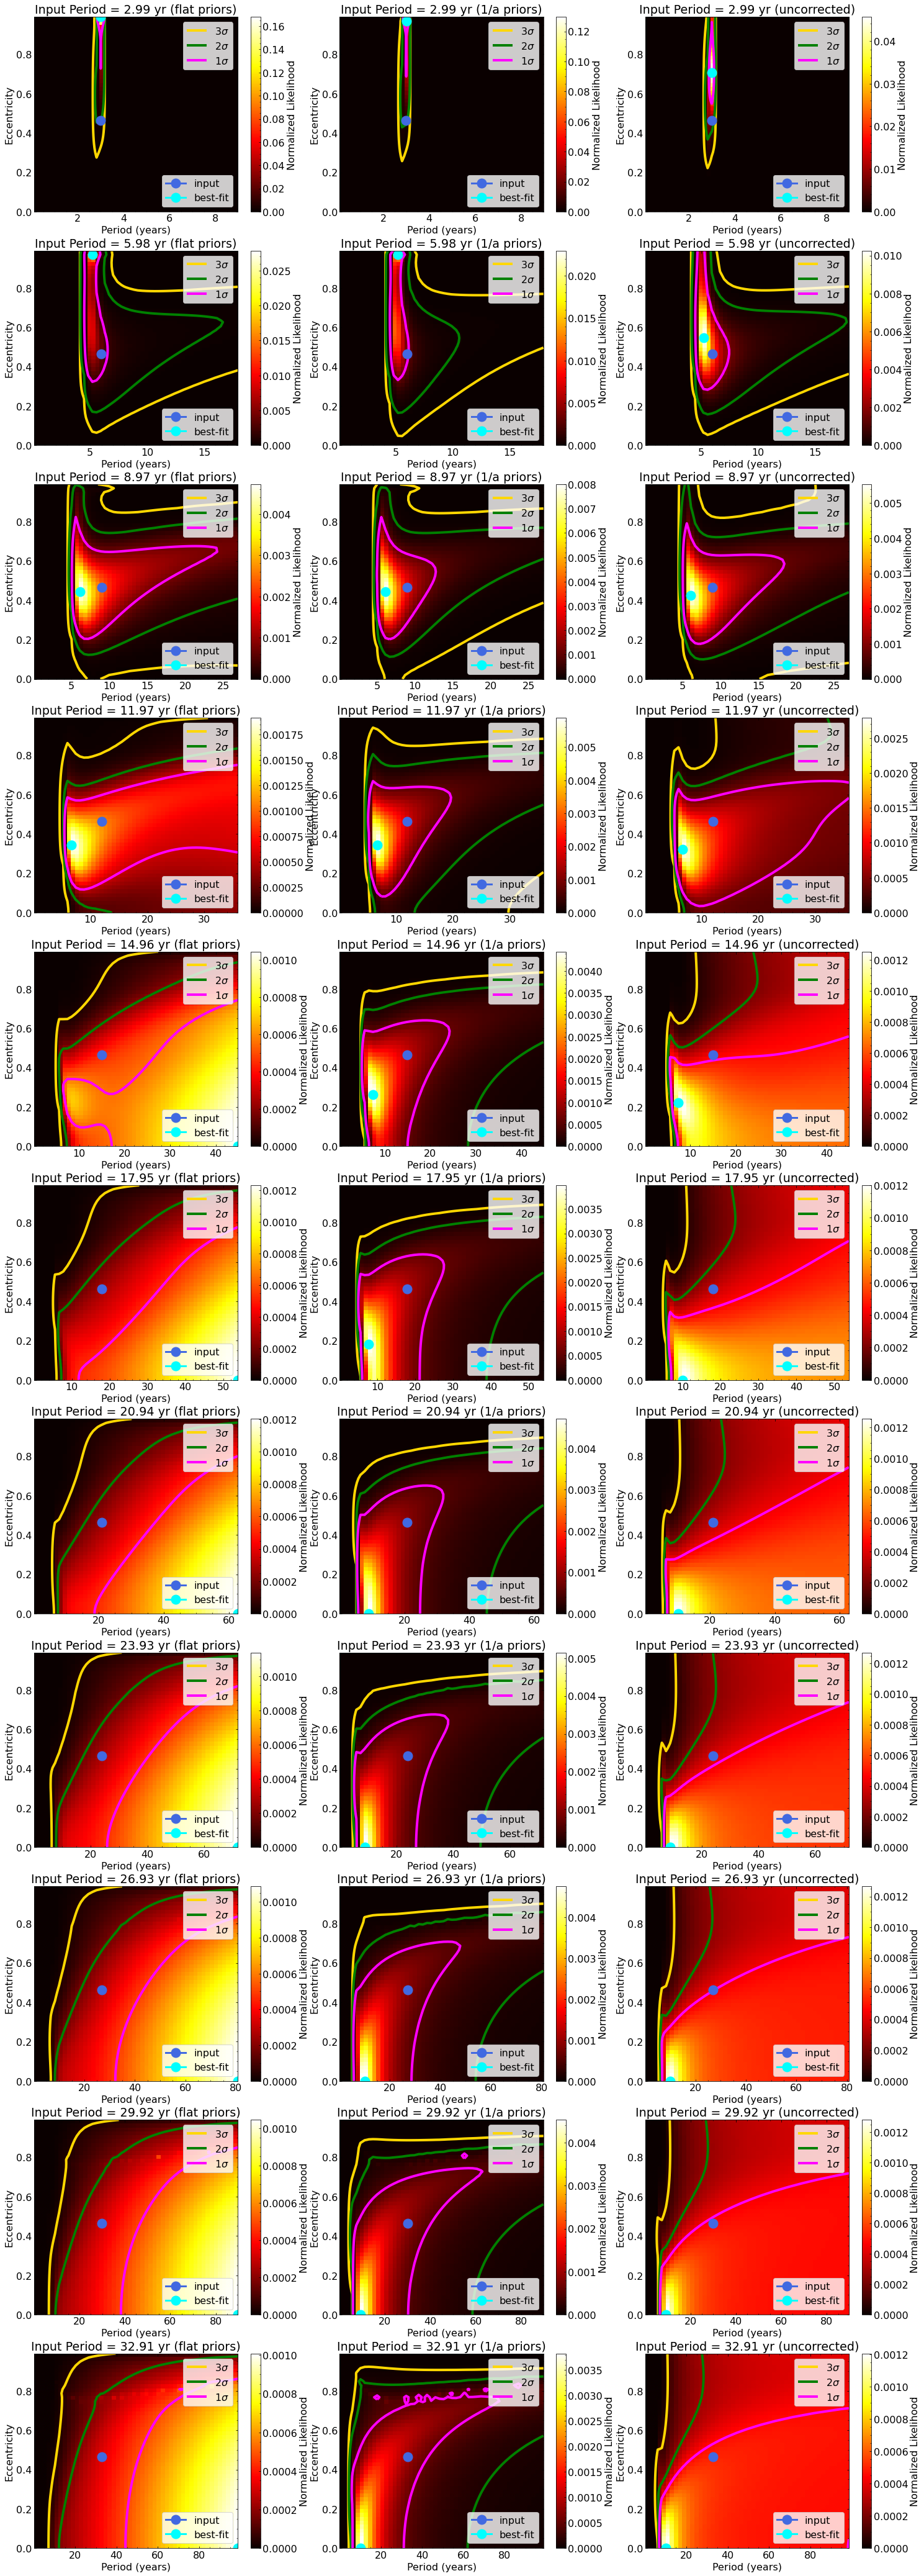

In [137]:
# check if the 2-sigma and 3-sigma contours can encompass all input points

# vary the input period as obs_base * factor at different SNR levels 
# to check the strengths of the two approaches under the approximation of Gaussian
SNR = np.array([3, 5, 10, 15]) # set SNR = 3, 5, 10, 15
multi_factor = np.arange(0.5, 6, 0.5)
per_input = (t[-1]-t[0])*multi_factor

coef_skeleton= np.asarray([sintheta, costheta, t*sintheta, t*costheta, parfac, 
                          sintheta, sintheta, costheta, costheta])/sigw[np.newaxis, :]
coef_ske5p = np.asarray([sintheta, costheta, t*sintheta, t*costheta, parfac])/sigw[np.newaxis, :]

# generate random seeds for the fixed parameters in advance
om_input = np.random.rand()*2*np.pi
Om_input = np.random.rand()*2*np.pi
cosi_input = np.random.rand()

ecc_input = np.random.rand()*0.9
tp_input = np.random.rand()*2*np.pi

noise_seed = np.random.randn(len(t))*sigw

# create an array containing various semi-major axes used to estimate the effective SNR 
a_input_test = np.arange(1e-5, 5e-3, 2e-5)

# set the number of grid points for each parameter
p_num = [50]
ecc_num = [50]
tp_num = [200]
    

for j in range(len(SNR)):
    df = pd.DataFrame()
    plt.clf()
    fig, axes = plt.subplots(len(multi_factor), 3, figsize=(25, 75))
    
    
    for i in range(len(multi_factor)):
        per = round(per_input[i], 4)        
        # compute the interpolated function of the semi-major axis in terms of SNR and input period
        eff_a = modified_a(a_input_test, per, om_input, Om_input, cosi_input, tp_input, ecc_input, noise_seed, t, coef_skeleton, coef_ske5p, sigw)
        # calculate Thiele-Innes elements
        a_input = eff_a(SNR[j])
        A = a_input*(np.cos(Om_input)*np.cos(om_input) - np.sin(Om_input)*np.sin(om_input)*cosi_input)
        B = a_input*(np.sin(Om_input)*np.cos(om_input) + np.cos(Om_input)*np.sin(om_input)*cosi_input)
        F = a_input*(-np.cos(Om_input)*np.sin(om_input) - np.sin(Om_input)*np.cos(om_input)*cosi_input)
        G = a_input*(-np.sin(Om_input)*np.sin(om_input) + np.cos(Om_input)*np.cos(om_input)*cosi_input)
        X, Y = calc_XY(t, t.shape[0], tp_input, per, ecc_input)
        wobs_fake = B*X*sintheta + G*Y*sintheta + A*X*costheta + F*Y*costheta + noise_seed
    
        # set the range of period and eccentricity 
        p_range = [0.1, per*3]
        ecc_range = [0, 0.99]

        p_grid, ecc_grid, tp_grid = create_grid(p_num, ecc_num, tp_num, p_range, ecc_range)
        x, y = np.meshgrid(p_grid[0], ecc_grid[0])
    
         # define the orbits
        orbits = wobs_fake
        snr = orbits/sigw # normalized 1D measurements
    
    
        # the likelihood marginalized over tp
        like_ori_mrgnlzd_over_tp, like_mrgnlzd_over_tp_flat, like_mrgnlzd_over_tp_prop = likelihood(tp_grid[0], p_grid[0], ecc_grid[0], t, coef_skeleton, snr, sigw)
        
        # normalize the likelihood
        normlz_like_ori = like_ori_mrgnlzd_over_tp/np.sum(like_ori_mrgnlzd_over_tp)
        normlz_like_flat = like_mrgnlzd_over_tp_flat/np.sum(like_mrgnlzd_over_tp_flat)
        normlz_like_prop = like_mrgnlzd_over_tp_prop/np.sum(like_mrgnlzd_over_tp_prop)
        
        # calculate the thresholds of confidence intervals
        levels_ori = confint(normlz_like_ori, p_grid[0], ecc_grid[0])
        levels_flat = confint(normlz_like_flat, p_grid[0], ecc_grid[0])
        levels_prop = confint(normlz_like_prop, p_grid[0], ecc_grid[0])
        
        best_fit_flat = np.where(normlz_like_flat == normlz_like_flat.max())
        best_fit_prop = np.where(normlz_like_prop == normlz_like_prop.max())
        best_fit_ori = np.where(normlz_like_ori == normlz_like_ori.max())
        
        df = df.append({'SNR':SNR[j],'a_input':a_input,'om_input':om_input,'Om_input':Om_input,'cosi_input':cosi_input,'per_input':per, 
                        'ecc_input':ecc_input,'tp_input':tp_input,'p_best_flat':p_grid[0][best_fit_flat[0][0]],'ecc_best_flat':ecc_grid[0][best_fit_flat[1][0]],
                        'p_best_prop':p_grid[0][best_fit_prop[0][0]],'ecc_best_prop':ecc_grid[0][best_fit_prop[1][0]],'p_best_ori':p_grid[0][best_fit_ori[0][0]],
                        'ecc_best_ori':ecc_grid[0][best_fit_ori[1][0]]}
                        , ignore_index = True)

        
        im1 = axes[i, 0].imshow(normlz_like_flat.T, origin='lower', cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto') 
        fig.colorbar(im1, ax=axes[i, 0], orientation='vertical', label='Normalized Likelihood')
        m, = axes[i, 0].plot(per, ecc_input, color='royalblue', marker='o', markersize=15, label='input')
        n, = axes[i, 0].plot(p_grid[0][best_fit_flat[0][0]], ecc_grid[0][best_fit_flat[1][0]], color='cyan', marker='o', markersize=15, label='best-fit')
        first_legend = axes[i, 0].legend(handles=[m, n], loc=4) 
        # Add the legend manually to the current Axes.
        axes[i, 0].add_artist(first_legend)
        # Add labels of contours in the legend
        contour_label = [r'$3 \sigma$', r'$2 \sigma$', r'$1 \sigma$']
        C = axes[i, 0].contour(x, y, normlz_like_flat.T, levels=levels_flat, linewidths=4, colors=('gold', 'green', 'magenta'), extent=[x.min(), x.max(), y.min(), y.max()])
        h = C.collections
        l = [contour_label[c] for c in range(len(contour_label))]
        axes[i, 0].legend(h,l, loc=1)            
        axes[i, 0].set_xlabel("Period (years)")
        axes[i, 0].set_ylabel("Eccentricity")
        axes[i, 0].set_title("Input Period = %.2f yr (flat priors)" %per)

        im2 = axes[i, 1].imshow(normlz_like_prop.T, origin='lower', cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto') 
        fig.colorbar(im2, ax=axes[i, 1], orientation='vertical', label='Normalized Likelihood')
        m, = axes[i, 1].plot(per, ecc_input, color='royalblue', marker='o', markersize=15, label='input')
        n, = axes[i, 1].plot(p_grid[0][best_fit_prop[0][0]], ecc_grid[0][best_fit_prop[1][0]], color='cyan', marker='o', markersize=15, label='best-fit')
        first_legend = axes[i, 1].legend(handles=[m, n], loc=4)         
        # Add the legend manually to the current Axes.
        axes[i, 1].add_artist(first_legend)
        # Add labels of contours in the legend
        contour_label = [r'$3 \sigma$', r'$2 \sigma$', r'$1 \sigma$']
        C = axes[i, 1].contour(x, y, normlz_like_prop.T, levels=levels_prop, linewidths=4, colors=('gold', 'green', 'magenta'), extent=[x.min(), x.max(), y.min(), y.max()])
        h = C.collections
        l = [contour_label[c] for c in range(len(contour_label))]
        axes[i, 1].legend(h,l, loc=1)         
        axes[i, 1].set_xlabel("Period (years)")
        axes[i, 1].set_ylabel("Eccentricity")
        axes[i, 1].set_title("Input Period = %.2f yr (1/a priors)" %per)
        
        im3 = axes[i, 2].imshow(normlz_like_ori.T, origin='lower', cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto') 
        fig.colorbar(im3, ax=axes[i, 2], orientation='vertical', label='Normalized Likelihood')
        m, = axes[i, 2].plot(per, ecc_input, color='royalblue', marker='o', markersize=15, label='input')
        n, = axes[i, 2].plot(p_grid[0][best_fit_ori[0][0]], ecc_grid[0][best_fit_ori[1][0]], color='cyan', marker='o', markersize=15, label='best-fit')
        first_legend = axes[i, 2].legend(handles=[m, n], loc=4)         
        # Add the legend manually to the current Axes.
        axes[i, 2].add_artist(first_legend)
        # Add labels of contours in the legend
        contour_label = [r'$3 \sigma$', r'$2 \sigma$', r'$1 \sigma$']
        C = axes[i, 2].contour(x, y, normlz_like_ori.T, levels=levels_ori, linewidths=4, colors=('gold', 'green', 'magenta'), extent=[x.min(), x.max(), y.min(), y.max()])
        h = C.collections
        l = [contour_label[c] for c in range(len(contour_label))]
        axes[i, 2].legend(h,l, loc=1)     
        axes[i, 2].set_xlabel("Period (years)")
        axes[i, 2].set_ylabel("Eccentricity")
        axes[i, 2].set_title("Input Period = %.2f yr (uncorrected)" %per)
    
    df.to_csv('./plots/fake_orbits/hip71898/fake2.4_'+str(SNR[j])+'.csv', index=False)
    plt.savefig('./plots/fake_orbits/hip71898/fake2.4_'+str(SNR[j])+'.pdf')

# HD 159062

In [138]:
# Read data file with scanning law parameters (angles and parallax factors)
gaia_scan_hd159062 = QTable.read('./data/scan_law_par/hd159062_trunc.csv')

# grab the obs. time
juld = gaia_scan_hd159062['ObservationTimeAtBarycentre[BarycentricJulianDateInTCB]']
ref_ep = 2457389.0 # Reference Epoch (J2016.0)
t = (juld - ref_ep)/365.25 # in Julian years from 2016.0

# grab scanning law parameter variables
theta = gaia_scan_hd159062['scanAngle[rad]']
costheta = np.cos(theta)
sintheta = np.sin(theta)
parfac = gaia_scan_hd159062['parallaxFactorAlongScan']

sigw = np.ones(len(theta))*5e-5

coef_skeleton= np.asarray([sintheta, costheta, t*sintheta, t*costheta, parfac, 
                          sintheta, sintheta, costheta, costheta])/sigw[np.newaxis, :]

# HD 4747

In [140]:
# Read data file with scanning law parameters (angles and parallax factors)
gaia_scan_hd4747 = QTable.read('./data/scan_law_par/hd4747_trunc.csv')

# grab the obs. time
juld = gaia_scan_hd4747['ObservationTimeAtBarycentre[BarycentricJulianDateInTCB]']
ref_ep = 2457389.0 # Reference Epoch (J2016.0)
t = (juld - ref_ep)/365.25 # in Julian years from 2016.0

# grab scanning law parameter variables
theta = gaia_scan_hd4747['scanAngle[rad]']
costheta = np.cos(theta)
sintheta = np.sin(theta)
parfac = gaia_scan_hd4747['parallaxFactorAlongScan']

sigw = np.ones(len(theta))*5e-5

coef_skeleton= np.asarray([sintheta, costheta, t*sintheta, t*costheta, parfac, 
                          sintheta, sintheta, costheta, costheta])/sigw[np.newaxis, :]

# rho01cnc

In [69]:
# Read data file with scanning law parameters (angles and parallax factors)
gaia_scan_rho01cnc = QTable.read('./data/scan_law_par/rho01cnc_trunc.csv')

# grab the obs. time
juld = gaia_scan_rho01cnc['ObservationTimeAtBarycentre[BarycentricJulianDateInTCB]']
ref_ep = 2457389.0 # Reference Epoch (J2016.0)
t = (juld - ref_ep)/365.25 # in Julian years from 2016.0

# grab scanning law parameter variables
theta = gaia_scan_rho01cnc['scanAngle[rad]']
costheta = np.cos(theta)
sintheta = np.sin(theta)
parfac = gaia_scan_rho01cnc['parallaxFactorAlongScan']

sigw = np.ones(len(theta))*5e-5

coef_skeleton= np.asarray([sintheta, costheta, t*sintheta, t*costheta, parfac, 
                          sintheta, sintheta, costheta, costheta])/sigw[np.newaxis, :]

# HD 1237 

In [71]:
# Read data file with scanning law parameters (angles and parallax factors)
gaia_scan_hd1237 = QTable.read('./data/scan_law_par/hd1237_trunc.csv')

# grab the obs. time
juld = gaia_scan_hd1237['ObservationTimeAtBarycentre[BarycentricJulianDateInTCB]']
ref_ep = 2457389.0 # Reference Epoch (J2016.0)
t = (juld - ref_ep)/365.25 # in Julian years from 2016.0

# grab scanning law parameter variables
theta = gaia_scan_hd1237['scanAngle[rad]']
costheta = np.cos(theta)
sintheta = np.sin(theta)
parfac = gaia_scan_hd1237['parallaxFactorAlongScan']

sigw = np.ones(len(theta))*5e-5

coef_skeleton= np.asarray([sintheta, costheta, t*sintheta, t*costheta, parfac, 
                          sintheta, sintheta, costheta, costheta])/sigw[np.newaxis, :]

# HD 79210

In [74]:
# Read data file with scanning law parameters (angles and parallax factors)
gaia_scan_hd79210 = QTable.read('./data/scan_law_par/hd79210_trunc.csv')

# grab the obs. time
juld = gaia_scan_hd79210['ObservationTimeAtBarycentre[BarycentricJulianDateInTCB]']
ref_ep = 2457389.0 # Reference Epoch (J2016.0)
t = (juld - ref_ep)/365.25 # in Julian years from 2016.0

# grab scanning law parameter variables
theta = gaia_scan_hd79210['scanAngle[rad]']
costheta = np.cos(theta)
sintheta = np.sin(theta)
parfac = gaia_scan_hd79210['parallaxFactorAlongScan']

sigw = np.ones(len(theta))*5e-5

coef_skeleton= np.asarray([sintheta, costheta, t*sintheta, t*costheta, parfac, 
                          sintheta, sintheta, costheta, costheta])/sigw[np.newaxis, :]

# HD 97101

In [76]:
# Read data file with scanning law parameters (angles and parallax factors)
gaia_scan_hd97101 = QTable.read('./data/scan_law_par/hd97101_trunc.csv')

# grab the obs. time
juld = gaia_scan_hd97101['ObservationTimeAtBarycentre[BarycentricJulianDateInTCB]']
ref_ep = 2457389.0 # Reference Epoch (J2016.0)
t = (juld - ref_ep)/365.25 # in Julian years from 2016.0

# grab scanning law parameter variables
theta = gaia_scan_hd97101['scanAngle[rad]']
costheta = np.cos(theta)
sintheta = np.sin(theta)
parfac = gaia_scan_hd97101['parallaxFactorAlongScan']

sigw = np.ones(len(theta))*5e-5

coef_skeleton= np.asarray([sintheta, costheta, t*sintheta, t*costheta, parfac, 
                          sintheta, sintheta, costheta, costheta])/sigw[np.newaxis, :]

# HD 13445

In [79]:
# Read data file with scanning law parameters (angles and parallax factors)
gaia_scan_hd13445 = QTable.read('./data/scan_law_par/hd13445_trunc.csv')

# grab the obs. time
juld = gaia_scan_hd13445['ObservationTimeAtBarycentre[BarycentricJulianDateInTCB]']
ref_ep = 2457389.0 # Reference Epoch (J2016.0)
t = (juld - ref_ep)/365.25 # in Julian years from 2016.0

# grab scanning law parameter variables
theta = gaia_scan_hd13445['scanAngle[rad]']
costheta = np.cos(theta)
sintheta = np.sin(theta)
parfac = gaia_scan_hd13445['parallaxFactorAlongScan']

sigw = np.ones(len(theta))*5e-5

coef_skeleton= np.asarray([sintheta, costheta, t*sintheta, t*costheta, parfac, 
                          sintheta, sintheta, costheta, costheta])/sigw[np.newaxis, :]

# HAT-P-32

In [9]:
# Read data file with scanning law parameters (angles and parallax factors)
gaia_scan_hatp32 = QTable.read('./data/scan_law_par/hatp32_trunc.csv')

# grab the obs. time
juld = gaia_scan_hatp32['ObservationTimeAtBarycentre[BarycentricJulianDateInTCB]']
ref_ep = 2457389.0 # Reference Epoch (J2016.0)
t = (juld - ref_ep)/365.25 # in Julian years from 2016.0

# grab scanning law parameter variables
theta = gaia_scan_hatp32['scanAngle[rad]']
costheta = np.cos(theta)
sintheta = np.sin(theta)
parfac = gaia_scan_hatp32['parallaxFactorAlongScan']

sigw = np.ones(len(theta))*5e-5

coef_skeleton= np.asarray([sintheta, costheta, t*sintheta, t*costheta, parfac, 
                          sintheta, sintheta, costheta, costheta])/sigw[np.newaxis, :]

# HAT-P-33

In [11]:
# Read data file with scanning law parameters (angles and parallax factors)
gaia_scan_hatp33 = QTable.read('./data/scan_law_par/hatp33_trunc.csv')

# grab the obs. time
juld = gaia_scan_hatp33['ObservationTimeAtBarycentre[BarycentricJulianDateInTCB]']
ref_ep = 2457389.0 # Reference Epoch (J2016.0)
t = (juld - ref_ep)/365.25 # in Julian years from 2016.0

# grab scanning law parameter variables
theta = gaia_scan_hatp33['scanAngle[rad]']
costheta = np.cos(theta)
sintheta = np.sin(theta)
parfac = gaia_scan_hatp33['parallaxFactorAlongScan']

sigw = np.ones(len(theta))*5e-5

coef_skeleton= np.asarray([sintheta, costheta, t*sintheta, t*costheta, parfac, 
                          sintheta, sintheta, costheta, costheta])/sigw[np.newaxis, :]

# HD 101930

In [13]:
# Read data file with scanning law parameters (angles and parallax factors)
gaia_scan_hd101930 = QTable.read('./data/scan_law_par/hd101930_trunc.csv')

# grab the obs. time
juld = gaia_scan_hd101930['ObservationTimeAtBarycentre[BarycentricJulianDateInTCB]']
ref_ep = 2457389.0 # Reference Epoch (J2016.0)
t = (juld - ref_ep)/365.25 # in Julian years from 2016.0

# grab scanning law parameter variables
theta = gaia_scan_hd101930['scanAngle[rad]']
costheta = np.cos(theta)
sintheta = np.sin(theta)
parfac = gaia_scan_hd101930['parallaxFactorAlongScan']

sigw = np.ones(len(theta))*5e-5

coef_skeleton= np.asarray([sintheta, costheta, t*sintheta, t*costheta, parfac, 
                          sintheta, sintheta, costheta, costheta])/sigw[np.newaxis, :]

# HD 102365

In [15]:
# Read data file with scanning law parameters (angles and parallax factors)
gaia_scan_hd102365 = QTable.read('./data/scan_law_par/hd102365_trunc.csv')

# grab the obs. time
juld = gaia_scan_hd102365['ObservationTimeAtBarycentre[BarycentricJulianDateInTCB]']
ref_ep = 2457389.0 # Reference Epoch (J2016.0)
t = (juld - ref_ep)/365.25 # in Julian years from 2016.0

# grab scanning law parameter variables
theta = gaia_scan_hd102365['scanAngle[rad]']
costheta = np.cos(theta)
sintheta = np.sin(theta)
parfac = gaia_scan_hd102365['parallaxFactorAlongScan']

sigw = np.ones(len(theta))*5e-5

coef_skeleton= np.asarray([sintheta, costheta, t*sintheta, t*costheta, parfac, 
                          sintheta, sintheta, costheta, costheta])/sigw[np.newaxis, :]

# HD 106515

In [17]:
# Read data file with scanning law parameters (angles and parallax factors)
gaia_scan_hd106515 = QTable.read('./data/scan_law_par/hd106515_trunc.csv')

# grab the obs. time
juld = gaia_scan_hd106515['ObservationTimeAtBarycentre[BarycentricJulianDateInTCB]']
ref_ep = 2457389.0 # Reference Epoch (J2016.0)
t = (juld - ref_ep)/365.25 # in Julian years from 2016.0

# grab scanning law parameter variables
theta = gaia_scan_hd106515['scanAngle[rad]']
costheta = np.cos(theta)
sintheta = np.sin(theta)
parfac = gaia_scan_hd106515['parallaxFactorAlongScan']

sigw = np.ones(len(theta))*5e-5

coef_skeleton= np.asarray([sintheta, costheta, t*sintheta, t*costheta, parfac, 
                          sintheta, sintheta, costheta, costheta])/sigw[np.newaxis, :]

# HD 109271

In [19]:
# Read data file with scanning law parameters (angles and parallax factors)
gaia_scan_hd109271 = QTable.read('./data/scan_law_par/hd109271_trunc.csv')

# grab the obs. time
juld = gaia_scan_hd109271['ObservationTimeAtBarycentre[BarycentricJulianDateInTCB]']
ref_ep = 2457389.0 # Reference Epoch (J2016.0)
t = (juld - ref_ep)/365.25 # in Julian years from 2016.0

# grab scanning law parameter variables
theta = gaia_scan_hd109271['scanAngle[rad]']
costheta = np.cos(theta)
sintheta = np.sin(theta)
parfac = gaia_scan_hd109271['parallaxFactorAlongScan']

sigw = np.ones(len(theta))*5e-5

coef_skeleton= np.asarray([sintheta, costheta, t*sintheta, t*costheta, parfac, 
                          sintheta, sintheta, costheta, costheta])/sigw[np.newaxis, :]

# HD109749

In [21]:
# Read data file with scanning law parameters (angles and parallax factors)
gaia_scan_hd109749 = QTable.read('./data/scan_law_par/hd109749_trunc.csv')

# grab the obs. time
juld = gaia_scan_hd109749['ObservationTimeAtBarycentre[BarycentricJulianDateInTCB]']
ref_ep = 2457389.0 # Reference Epoch (J2016.0)
t = (juld - ref_ep)/365.25 # in Julian years from 2016.0

# grab scanning law parameter variables
theta = gaia_scan_hd109749['scanAngle[rad]']
costheta = np.cos(theta)
sintheta = np.sin(theta)
parfac = gaia_scan_hd109749['parallaxFactorAlongScan']

sigw = np.ones(len(theta))*5e-5

coef_skeleton= np.asarray([sintheta, costheta, t*sintheta, t*costheta, parfac, 
                          sintheta, sintheta, costheta, costheta])/sigw[np.newaxis, :]